In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np

In [ ]:
tfrecord_files = [
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    "gs://rl_unplugged/atari_episodes_ordered/Breakout/run_1-00000-of-00050",
    "gs://rl_unplugged/atari_episodes_ordered/SpaceInvaders/run_1-00000-of-00050"
]

episodes_dataset = tf.data.TFRecordDataset(
    tfrecord_files,
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

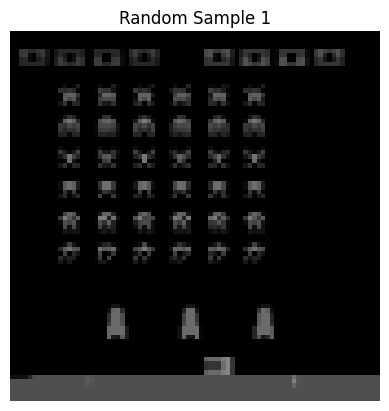

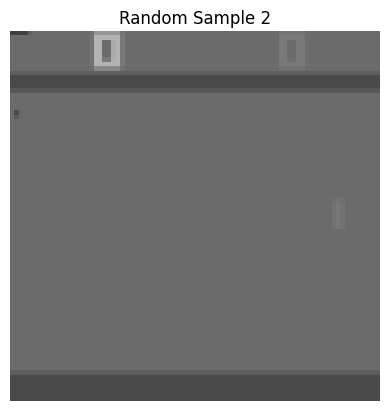

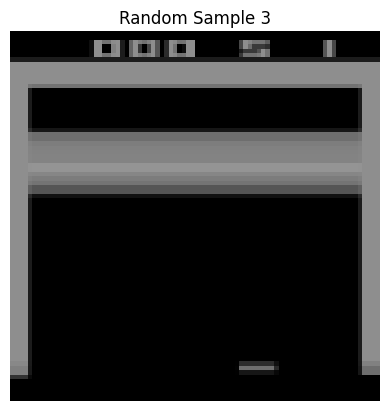

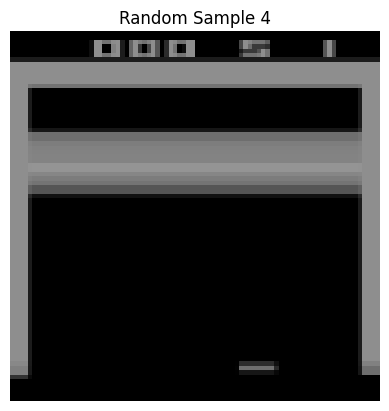

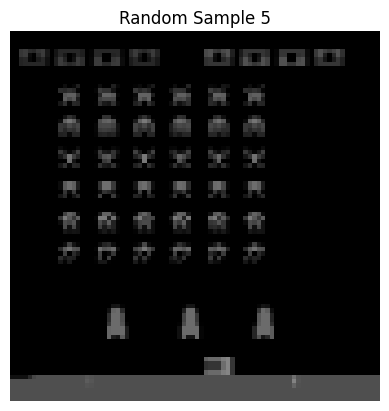

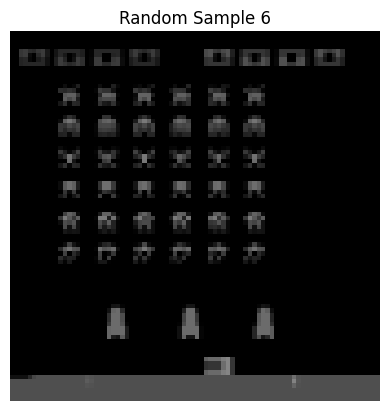

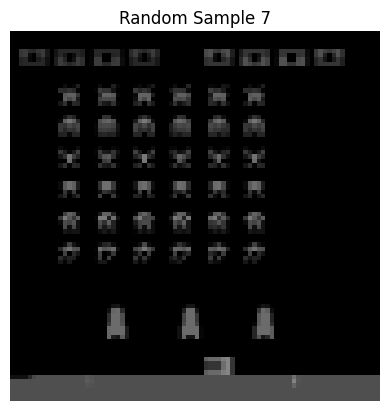

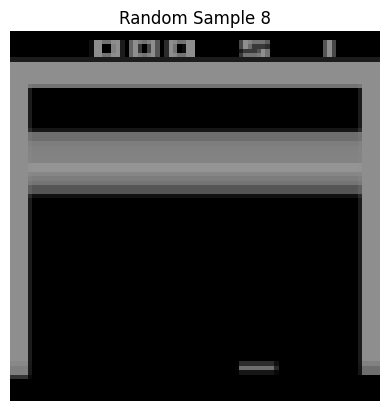

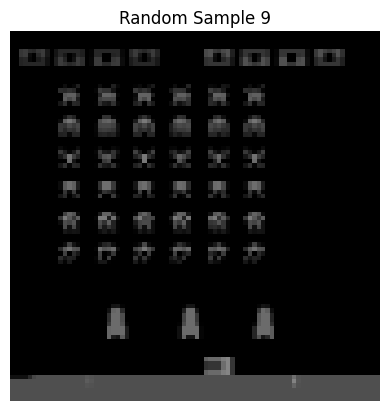

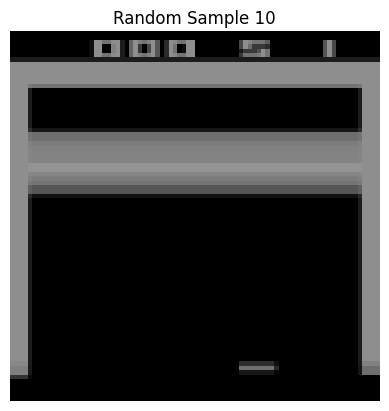

In [ ]:
episodes_dataset = episodes_dataset.shuffle(buffer_size=1000)

for i, raw_example in enumerate(episodes_dataset.take(10)):
    example = tf.train.Example()
    example.ParseFromString(raw_example.numpy())
    obs = example.features.feature["observations"].bytes_list.value
    img = tf.io.decode_image(obs[0], channels=3)
    plt.imshow(img.numpy())
    plt.title(f"Random Sample {i+1}")
    plt.axis('off')
    plt.show()

In [ ]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
clipped_rewards: float
unclipped_rewards: float
discounts: float
clipped_episode_return: float
episode_return: float
observations: bytes
actions: int64
checkpoint_idx: int64
episode_idx: int64


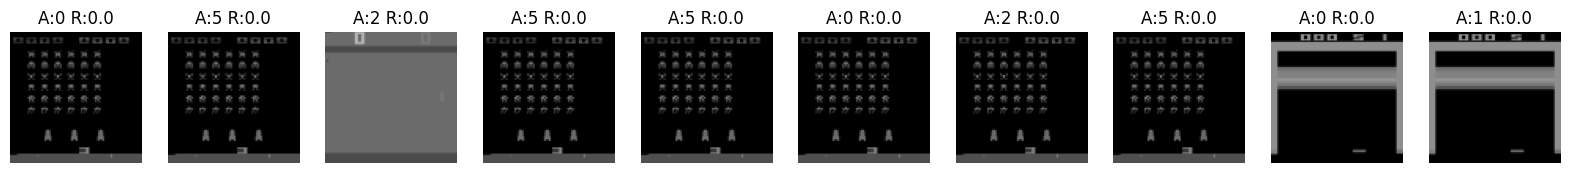

In [ ]:
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)

    obs = tf.sparse.to_dense(parsed["observations"])
    actions = tf.sparse.to_dense(parsed["actions"])
    rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

    img = tf.io.decode_image(obs[0], channels=3)
    return img, actions[0], rewards[0]

dataset_parsed = episodes_dataset.map(parse_function)

plt.figure(figsize=(20, 4))
for i, (frame, action, reward) in enumerate(dataset_parsed.take(10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(frame.numpy())
    plt.axis('off')
    plt.title(f"A:{action.numpy()} R:{reward.numpy():.1f}")
plt.show()

In [ ]:
!git clone https://github.com/Coluding/world-models.git

Cloning into 'world-models'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 65 (delta 13), reused 59 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 153.67 KiB | 38.42 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
import sys
import os
local_repo_path = os.path.abspath(os.path.join(os.getcwd(), '../world-models'))
local_repo_path = os.path.abspath(os.path.join(os.getcwd(), 'world-models'))
if local_repo_path not in sys.path:
    sys.path.append(local_repo_path)
from models.rssm import RSSM

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
feature_description = {
  "observations": tf.io.VarLenFeature(tf.string),
  "actions": tf.io.VarLenFeature(tf.int64),
  "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_sequence(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  obs = tf.sparse.to_dense(parsed["observations"])
  actions = tf.sparse.to_dense(parsed["actions"])
  rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

  # Decode images and set explicit shape
  imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
  imgs.set_shape([None, None, None, 3])  # Set partial shape info

  imgs = tf.image.resize(imgs, [64, 64])
  imgs = tf.cast(imgs, tf.float32) / 255.0
  actions = tf.cast(actions, tf.int64)
  rewards = tf.cast(rewards, tf.float32)
  return imgs, actions, rewards

batch_size = 16
sequence_length = 50

dataset = episodes_dataset.map(parse_sequence)
dataset = dataset.filter(lambda imgs, actions, rewards: tf.shape(imgs)[0] >= sequence_length)

def extract_non_overlapping_sequences(imgs, actions, rewards):
    episode_length = tf.shape(imgs)[0]
    num_sequences = episode_length // sequence_length

    if num_sequences > 0:
        trimmed_length = num_sequences * sequence_length
        imgs_trimmed = imgs[:trimmed_length]
        actions_trimmed = actions[:trimmed_length]
        rewards_trimmed = rewards[:trimmed_length]

        imgs_sequences = tf.reshape(imgs_trimmed, [num_sequences, sequence_length, 64, 64, 3])
        actions_sequences = tf.reshape(actions_trimmed, [num_sequences, sequence_length])
        rewards_sequences = tf.reshape(rewards_trimmed, [num_sequences, sequence_length])

        return tf.data.Dataset.from_tensor_slices((imgs_sequences, actions_sequences, rewards_sequences))
    else:
        return tf.data.Dataset.from_tensor_slices((
            tf.zeros((0, sequence_length, 64, 64, 3), dtype=tf.float32),
            tf.zeros((0, sequence_length), dtype=tf.int64),
            tf.zeros((0, sequence_length), dtype=tf.float32)
        ))

dataset = dataset.map(extract_non_overlapping_sequences)
dataset = dataset.flat_map(lambda x: x)  # Flatten the nested datasets
dataset = dataset.batch(batch_size, drop_remainder=True)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Check number of batches in the dataset at this point
batch_count = 0
for _ in dataset:
    batch_count += 1
print(f"Number of batches in dataset: {batch_count}")

Number of batches in dataset: 3553


(924, 64, 64, 3)
(924,)
(924,)


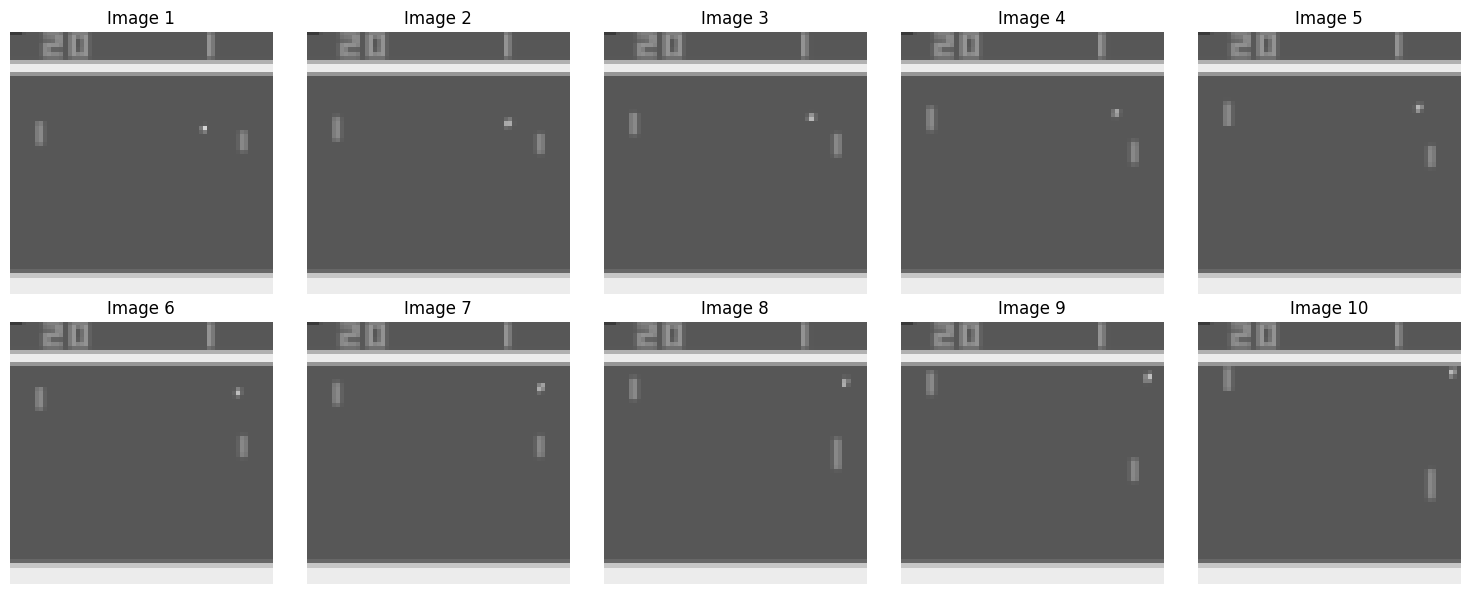

In [ ]:

example = next(iter(episodes_dataset.take(1)))
imgs, actions, rewards = parse_sequence(example)

print(imgs.shape)
print(actions.shape)
print(rewards.shape)

last_ten_imgs = imgs[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(last_ten_imgs[i], vmin=0, vmax=1)
  ax.set_title(f"Image {i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
for imgs, actions, rewards in dataset.take(1):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)

imgs: (16, 50, 64, 64, 3)
actions: (16, 50)
rewards: (16, 50)


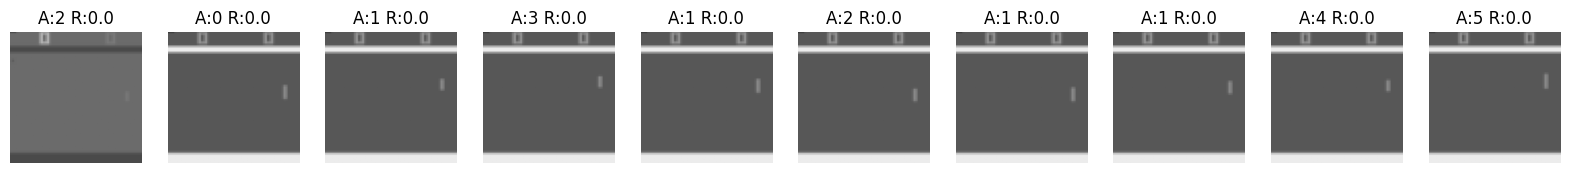

In [ ]:
for imgs, actions, rewards in dataset.take(1):
  seq_imgs = imgs[0]
  seq_actions = actions[0]
  seq_rewards = rewards[0]

  plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(seq_imgs[i].numpy())
    plt.axis("off")
    plt.title(f"A:{seq_actions[i].numpy()} R:{seq_rewards[i].numpy():.1f}")
  plt.show()

In [ ]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (677, 84, 84, 3)


In [ ]:
class AtariSequenceDataset(Dataset):
  def __init__(self, tf_dataset, num_batches):
    self.data = []
    for i, (imgs, actions, rewards) in enumerate(tf_dataset):
      if i >= num_batches:
        break
      self.data.append((
        imgs.numpy(), actions.numpy(), rewards.numpy()
      ))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    imgs, actions, rewards = self.data[idx]
    imgs = torch.tensor(imgs, dtype=torch.float32)  # [seq, W, H, 3]
    actions = torch.tensor(actions, dtype=torch.long)  # [seq]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # [seq]
    return imgs, actions, rewards

In [ ]:
num_batches = 100
num_batches = 500
atari_dataset = AtariSequenceDataset(dataset, num_batches)
dataloader = DataLoader(atari_dataset, batch_size=1, shuffle=True)

In [ ]:
print("=== Dataset Size Information ===")
print(f"Number of batches: {len(atari_dataset)}")

sample_batch = atari_dataset[0]
imgs, actions, rewards = sample_batch
print(f"Shape of images in one batch: {imgs.shape}")
print(f"Shape of actions in one batch: {actions.shape}")
print(f"Shape of rewards in one batch: {rewards.shape}")

batch_size_in_dataset = imgs.shape[0]
sequence_length_per_example = imgs.shape[1]
total_examples = len(atari_dataset) * batch_size_in_dataset

print(f"\n=== Breakdown ===")
print(f"Sequences per batch: {batch_size_in_dataset}")
print(f"Frames per sequence: {sequence_length_per_example}")
print(f"Total sequences (examples): {total_examples}")
print(f"Total frames: {total_examples * sequence_length_per_example}")


=== Dataset Size Information ===
Number of batches: 500
Shape of images in one batch: torch.Size([16, 50, 64, 64, 3])
Shape of actions in one batch: torch.Size([16, 50])
Shape of rewards in one batch: torch.Size([16, 50])

=== Breakdown ===
Sequences per batch: 16
Frames per sequence: 50
Total sequences (examples): 8000
Total frames: 400000


In [ ]:
sample_batch = next(iter(dataset.take(1)))
sample_imgs = sample_batch[0]
print(f"Actual image shape in dataset: {len(sample_batch)}")
print(f"Actual image shape in dataset: {sample_imgs.shape}")
print(f"Individual image shape: {sample_imgs[0, 0].shape}")

Actual image shape in dataset: 3
Actual image shape in dataset: (16, 50, 64, 64, 3)
Individual image shape: (64, 64, 3)


In [ ]:
from models.models import EncoderCNN, DecoderCNN, RewardModel
from models.rssm import RSSM
from models.dynamics import DynamicsModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

action_dim = 6
hidden_size = 1024
state_size = 32
encoder_embedding_dim = 1024
image_height, image_width = sample_imgs.shape[2], sample_imgs.shape[3]

encoder = EncoderCNN(
    in_channels=3,
    embedding_dim=encoder_embedding_dim,
    input_shape=(image_height, image_width)
).to(device)

decoder = DecoderCNN(
    hidden_size=hidden_size,
    state_size=state_size,
    embedding_size=encoder_embedding_dim,
    use_bn=True,
    output_shape=(3, image_height, image_width)
).to(device)

reward_model = RewardModel(hidden_size, state_size).to(device)

dynamics_model = DynamicsModel(
    hidden_dim=hidden_size,
    action_dim=action_dim,
    state_dim=state_size,
    embedding_dim=encoder_embedding_dim
).to(device)

rssm = RSSM(
    encoder,
    decoder,
    reward_model,
    dynamics_model,
    hidden_size,
    state_size,
    action_dim,
    encoder_embedding_dim,
    device=device
)

optimizer = torch.optim.Adam(rssm.parameters(), lr=3e-4, weight_decay=1e-5)

print(f"Model created successfully:")
print(f"  - Action dim: {action_dim}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - State size: {state_size}")
print(f"  - Embedding size: {encoder_embedding_dim}")
print(f"  - Image shape: (3, {image_height}, {image_width})")

total_params = sum(p.numel() for p in rssm.parameters() if p.requires_grad)
print(f"  - Total parameters: {total_params:,}")

Using device: cuda
Model created successfully:
  - Action dim: 6
  - Hidden size: 1024
  - State size: 32
  - Embedding size: 1024
  - Image shape: (3, 64, 64)
  - Total parameters: 22,010,757


# Modified Trainer for Dataset Usage

Instead of using an Agent that collects data from an environment, we'll create a modified Trainer that can work directly with our preprocessed Atari dataset.

In [ ]:
from tqdm import tqdm
import math

class AtariTrainer:
    def __init__(self, rssm: RSSM, dataloader, optimizer, device):
        self.rssm = rssm
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device

    def train_batch(self, imgs: torch.Tensor, actions: torch.Tensor, rewards: torch.Tensor, iteration: int, reconstruction_loss_fn: str="mse", save_images: bool=False):
        """
        Train on a single batch from the dataset
        Args:
            imgs: (batch_size, seq_len, height, width, channels)
            actions: (batch_size, seq_len)
            rewards: (batch_size, seq_len)
        """
        batch_size, seq_len = imgs.shape[0], imgs.shape[1]
        print("shape received by train_batch", imgs.shape)
        imgs = imgs.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)

        actions = torch.nn.functional.one_hot(actions, self.rssm.action_dim).float()

        # (batch_size, seq_len, H, W, C) -> (batch_size*seq_len, C, H, W)
        imgs_reshaped = imgs.reshape(-1, *imgs.shape[2:]).permute(0, 3, 1, 2).contiguous()

        encoded_obs = self.rssm.encoder(imgs_reshaped)
        encoded_obs = encoded_obs.reshape(batch_size, seq_len, -1)

        # Generate RSSM rollout
        rollout = self.rssm.generate_rollout(actions, obs=encoded_obs)
        hiddens, prior_states, posterior_states, prior_means, prior_logvars, posterior_means, posterior_logvars = rollout

        # Reconstruct observations
        hiddens_reshaped = hiddens.reshape(batch_size * seq_len, -1)
        posterior_states_reshaped = posterior_states.reshape(batch_size * seq_len, -1)

        decoded_obs = self.rssm.decoder(hiddens_reshaped, posterior_states_reshaped)
        decoded_obs = decoded_obs.reshape(batch_size, seq_len, *imgs.shape[-3:])

        # Predict rewards
        reward_params = self.rssm.reward_model(hiddens, posterior_states)
        reward_mean, reward_logvar = torch.chunk(reward_params, 2, dim=-1)

        # Clamp reward logvar to prevent extreme values
        reward_logvar = torch.clamp(reward_logvar, min=-10, max=10)
        reward_std = torch.exp(0.5 * reward_logvar) + 1e-6
        reward_dist = torch.distributions.Normal(reward_mean, reward_std)
        predicted_rewards = reward_dist.rsample()

        # Calculate losses
        if reconstruction_loss_fn == "mse":
            reconstruction_loss = torch.nn.functional.mse_loss(decoded_obs, imgs)
        elif reconstruction_loss_fn == "mae":
            reconstruction_loss = torch.nn.functional.l1_loss(decoded_obs, imgs)
        elif reconstruction_loss_fn == "huber":
            reconstruction_loss = torch.nn.functional.smooth_l1_loss(decoded_obs, imgs)
        else:
            raise ValueError(f"Unknown reconstruction loss function: {reconstruction_loss_fn}")

        prior_std = torch.exp(0.5 * prior_logvars) + 1e-6
        posterior_std = torch.exp(0.5 * posterior_logvars) + 1e-6
        prior_dist = torch.distributions.Normal(prior_means, prior_std)
        posterior_dist = torch.distributions.Normal(posterior_means, posterior_std)
        kl_loss = torch.distributions.kl_divergence(posterior_dist, prior_dist).mean()

        reward_loss = torch.nn.functional.mse_loss(predicted_rewards, rewards.unsqueeze(-1))

        total_loss = reconstruction_loss + kl_loss + reward_loss

        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.rssm.parameters(), 1.0)
        self.optimizer.step()

        # Optional visualization
        if save_images:
            self._visualize(imgs, decoded_obs, rewards, predicted_rewards,
                          batch_idx=0, seq_idx=0, reconstruction_loss_fn=reconstruction_loss_fn, iterations=iteration, grayscale=False)

        return total_loss.item(), reconstruction_loss.item(), kl_loss.item(), reward_loss.item()

    def train(self, num_epochs, reconstruction_loss_fn="mse"):
        """Train the model for specified number of epochs"""
        self.rssm.train()

        global_step = 0
        last_loss = float("inf")

        for epoch in range(num_epochs):
            epoch_losses = []

            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for batch_idx, (imgs, actions, rewards) in enumerate(progress_bar):
                # Remove extra batch dimension from dataloader
                # from [1, 16, 50, 64, 64, 3] to [16, 50, 64, 64, 3]
                imgs = imgs.squeeze(0)
                actions = actions.squeeze(0)
                rewards = rewards.squeeze(0)

                total_loss, recon_loss, kl_loss, reward_loss = self.train_batch(
                    imgs, actions, rewards, global_step, reconstruction_loss_fn=reconstruction_loss_fn, save_images=(global_step % 100 == 0)
                )

                # Skip this batch if we got invalid losses
                if any(math.isinf(loss) or math.isnan(loss) for loss in [total_loss, recon_loss, kl_loss, reward_loss]):
                    print(f"Skipping batch {batch_idx} due to invalid loss values")
                    continue

                epoch_losses.append(total_loss)

                if total_loss < last_loss:
                    self.rssm.save("rssm_best.pth")
                    last_loss = total_loss

                progress_bar.set_postfix({
                    'Total Loss': f'{total_loss:.4f}',
                    'Recon': f'{recon_loss:.4f}',
                    'KL': f'{kl_loss:.4f}',
                    'Reward': f'{reward_loss:.4f}'
                })

                global_step += 1

            avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")

            if epoch % 5 == 0:
                self.rssm.save(f'rssm_checkpoint_epoch_{epoch+1}.pth')

    def _visualize(self, obs, decoded_obs, rewards, predicted_rewwards, batch_idx, seq_idx, iterations: int, reconstruction_loss_fn: str, grayscale: bool = True):
        obs = obs[batch_idx, seq_idx: seq_idx + 3]
        decoded_obs = decoded_obs[batch_idx, seq_idx: seq_idx + 3]

        rewards = rewards[batch_idx, seq_idx: seq_idx + 3]
        predicted_rewards = predicted_rewwards[batch_idx, seq_idx: seq_idx + 3]

        obs = obs.cpu().detach().numpy()
        decoded_obs = decoded_obs.cpu().detach().numpy()

        rewards = rewards.cpu().detach().numpy()
        predicted_rewards = predicted_rewards.cpu().detach().numpy()

        fig, axs = plt.subplots(3, 2, figsize=(10, 12))
        axs[0][0].imshow(obs[0, ..., 0], cmap="gray" if grayscale else None)
        axs[0][0].set_title(f"Iteration: {iterations} -- Reward: {rewards[0]:.4f}")
        axs[0][0].axis("off")
        axs[0][1].imshow(decoded_obs[0, ..., 0], cmap="gray" if grayscale else None)
        axs[0][1].set_title(f"Pred. Reward: {predicted_rewards[0, 0]:.4f}")

        axs[0][1].axis("off")

        axs[1][0].imshow(obs[1, ..., 0], cmap="gray" if grayscale else None)
        axs[1][0].axis("off")
        axs[1][0].set_title(f"Reward: {rewards[1]:.4f} -- reconstruction_loss_fn: {reconstruction_loss_fn}")
        axs[1][1].imshow(decoded_obs[1, ..., 0], cmap="gray" if grayscale else None)
        axs[1][1].set_title(f"Pred. Reward: {predicted_rewards[1, 0]:.4f}")
        axs[1][1].axis("off")

        axs[2][0].imshow(obs[2, ..., 0], cmap="gray" if grayscale else None)
        axs[2][0].axis("off")
        axs[2][0].set_title(f"Reward: {rewards[2]:.4f} -- reconstruction_loss_fn: {reconstruction_loss_fn}")
        axs[2][1].imshow(decoded_obs[2, ..., 0], cmap="gray" if grayscale else None)
        axs[2][1].set_title(f"Pred. Reward: {predicted_rewards[2, 0]:.4f}")
        axs[2][1].axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
atari_trainer = AtariTrainer(
    rssm=rssm,
    dataloader=dataloader,
    optimizer=optimizer,
    device=device,
)

print("AtariTrainer created successfully!")
print(f"Dataset size: {len(atari_dataset)} batches")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in rssm.parameters()):,} total")
print("\n Starting training...")

AtariTrainer created successfully!
Dataset size: 500 batches
Device: cuda
Model parameters: 22,010,757 total

 Starting training...


Epoch 1/10:   0%|          | 0/500 [00:00<?, ?it/s]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


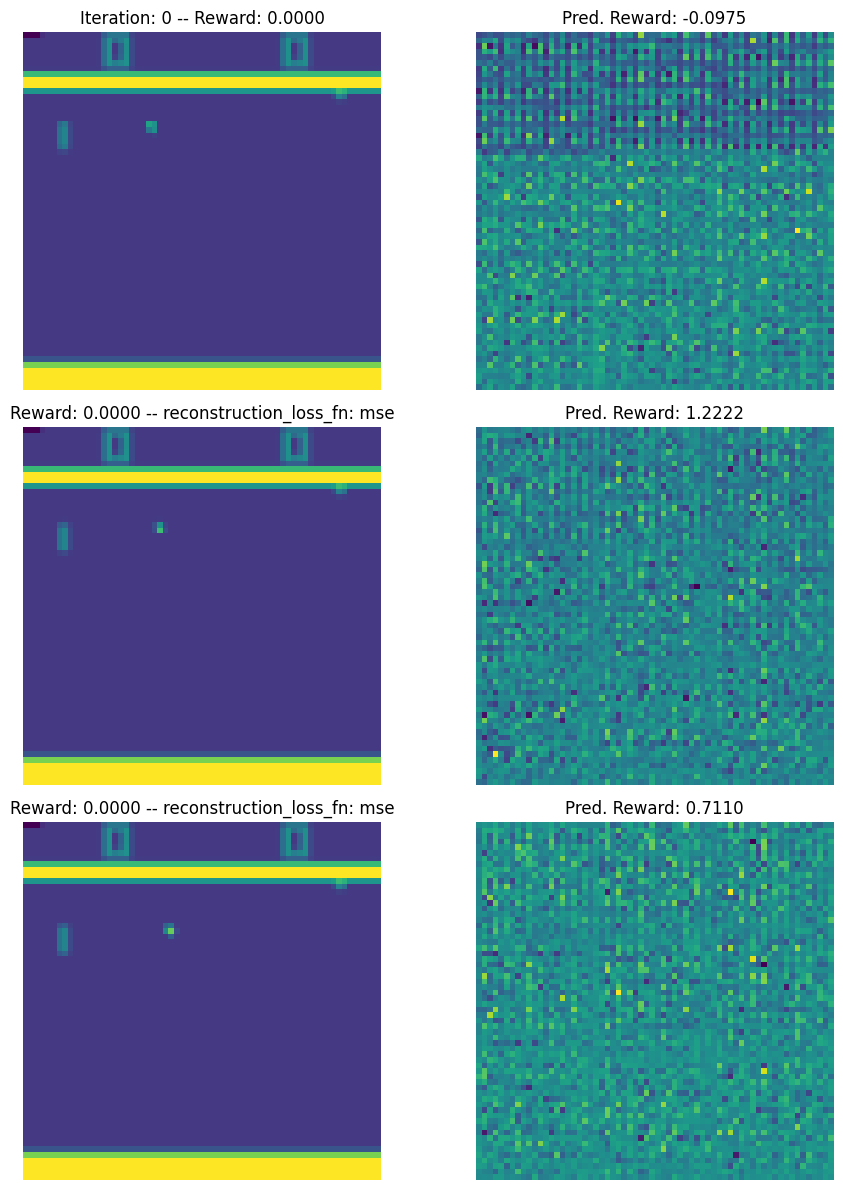

Epoch 1/10:   0%|          | 1/500 [00:02<22:12,  2.67s/it, Total Loss=1.5095, Recon=0.5241, KL=0.0117, Reward=0.9736]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   0%|          | 2/500 [00:03<10:47,  1.30s/it, Total Loss=1.1064, Recon=0.3867, KL=0.0724, Reward=0.6474]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   1%|          | 3/500 [00:03<07:07,  1.16it/s, Total Loss=0.5447, Recon=0.2498, KL=0.0115, Reward=0.2833]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   1%|          | 4/500 [00:03<05:25,  1.53it/s, Total Loss=0.4736, Recon=0.2948, KL=0.0545, Reward=0.1244]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   1%|          | 6/500 [00:04<03:25,  2.40it/s, Total Loss=0.3618, Recon=0.1740, KL=0.0273, Reward=0.1605]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   2%|▏         | 8/500 [00:04<02:38,  3.10it/s, Total Loss=0.4725, Recon=0.2461, KL=0.0835, Reward=0.1429]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   2%|▏         | 9/500 [00:04<02:16,  3.59it/s, Total Loss=0.5471, Recon=0.2475, KL=0.0735, Reward=0.2261]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   2%|▏         | 11/500 [00:05<02:09,  3.77it/s, Total Loss=0.4683, Recon=0.1547, KL=0.0513, Reward=0.2623]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   3%|▎         | 13/500 [00:05<01:48,  4.49it/s, Total Loss=0.7095, Recon=0.2311, KL=0.0487, Reward=0.4297]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   3%|▎         | 15/500 [00:06<01:53,  4.28it/s, Total Loss=0.5410, Recon=0.1696, KL=0.0515, Reward=0.3199]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   3%|▎         | 17/500 [00:06<01:42,  4.70it/s, Total Loss=0.9044, Recon=0.2192, KL=0.0174, Reward=0.6679]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])
shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   4%|▎         | 18/500 [00:06<01:39,  4.86it/s, Total Loss=0.5137, Recon=0.1833, KL=0.0199, Reward=0.3106]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


Epoch 1/10:   4%|▍         | 19/500 [00:07<03:07,  2.57it/s, Total Loss=0.1922, Recon=0.1277, KL=0.0162, Reward=0.0482]

shape of imgs beginning of train torch.Size([1, 16, 50, 64, 64, 3])
shape of imgs after squeeze in train method torch.Size([16, 50, 64, 64, 3])
shape received by train_batch torch.Size([16, 50, 64, 64, 3])


KeyboardInterrupt: 

In [ ]:
atari_trainer.train(num_epochs=10)

In [ ]:
def get_new_atari_trainer():
    encoder_new = EncoderCNN(
        in_channels=3,
        embedding_dim=encoder_embedding_dim,
        input_shape=(image_height, image_width)
    ).to(device)
    decoder_new = DecoderCNN(
        hidden_size=hidden_size,
        state_size=state_size,
        embedding_size=encoder_embedding_dim,
        use_bn=True,
        output_shape=(3, image_height, image_width)
    ).to(device)
    reward_model_new = RewardModel(hidden_size, state_size).to(device)
    dynamics_model_new = DynamicsModel(
        hidden_dim=hidden_size,
        action_dim=action_dim,
        state_dim=state_size,
        embedding_dim=encoder_embedding_dim
    ).to(device)
    rssm_new = RSSM(
        encoder_new,
        decoder_new,
        reward_model_new,
        dynamics_model_new,
        hidden_size,
        state_size,
        action_dim,
        encoder_embedding_dim,
        device=device
    )
    optimizer_new = torch.optim.Adam(rssm_new.parameters(), lr=3e-4, weight_decay=1e-5)
    atari_trainer_new = AtariTrainer(
        rssm=rssm_new,
        dataloader=dataloader,
        optimizer=optimizer_new,
        device=device,
    )
    return atari_trainer_new

Epoch 1/10:   0%|          | 0/500 [00:00<?, ?it/s]

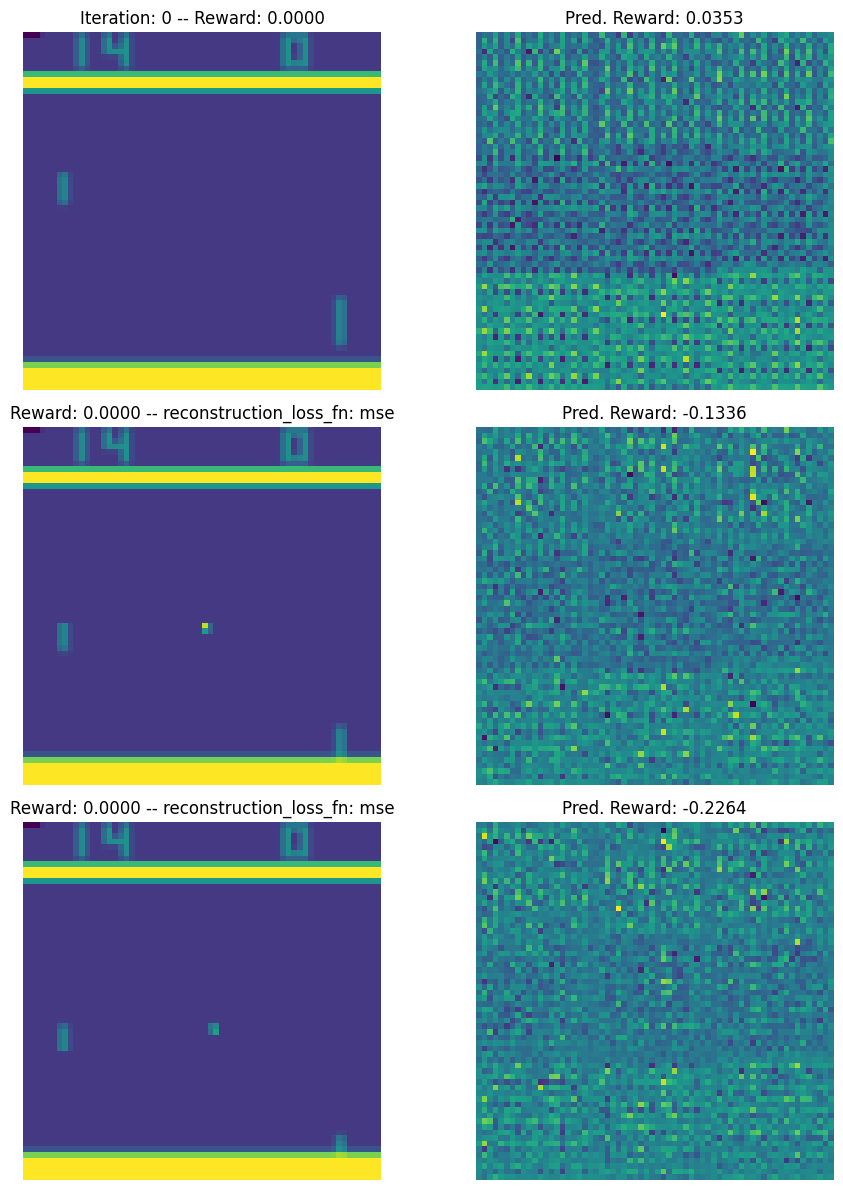

Epoch 1/10:  20%|██        | 100/500 [00:24<01:17,  5.15it/s, Total Loss=0.1410, Recon=0.0669, KL=0.0033, Reward=0.0708]

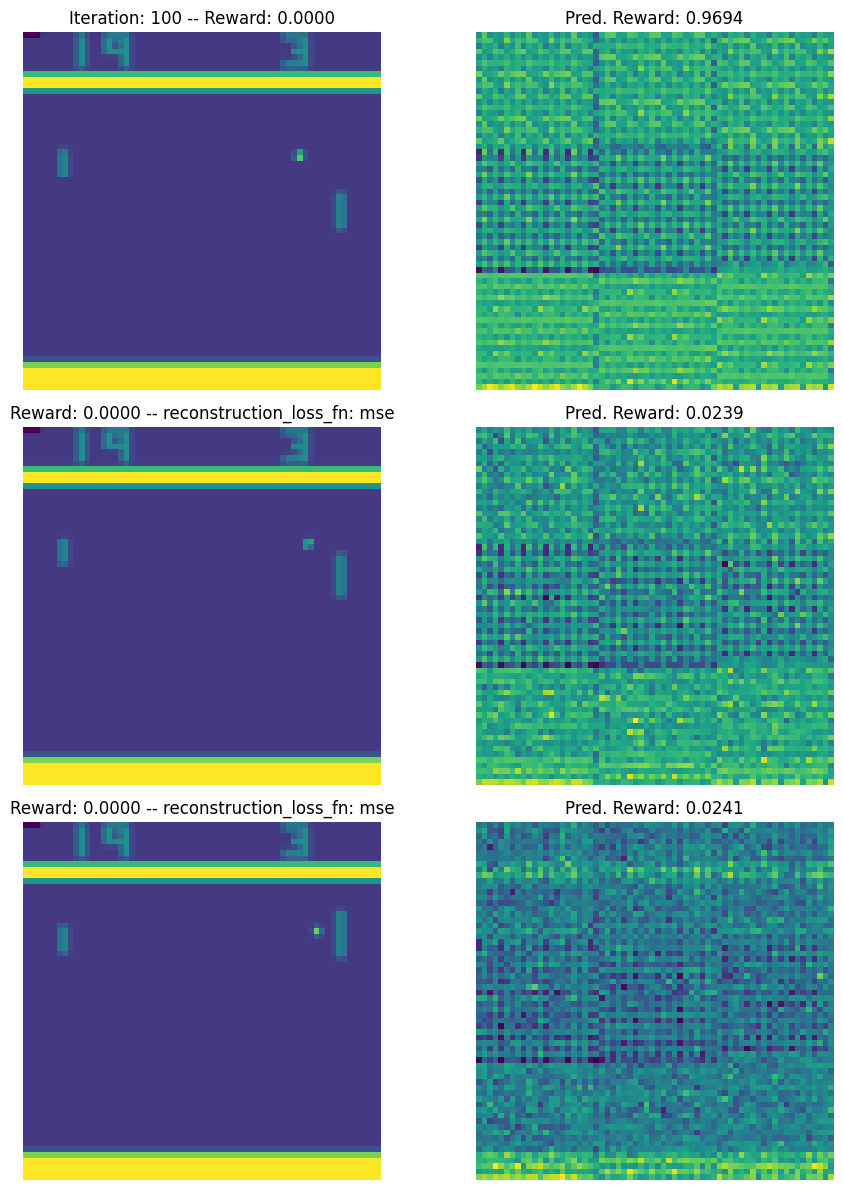

Epoch 1/10:  40%|████      | 200/500 [00:45<01:00,  5.00it/s, Total Loss=0.0829, Recon=0.0636, KL=0.0000, Reward=0.0193]

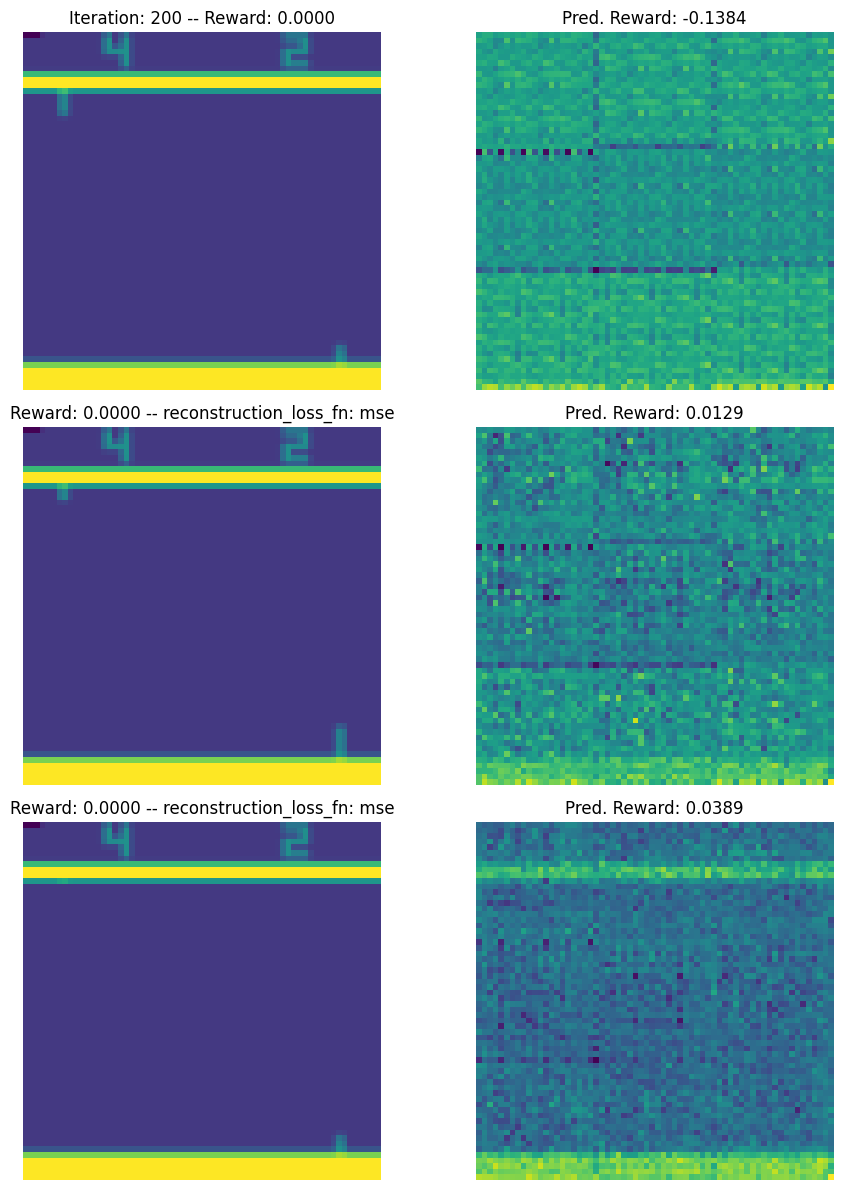

Epoch 1/10:  60%|██████    | 300/500 [01:05<00:38,  5.24it/s, Total Loss=0.0756, Recon=0.0504, KL=0.0000, Reward=0.0252]

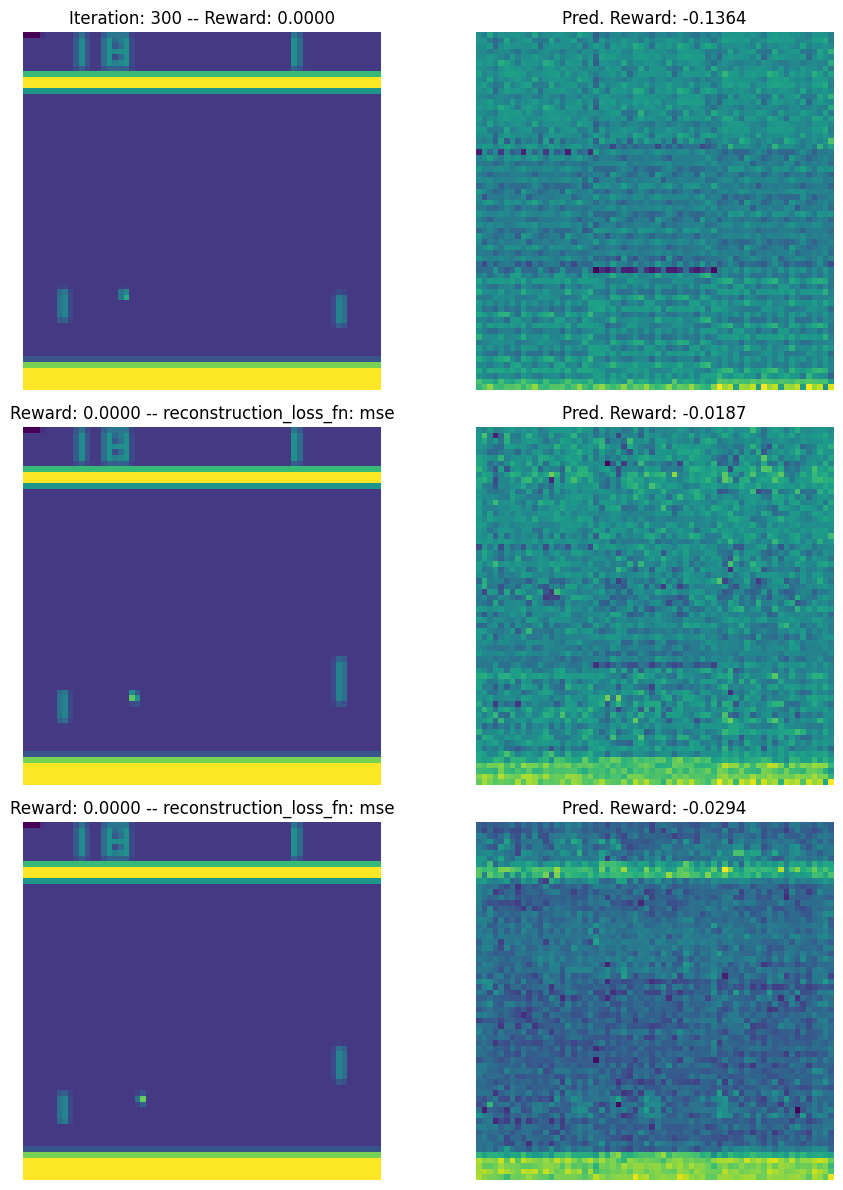

Epoch 1/10:  80%|████████  | 400/500 [01:25<00:18,  5.31it/s, Total Loss=0.0660, Recon=0.0412, KL=0.0000, Reward=0.0248]

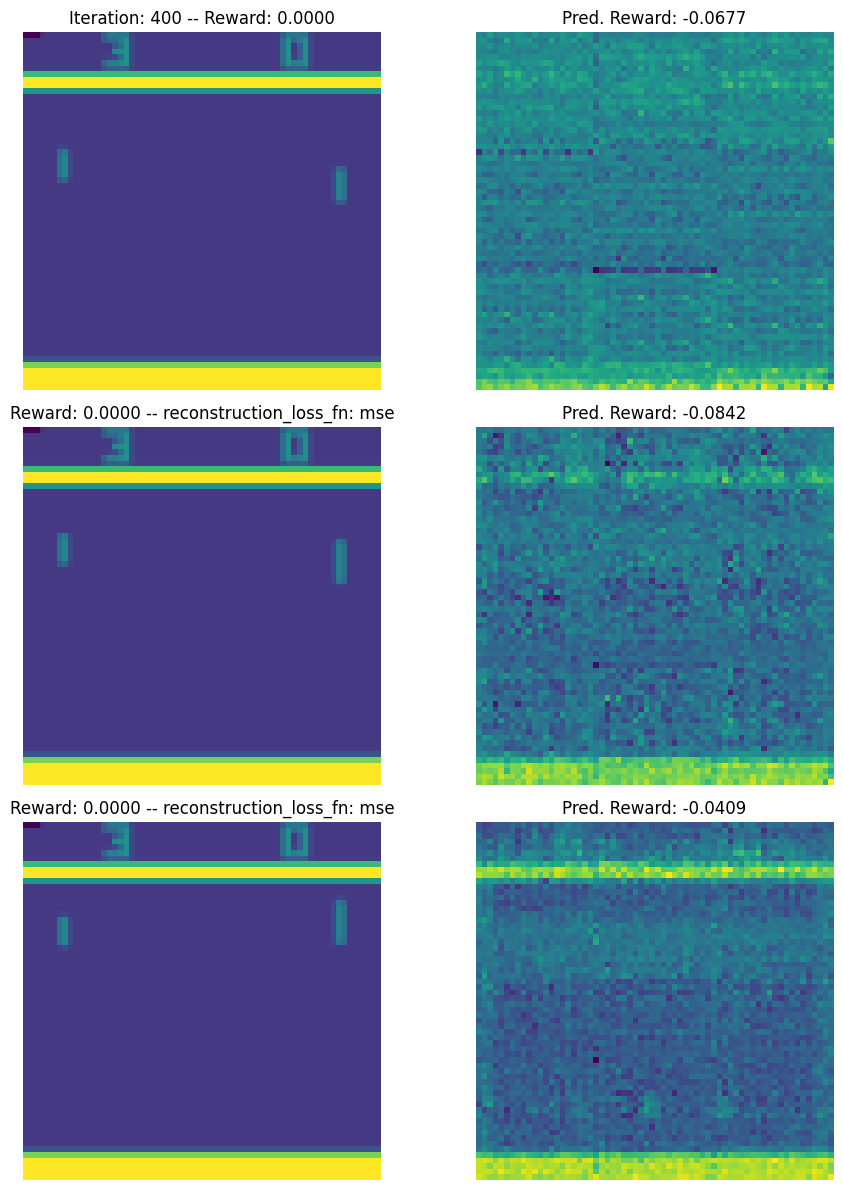

Epoch 1/10: 100%|██████████| 500/500 [01:45<00:00,  4.75it/s, Total Loss=0.0489, Recon=0.0278, KL=0.0000, Reward=0.0211]


Epoch 1 completed. Average loss: 0.0979


Epoch 2/10:   0%|          | 0/500 [00:00<?, ?it/s]

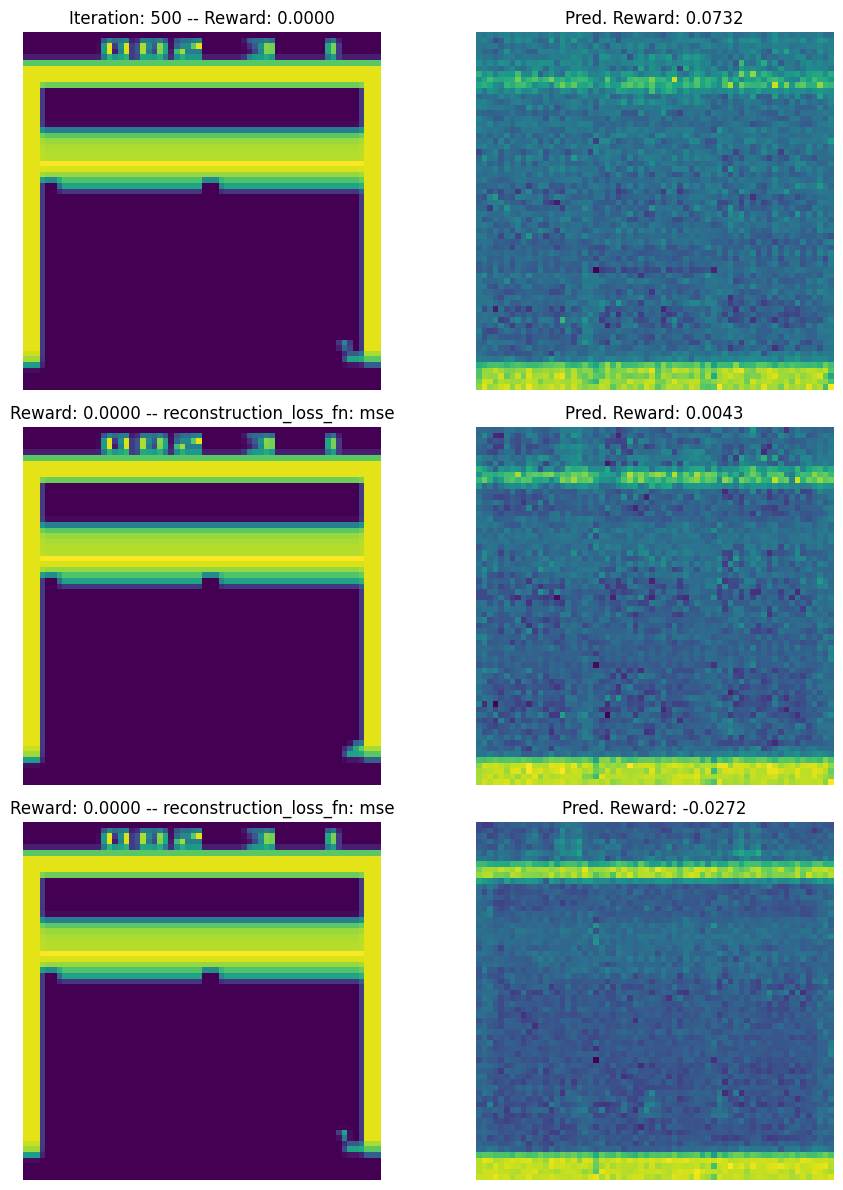

Epoch 2/10:  20%|██        | 100/500 [00:19<01:16,  5.21it/s, Total Loss=0.0753, Recon=0.0520, KL=0.0000, Reward=0.0234]

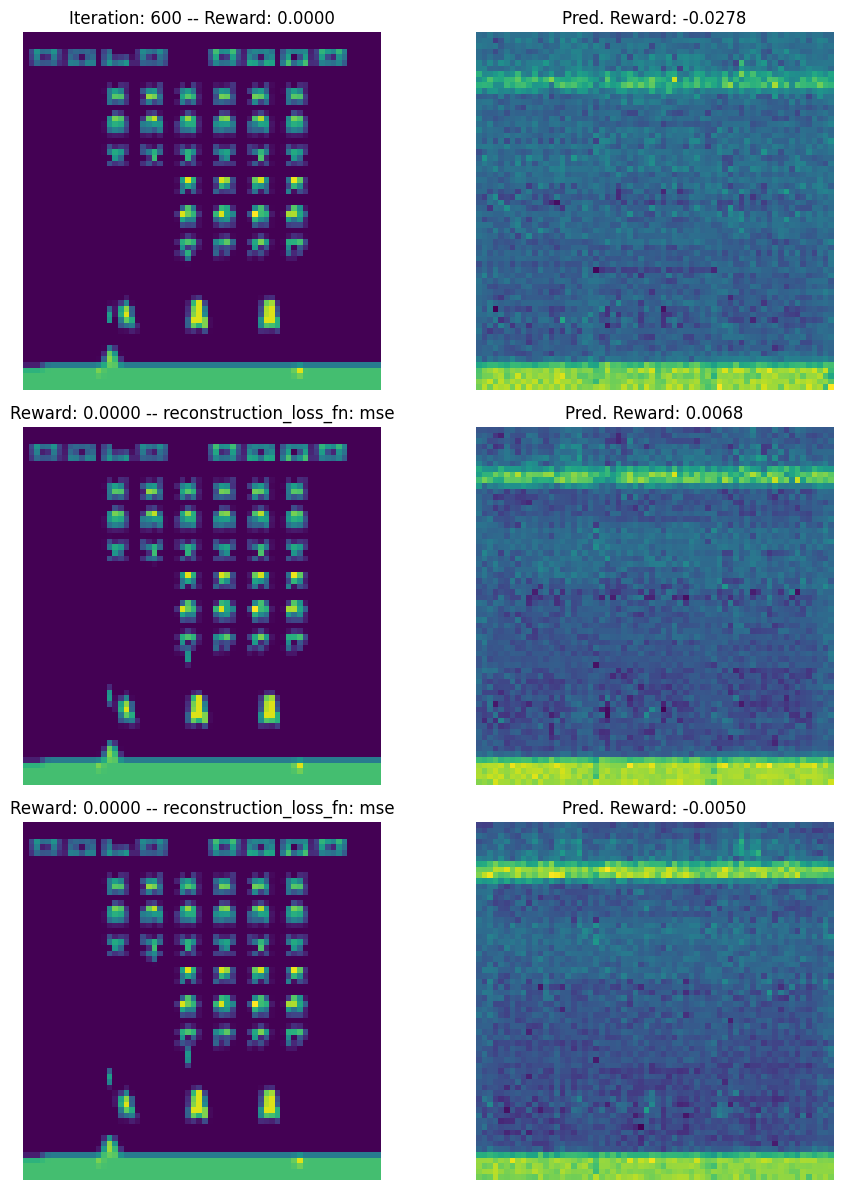

Epoch 2/10:  40%|████      | 200/500 [00:38<00:57,  5.25it/s, Total Loss=0.0936, Recon=0.0751, KL=0.0000, Reward=0.0186]

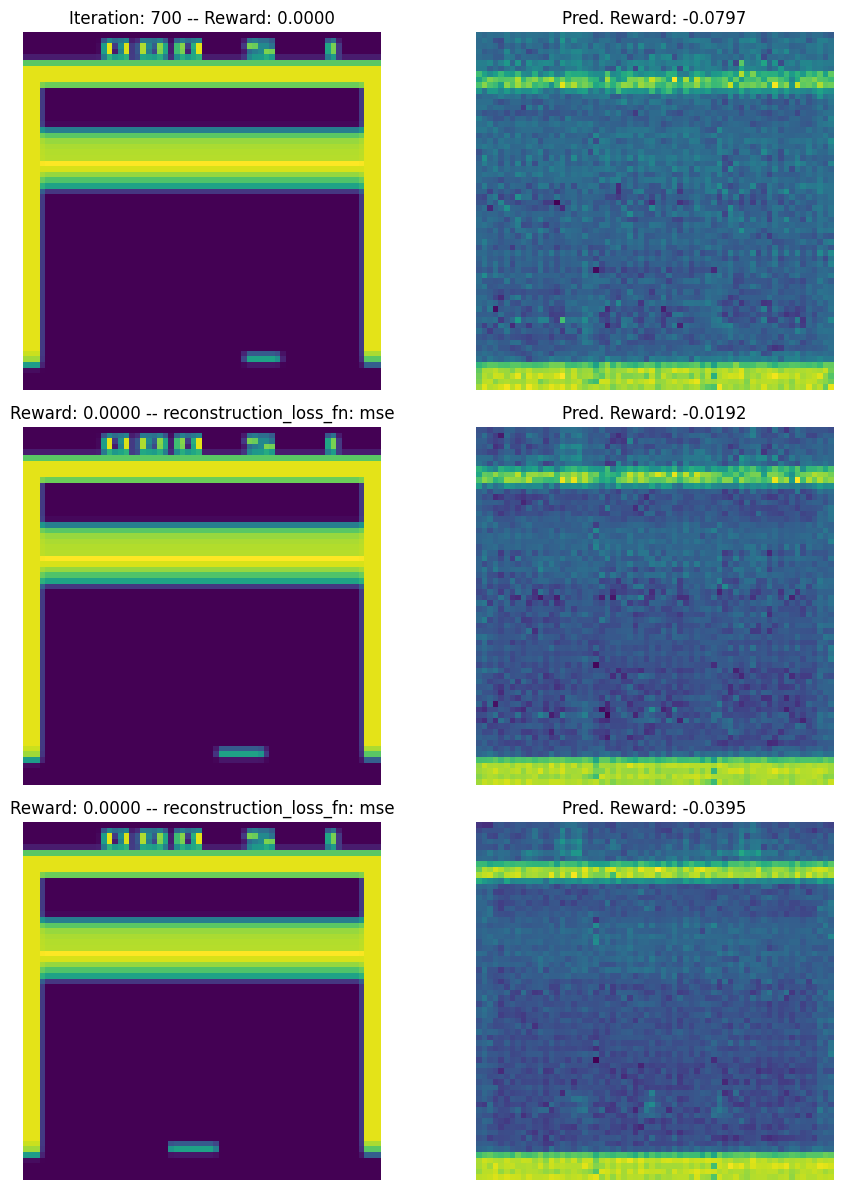

Epoch 2/10:  60%|██████    | 300/500 [00:58<00:38,  5.24it/s, Total Loss=0.0587, Recon=0.0414, KL=0.0000, Reward=0.0173]

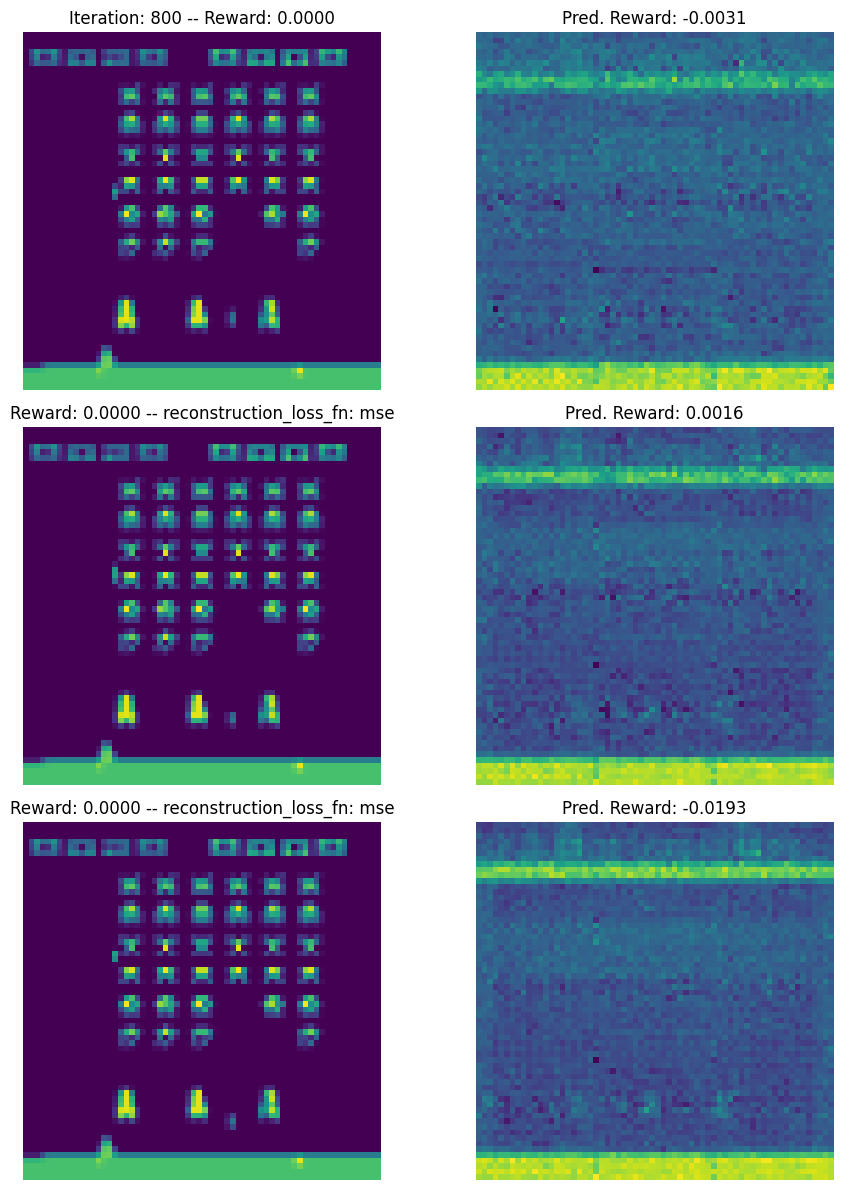

Epoch 2/10:  80%|████████  | 400/500 [01:17<00:18,  5.30it/s, Total Loss=0.0684, Recon=0.0545, KL=0.0000, Reward=0.0138]

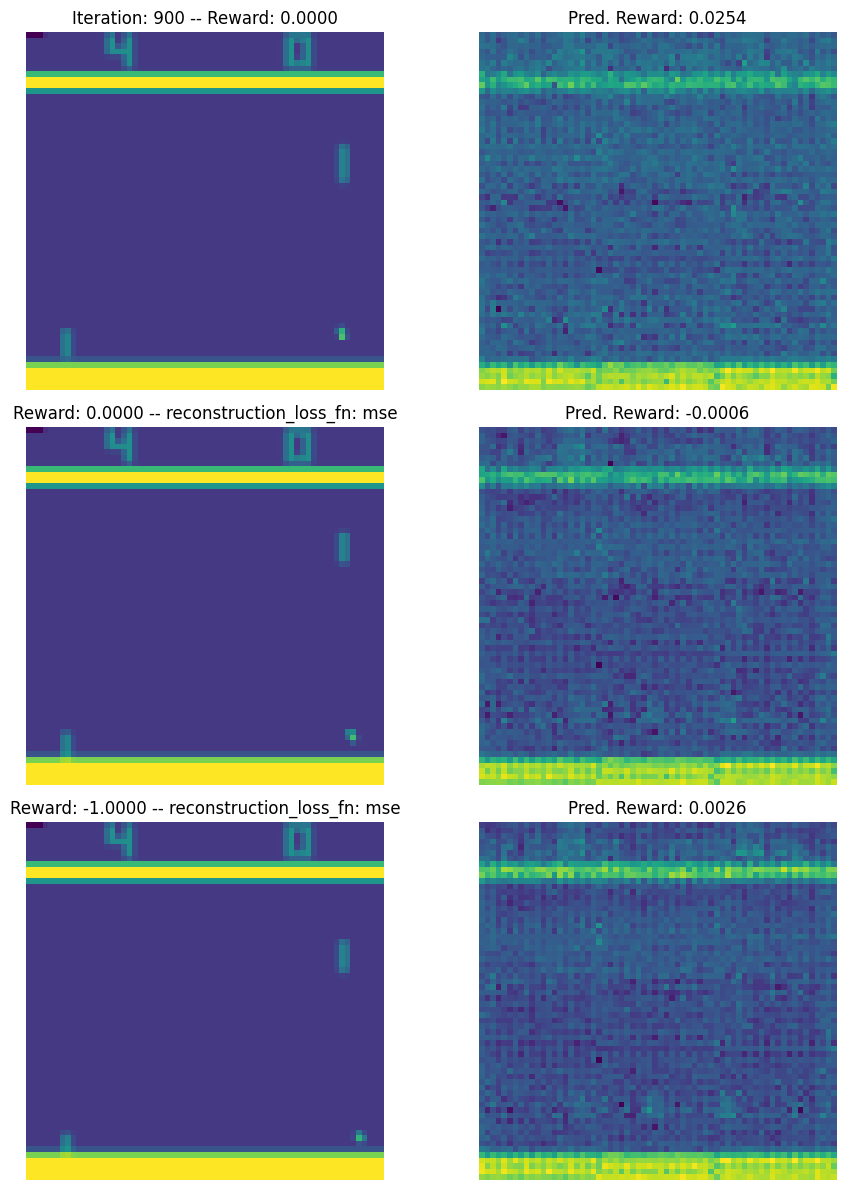

Epoch 2/10: 100%|██████████| 500/500 [01:37<00:00,  5.14it/s, Total Loss=0.0506, Recon=0.0282, KL=0.0000, Reward=0.0224]


Epoch 2 completed. Average loss: 0.0628


Epoch 3/10:   0%|          | 0/500 [00:00<?, ?it/s]

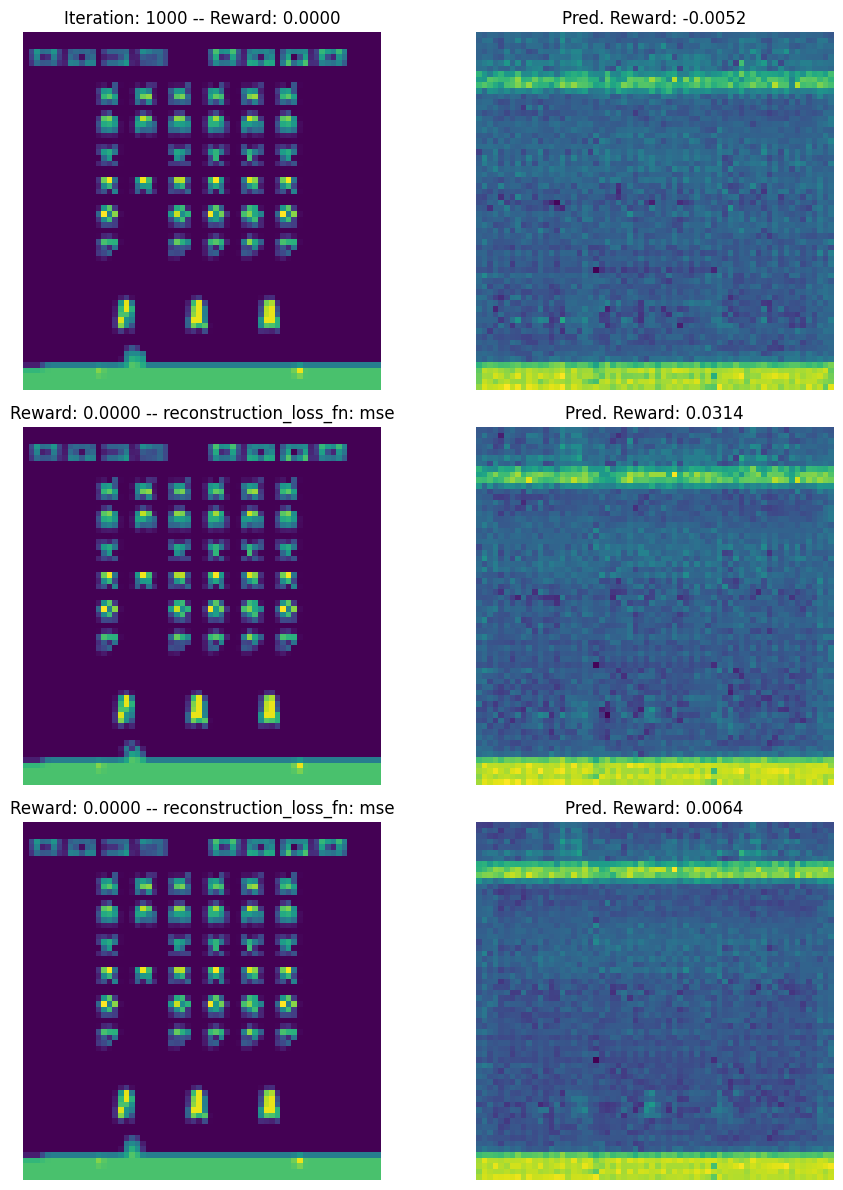

Epoch 3/10:  20%|██        | 100/500 [00:19<01:16,  5.25it/s, Total Loss=0.0446, Recon=0.0214, KL=0.0000, Reward=0.0232]

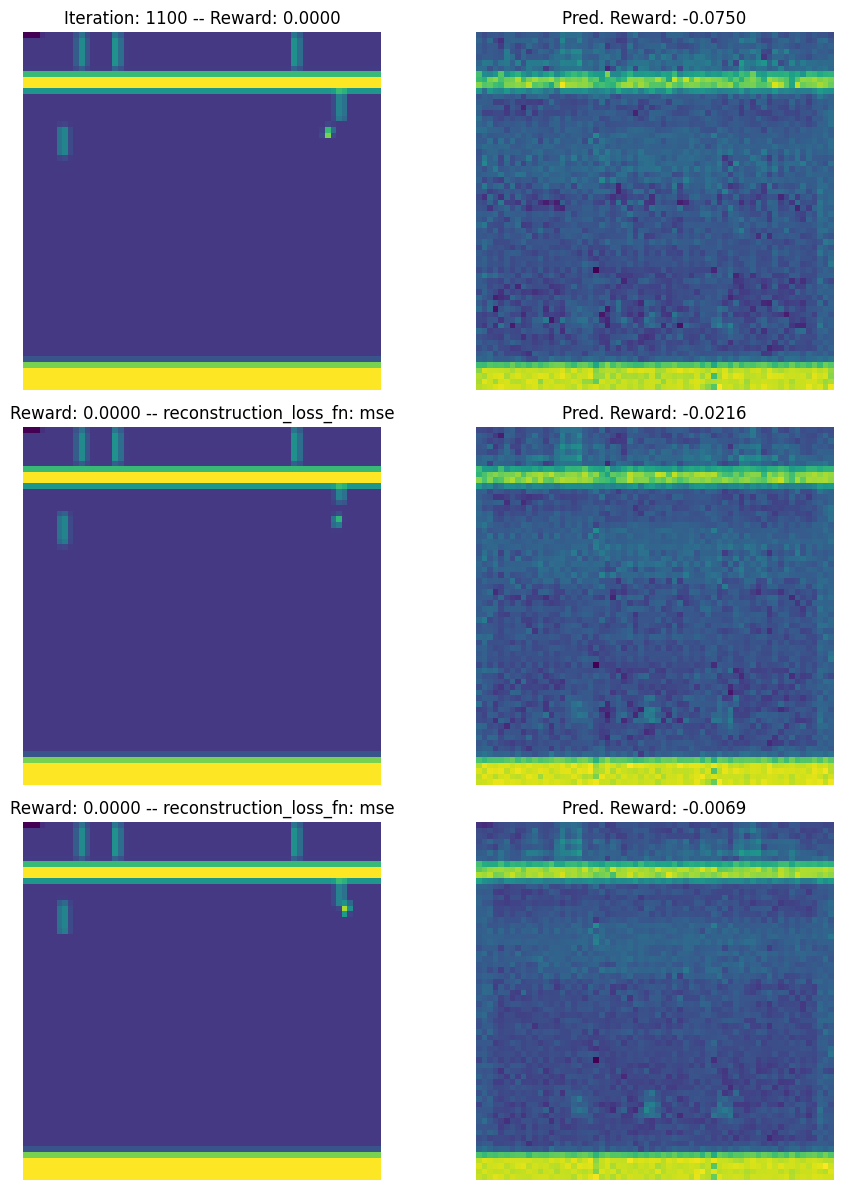

Epoch 3/10:  40%|████      | 200/500 [00:39<00:58,  5.15it/s, Total Loss=0.0821, Recon=0.0639, KL=0.0000, Reward=0.0182]

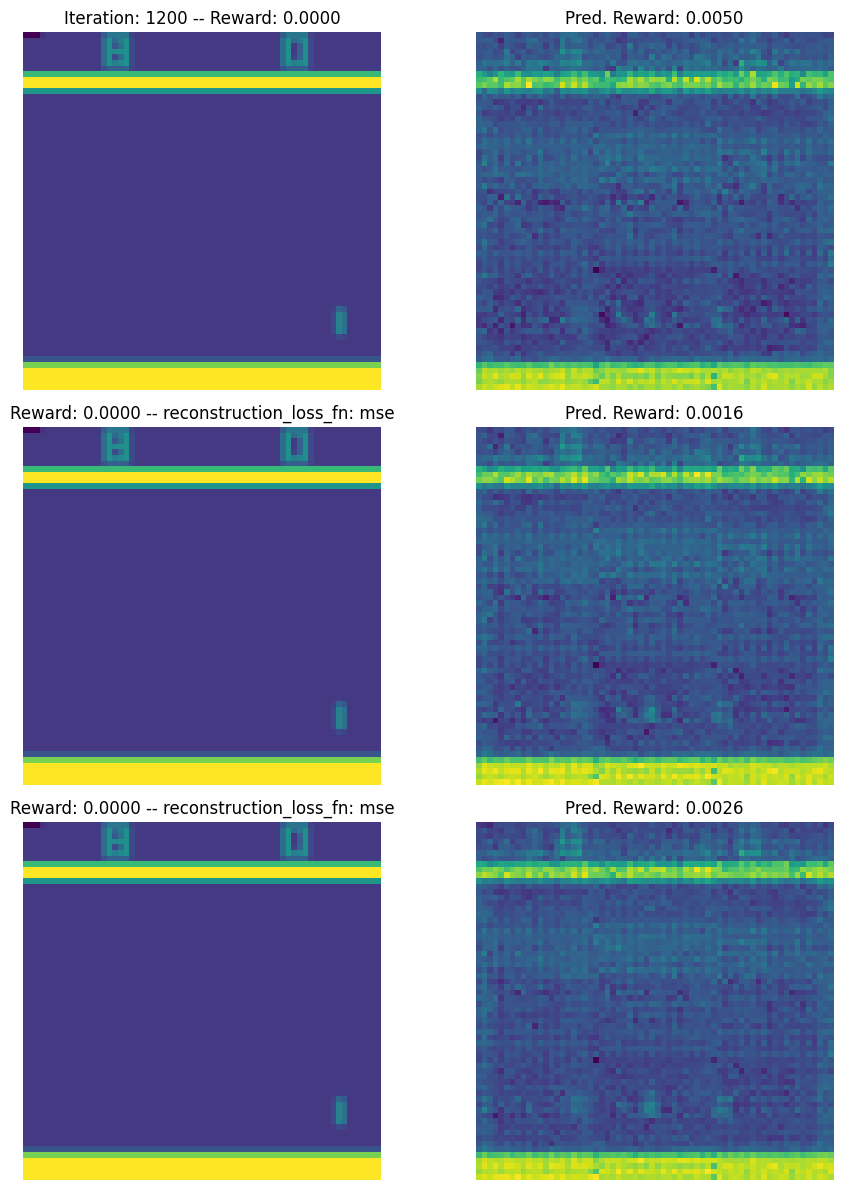

Epoch 3/10:  60%|██████    | 300/500 [00:59<00:38,  5.23it/s, Total Loss=0.0585, Recon=0.0473, KL=0.0000, Reward=0.0113]

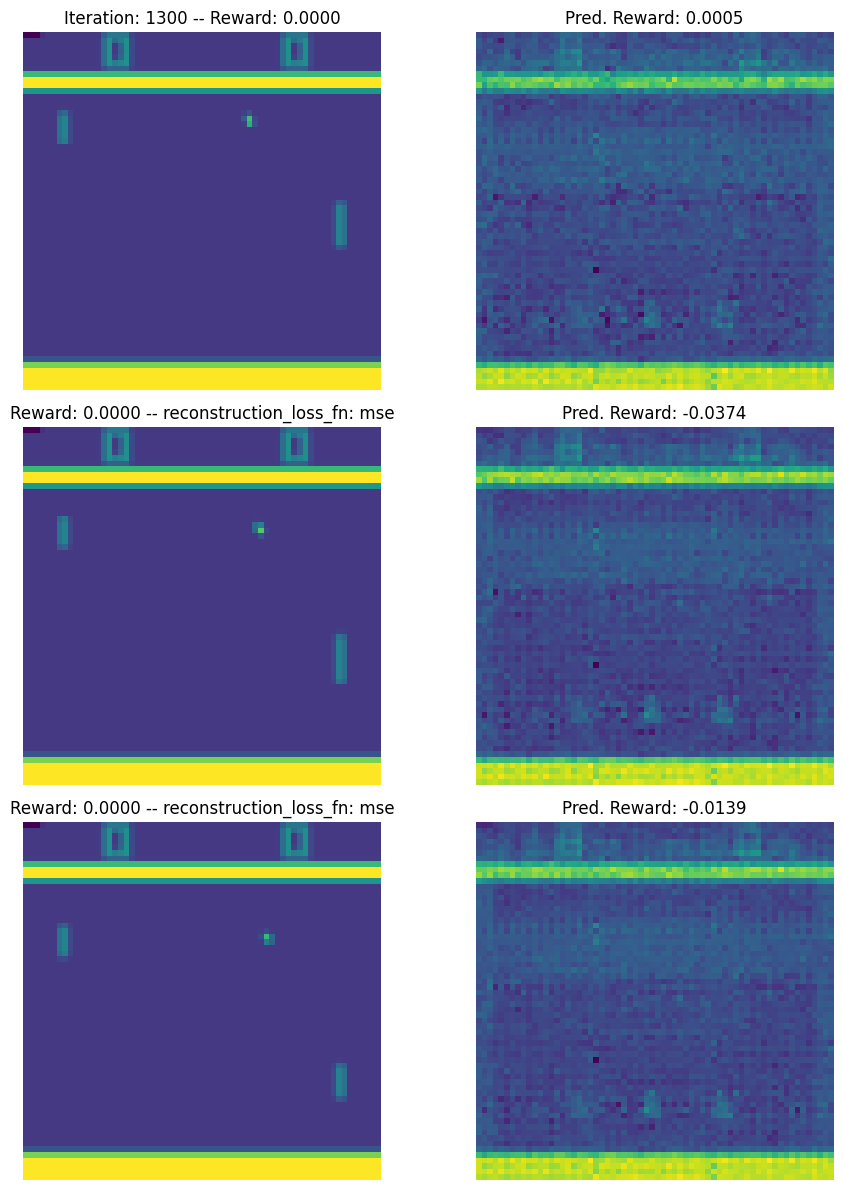

Epoch 3/10:  80%|████████  | 400/500 [01:19<00:19,  5.13it/s, Total Loss=0.1036, Recon=0.0808, KL=0.0000, Reward=0.0227]

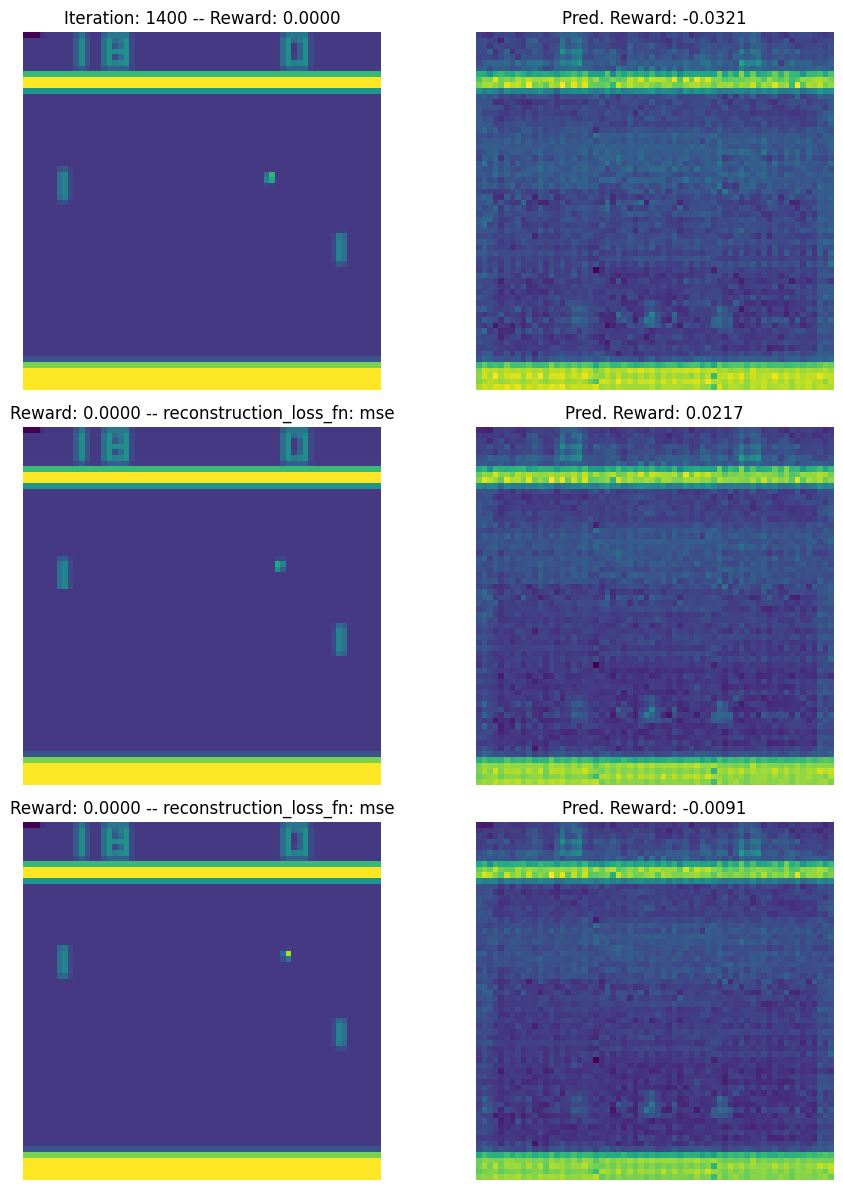

Epoch 3/10: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s, Total Loss=0.0663, Recon=0.0463, KL=0.0000, Reward=0.0200]


Epoch 3 completed. Average loss: 0.0619


Epoch 4/10:   0%|          | 0/500 [00:00<?, ?it/s]

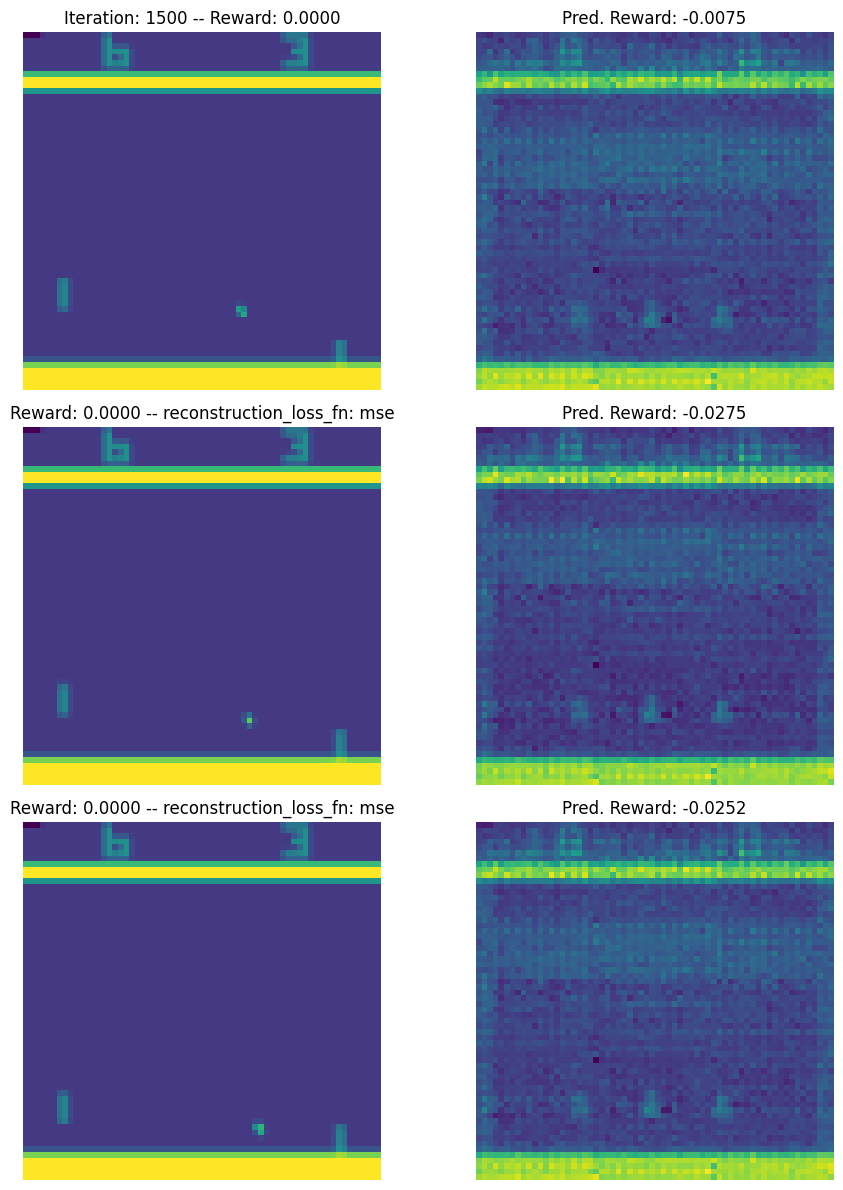

Epoch 4/10:  20%|██        | 100/500 [00:19<01:16,  5.22it/s, Total Loss=0.0612, Recon=0.0459, KL=0.0000, Reward=0.0152]

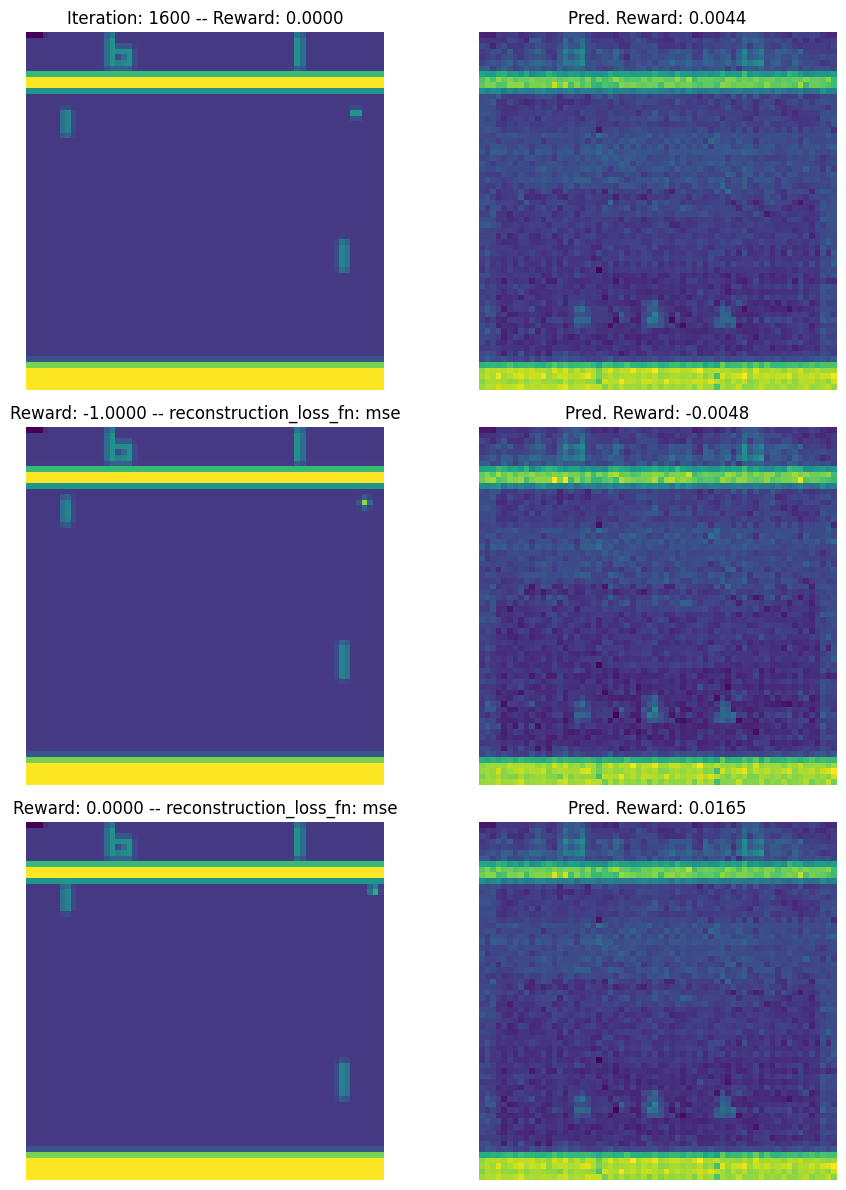

Epoch 4/10:  40%|████      | 200/500 [00:39<00:57,  5.21it/s, Total Loss=0.0426, Recon=0.0251, KL=0.0000, Reward=0.0175]

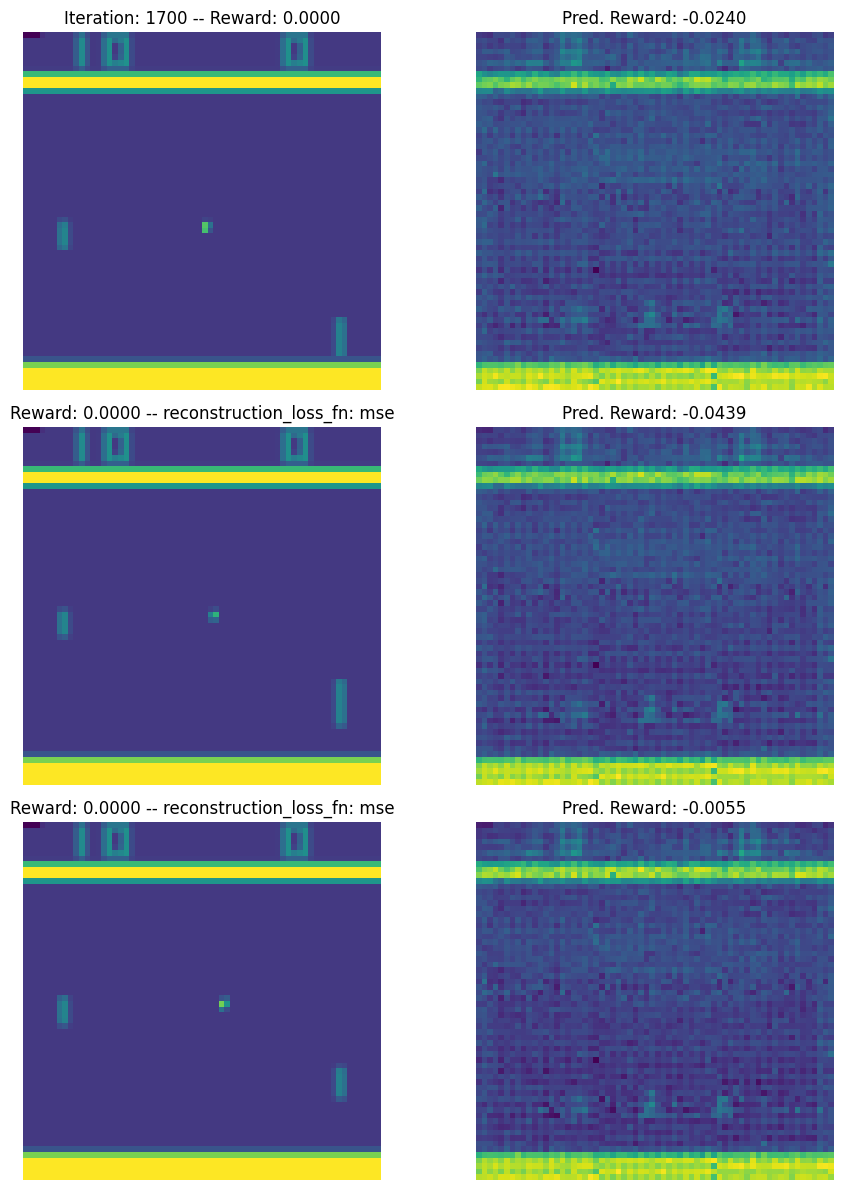

Epoch 4/10:  60%|██████    | 300/500 [00:59<00:38,  5.18it/s, Total Loss=0.0742, Recon=0.0511, KL=0.0000, Reward=0.0230]

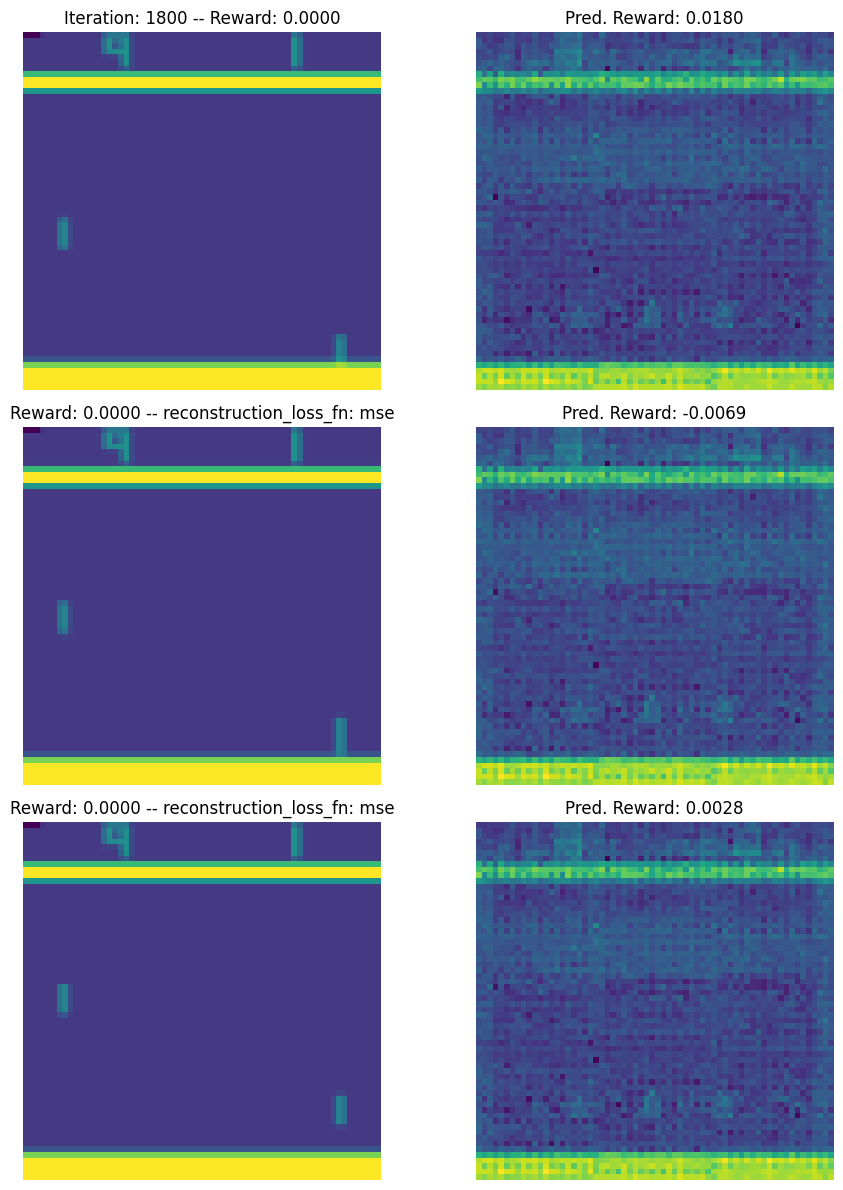

Epoch 4/10:  80%|████████  | 400/500 [01:18<00:19,  5.23it/s, Total Loss=0.1067, Recon=0.0795, KL=0.0000, Reward=0.0272]

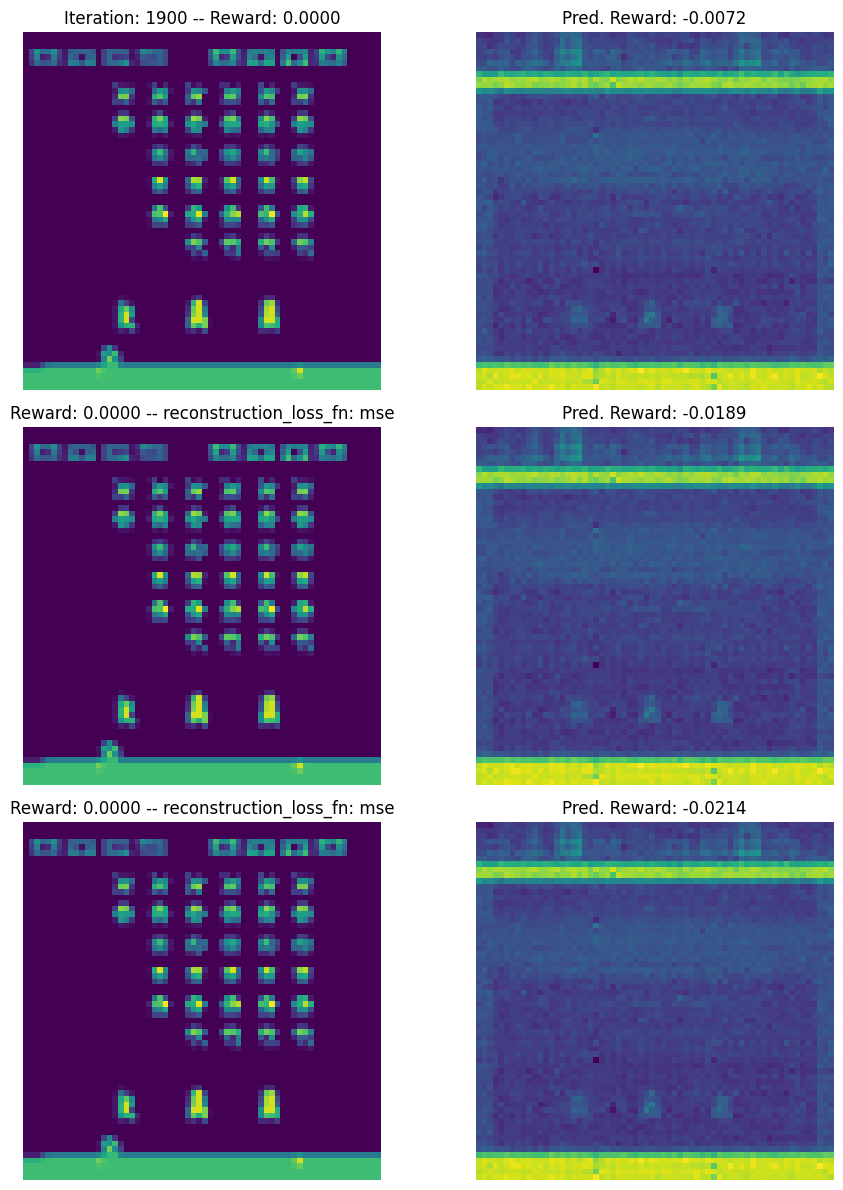

Epoch 4/10: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s, Total Loss=0.0645, Recon=0.0544, KL=0.0000, Reward=0.0100]


Epoch 4 completed. Average loss: 0.0616


Epoch 5/10:   0%|          | 0/500 [00:00<?, ?it/s]

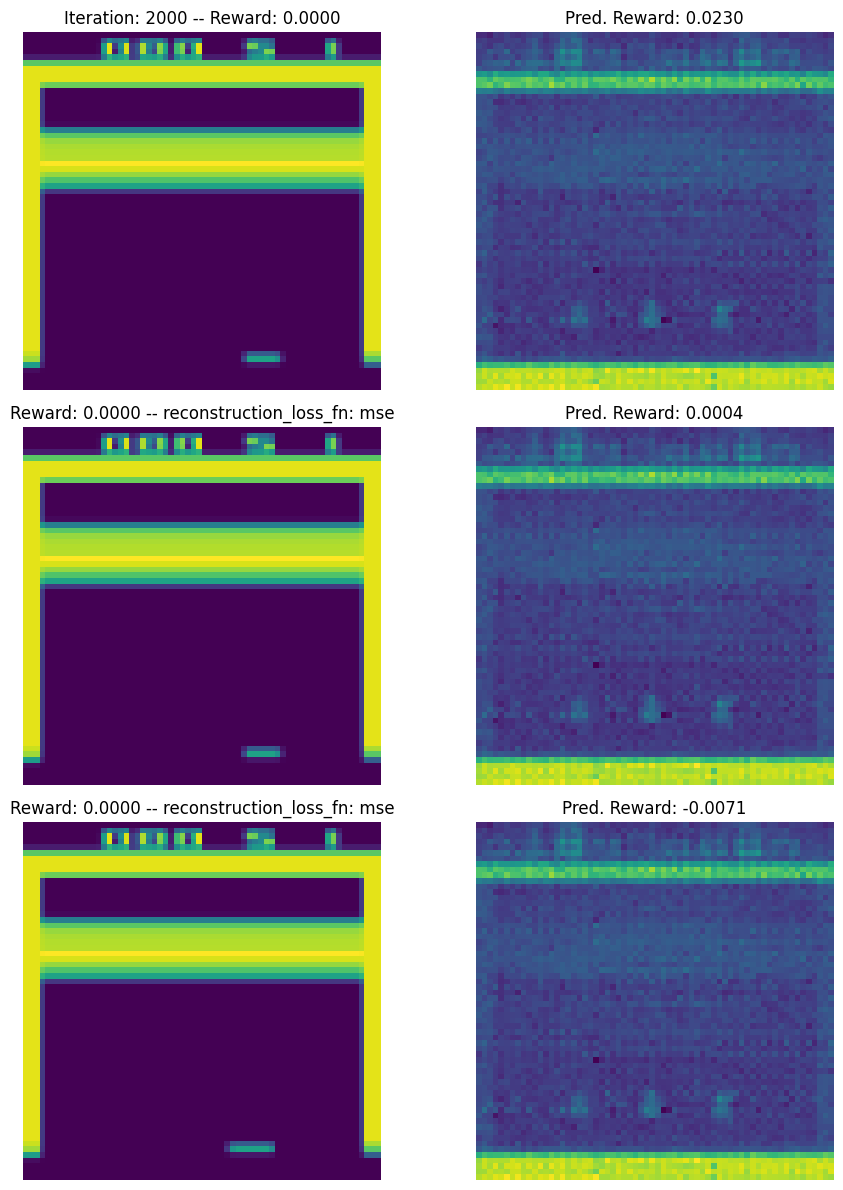

Epoch 5/10:  20%|██        | 100/500 [00:19<01:16,  5.21it/s, Total Loss=0.0970, Recon=0.0756, KL=0.0000, Reward=0.0215]

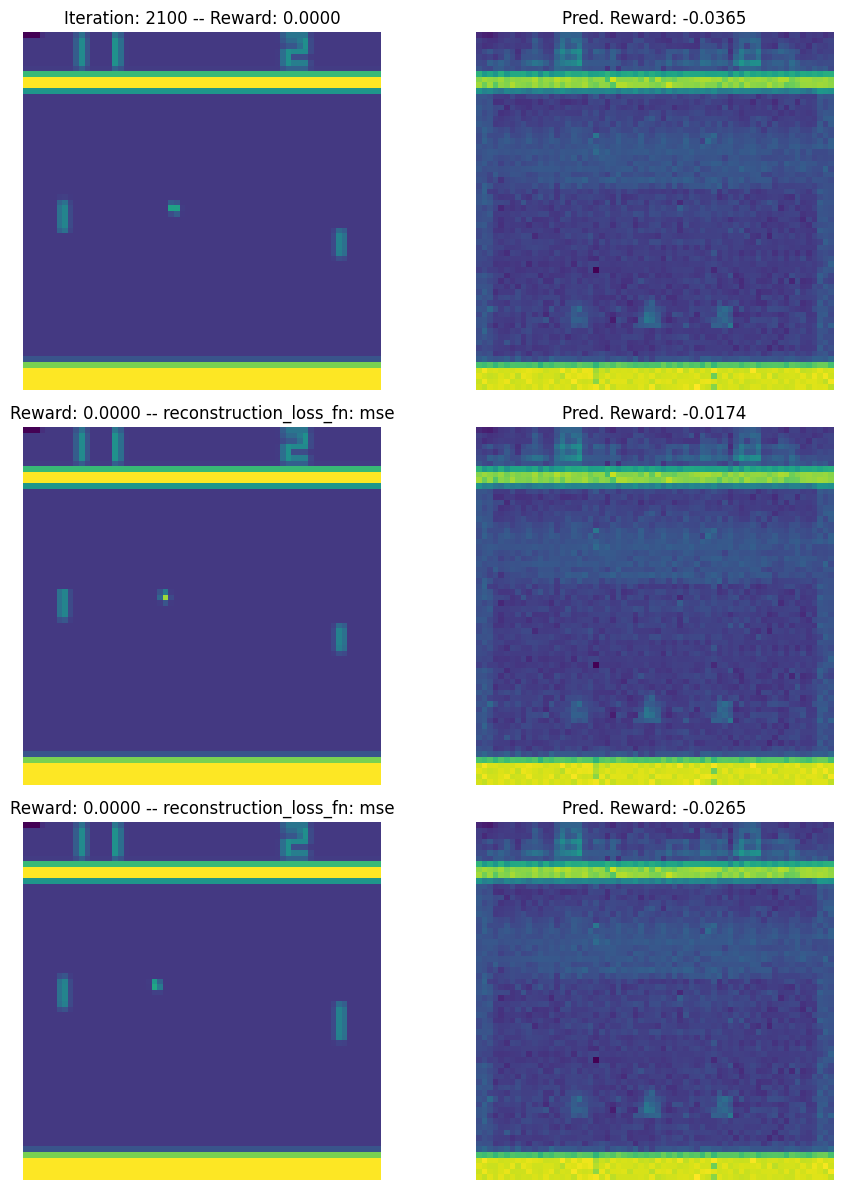

Epoch 5/10:  40%|████      | 200/500 [00:39<00:57,  5.24it/s, Total Loss=0.0397, Recon=0.0259, KL=0.0000, Reward=0.0138]

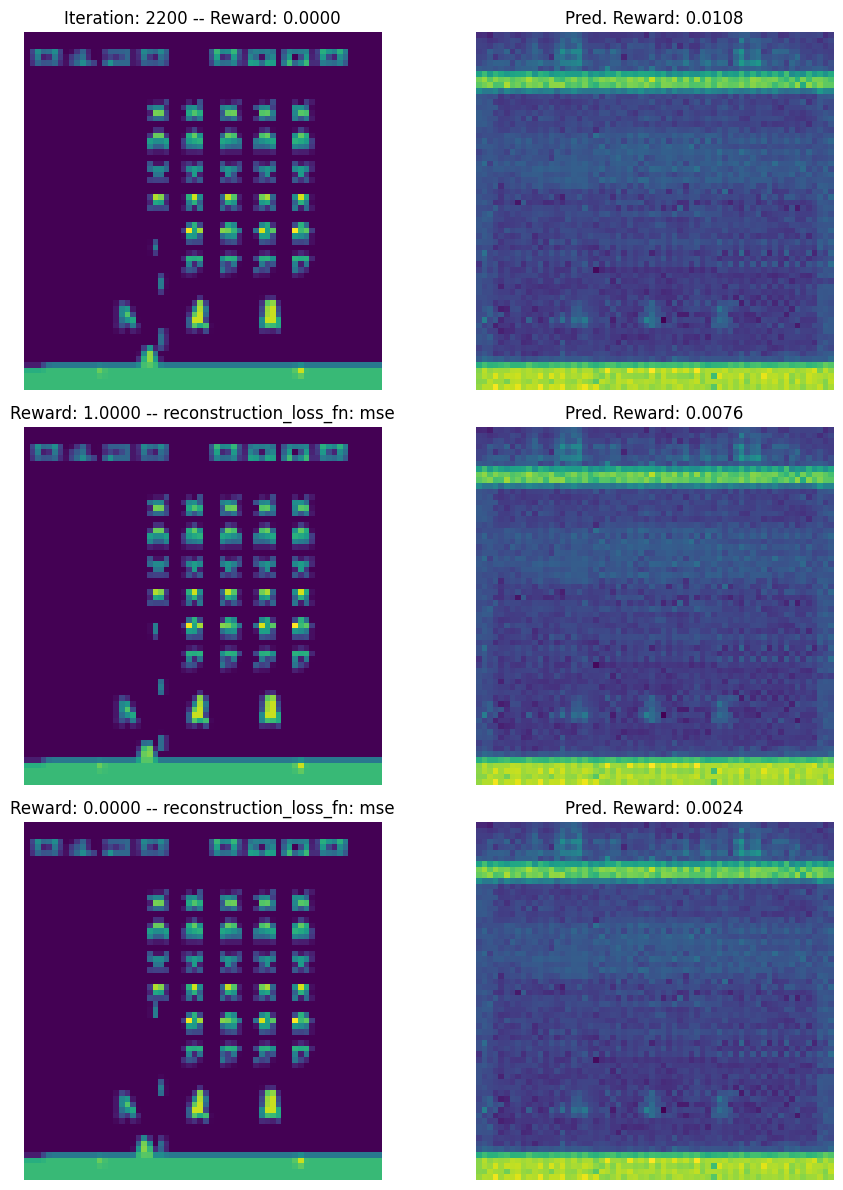

Epoch 5/10:  60%|██████    | 300/500 [00:59<00:38,  5.13it/s, Total Loss=0.0846, Recon=0.0622, KL=0.0000, Reward=0.0223]

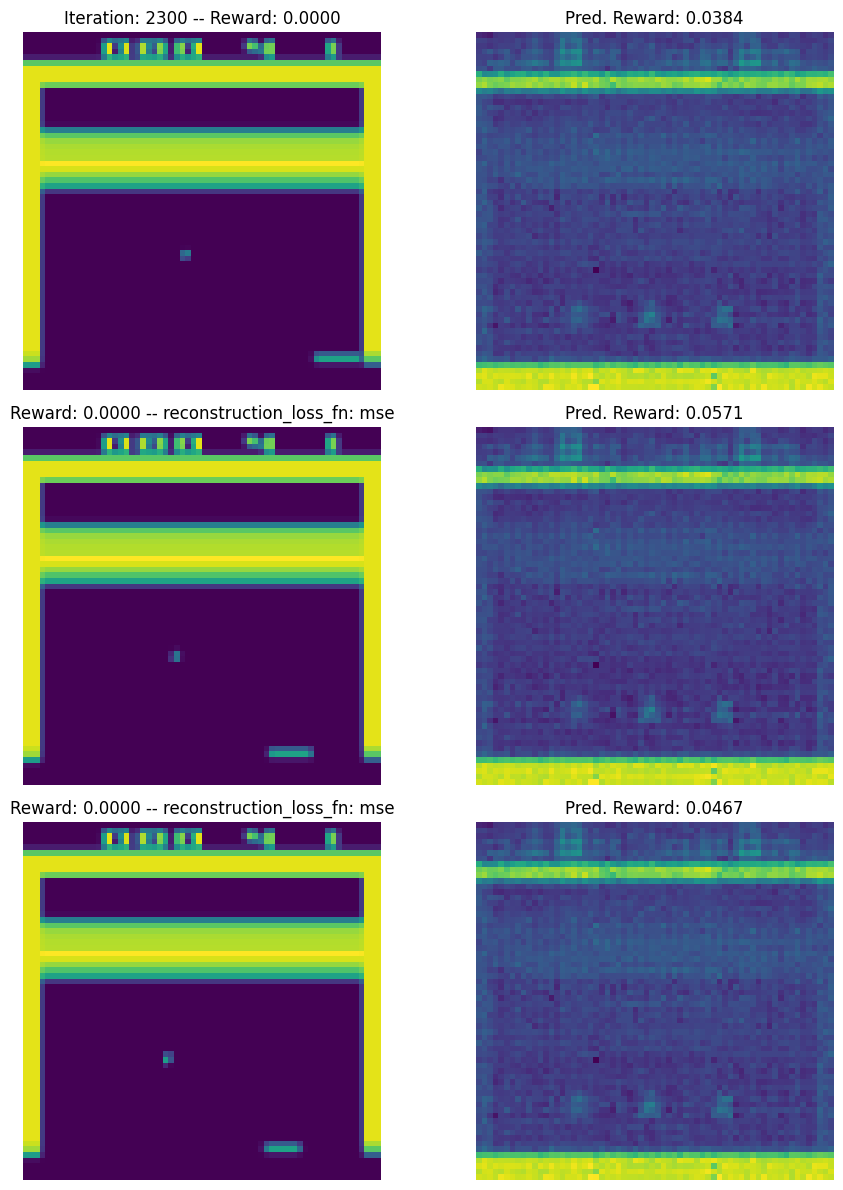

Epoch 5/10:  80%|████████  | 400/500 [01:19<00:19,  5.11it/s, Total Loss=0.0784, Recon=0.0688, KL=0.0000, Reward=0.0096]

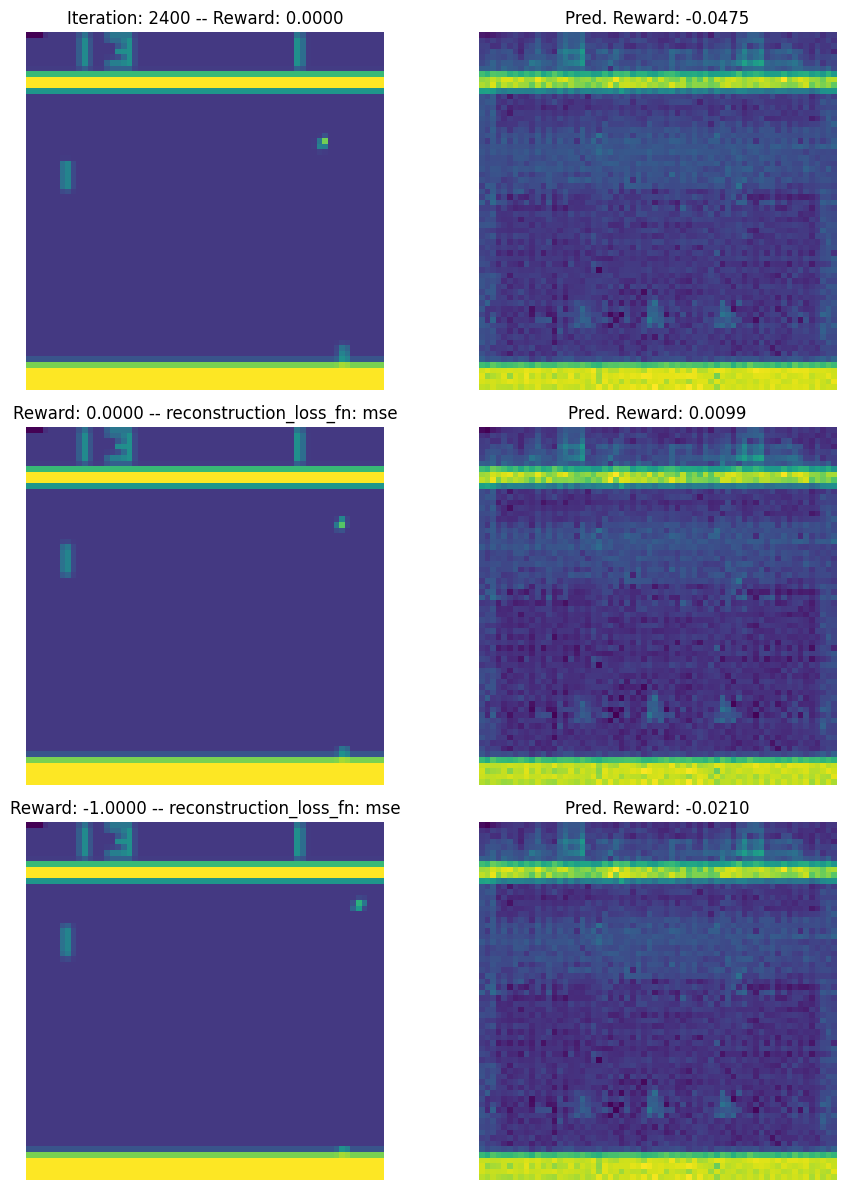

Epoch 5/10: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s, Total Loss=0.0716, Recon=0.0530, KL=0.0000, Reward=0.0186]


Epoch 5 completed. Average loss: 0.0618


Epoch 6/10:   0%|          | 0/500 [00:00<?, ?it/s]

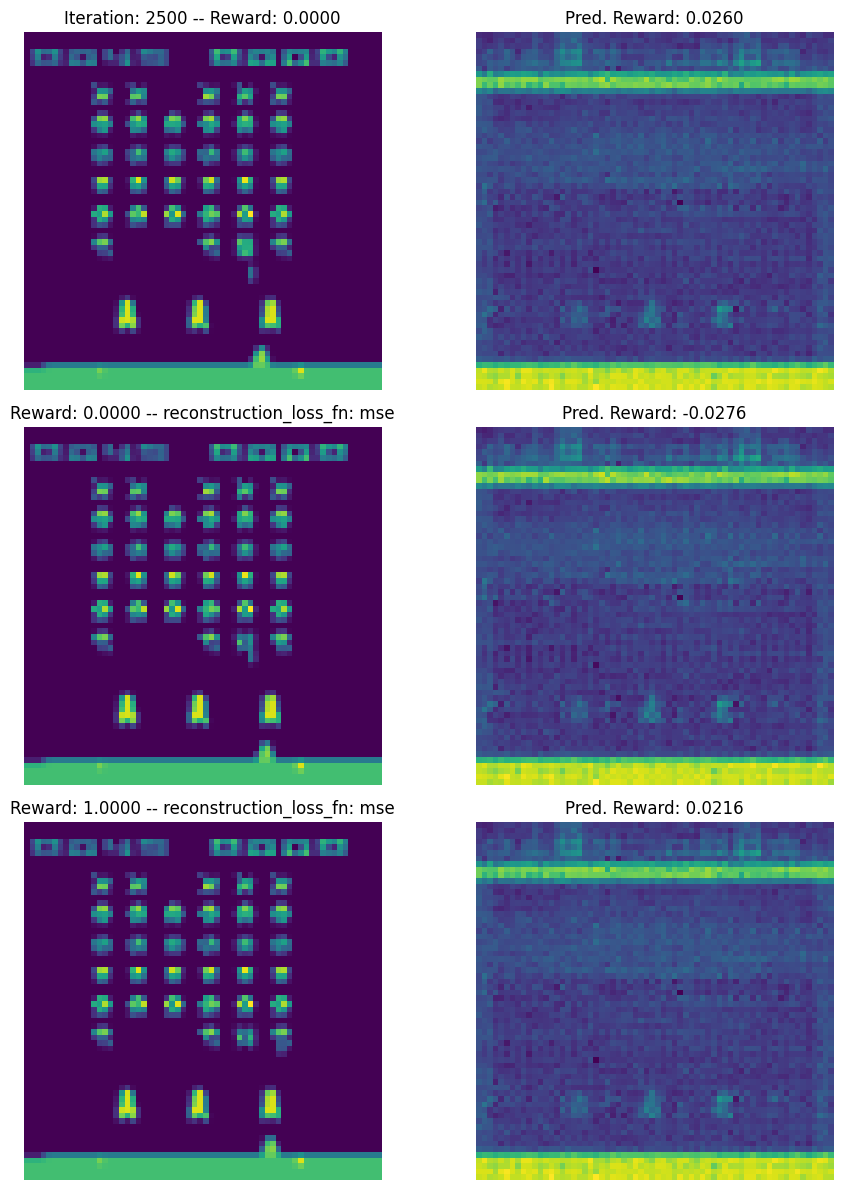

Epoch 6/10:  20%|██        | 100/500 [00:19<01:18,  5.08it/s, Total Loss=0.0401, Recon=0.0161, KL=0.0000, Reward=0.0240]

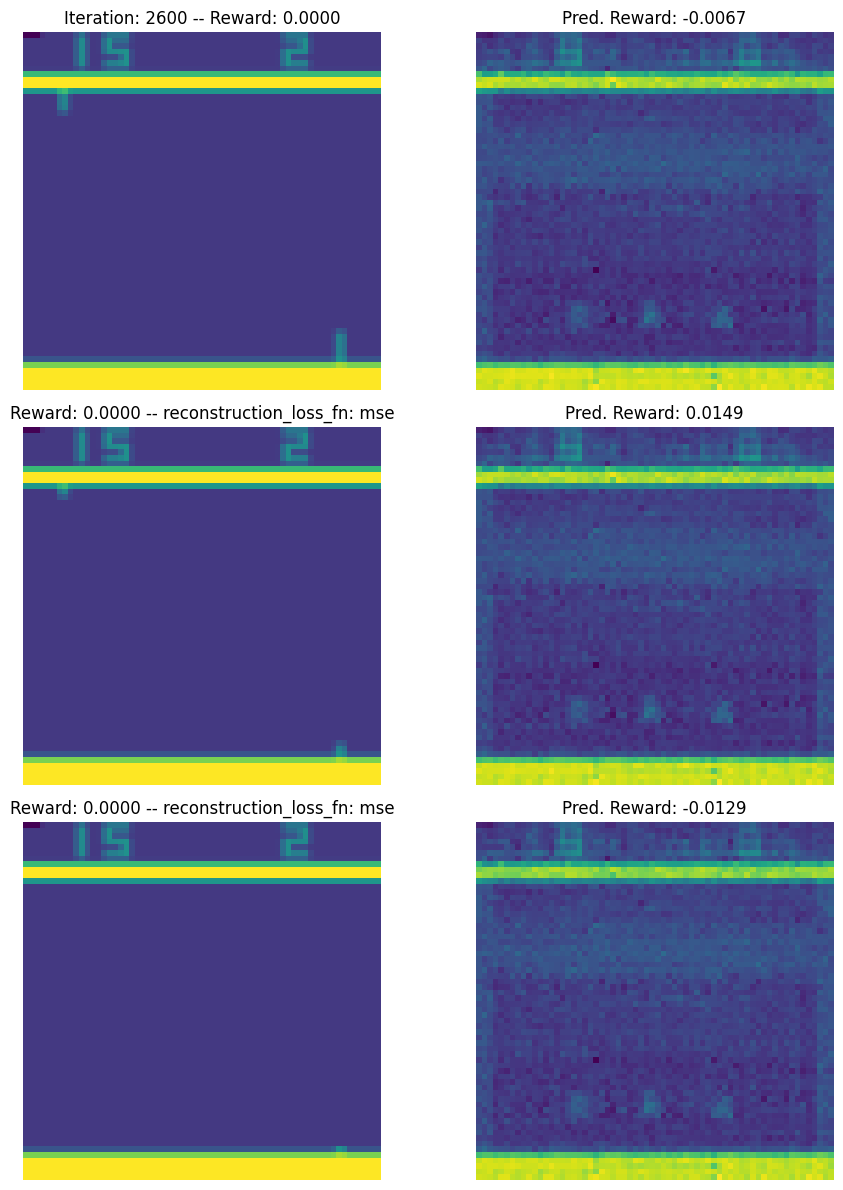

Epoch 6/10:  40%|████      | 200/500 [00:39<00:57,  5.24it/s, Total Loss=0.0698, Recon=0.0521, KL=0.0000, Reward=0.0177]

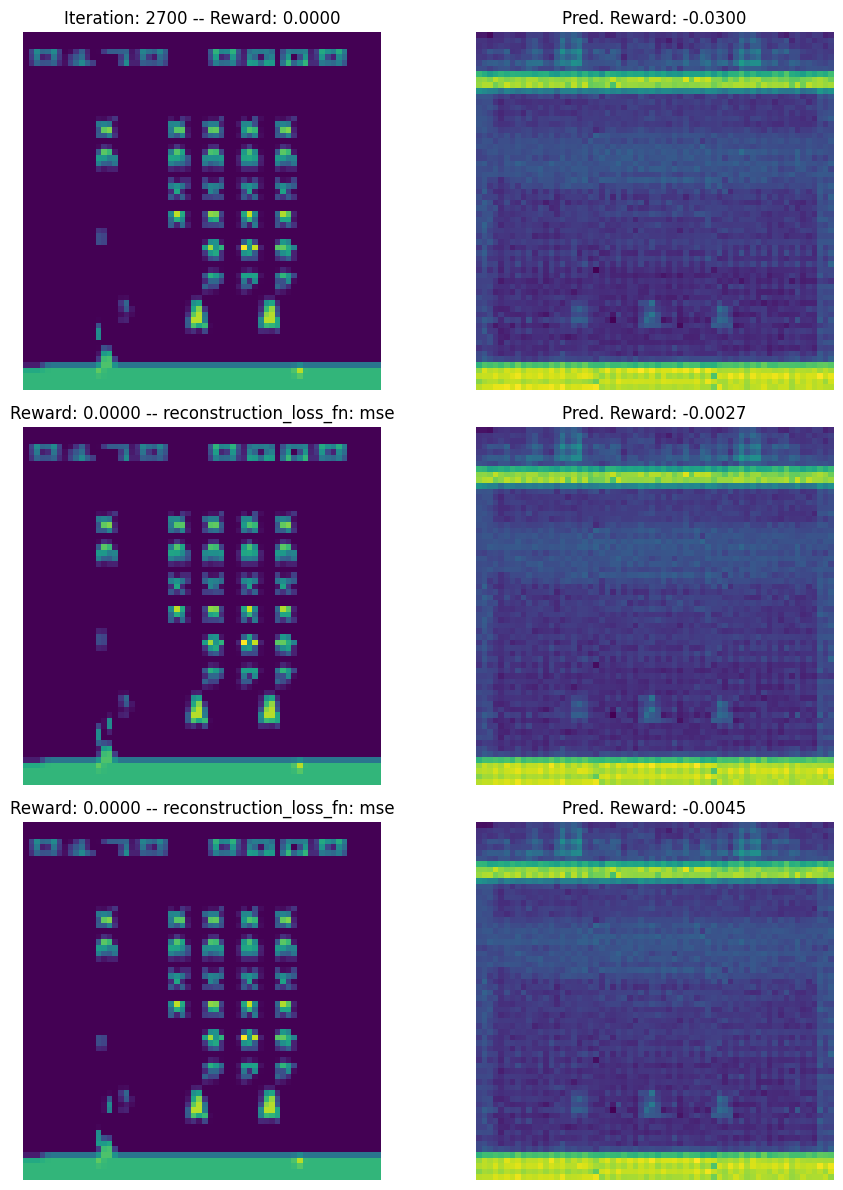

Epoch 6/10:  60%|██████    | 300/500 [00:59<00:38,  5.17it/s, Total Loss=0.0326, Recon=0.0180, KL=0.0000, Reward=0.0146]

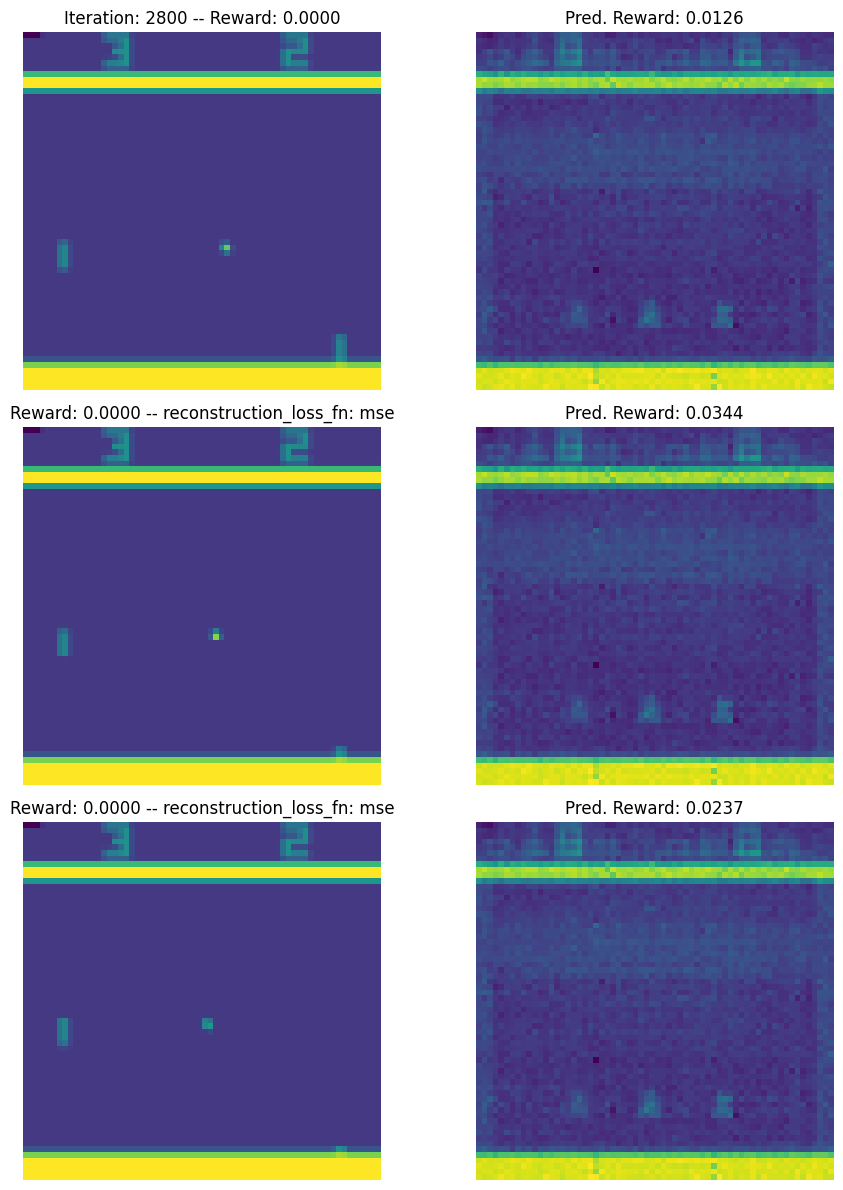

Epoch 6/10:  80%|████████  | 400/500 [01:19<00:19,  5.21it/s, Total Loss=0.0563, Recon=0.0348, KL=0.0000, Reward=0.0215]

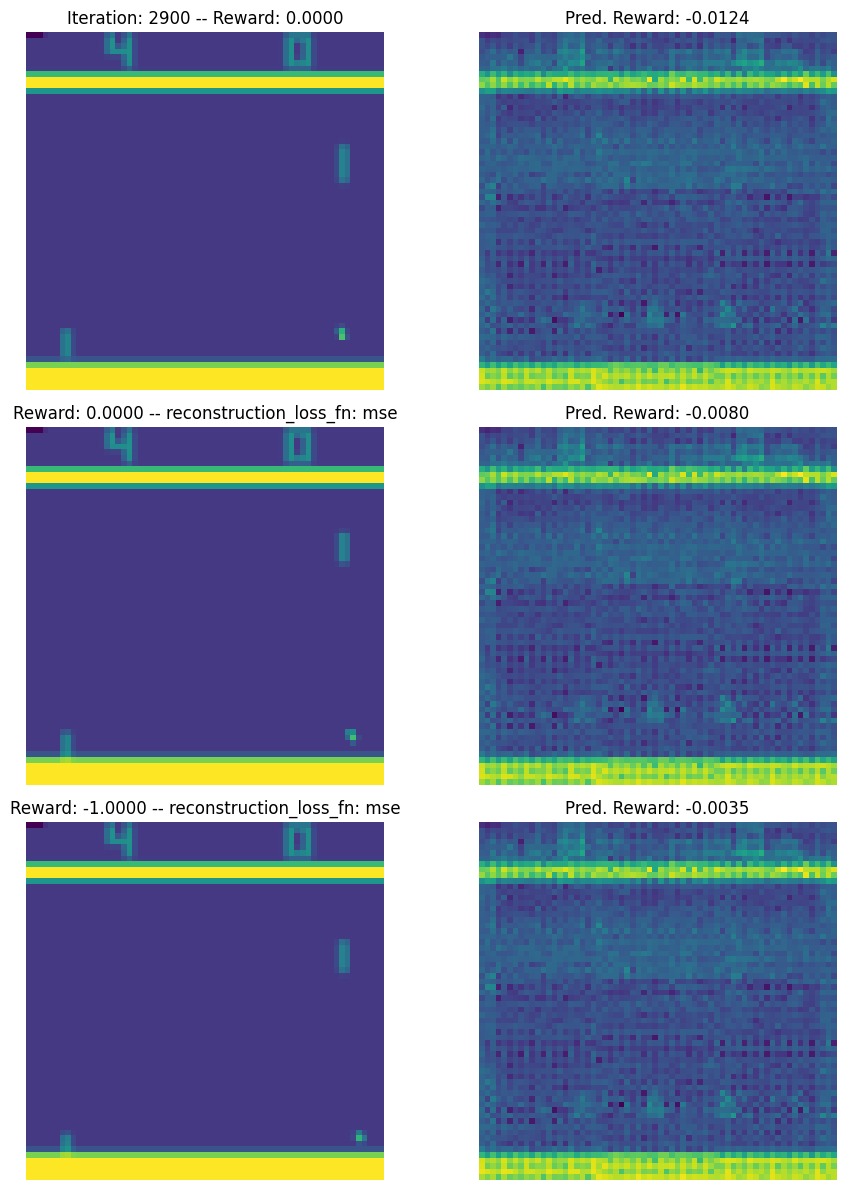

Epoch 6/10: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s, Total Loss=0.0436, Recon=0.0232, KL=0.0001, Reward=0.0202]


Epoch 6 completed. Average loss: 0.0615


Epoch 7/10:   0%|          | 0/500 [00:00<?, ?it/s]

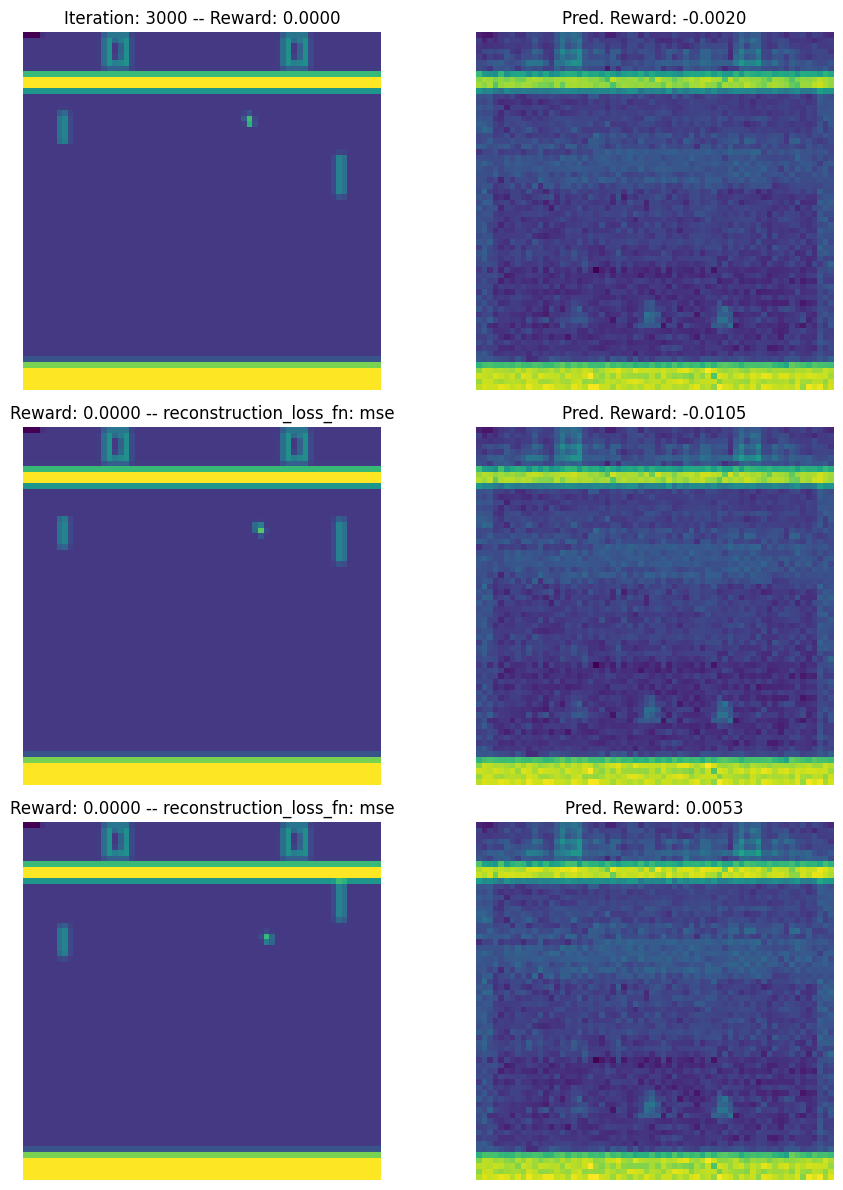

Epoch 7/10:  20%|██        | 100/500 [00:19<01:14,  5.37it/s, Total Loss=0.0438, Recon=0.0220, KL=0.0000, Reward=0.0217]

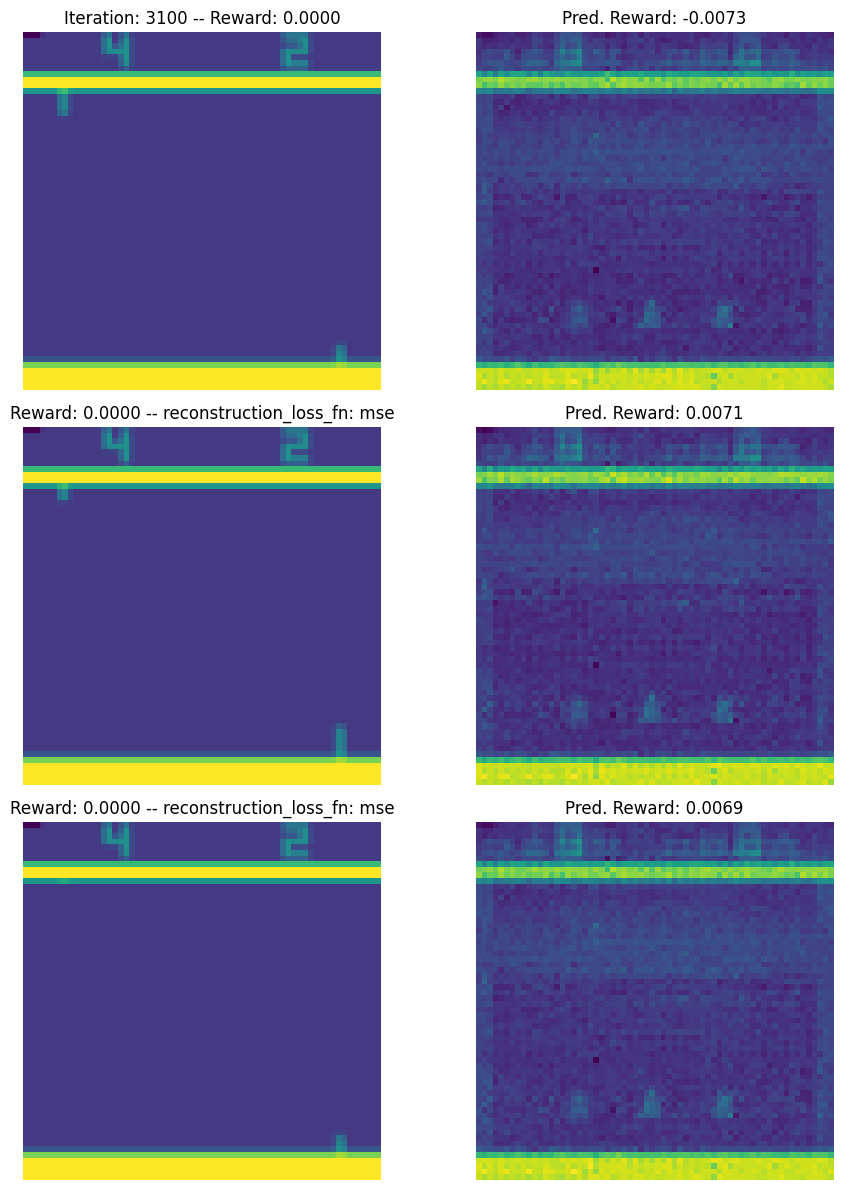

Epoch 7/10:  40%|████      | 200/500 [00:38<00:56,  5.35it/s, Total Loss=0.0597, Recon=0.0355, KL=0.0000, Reward=0.0242]

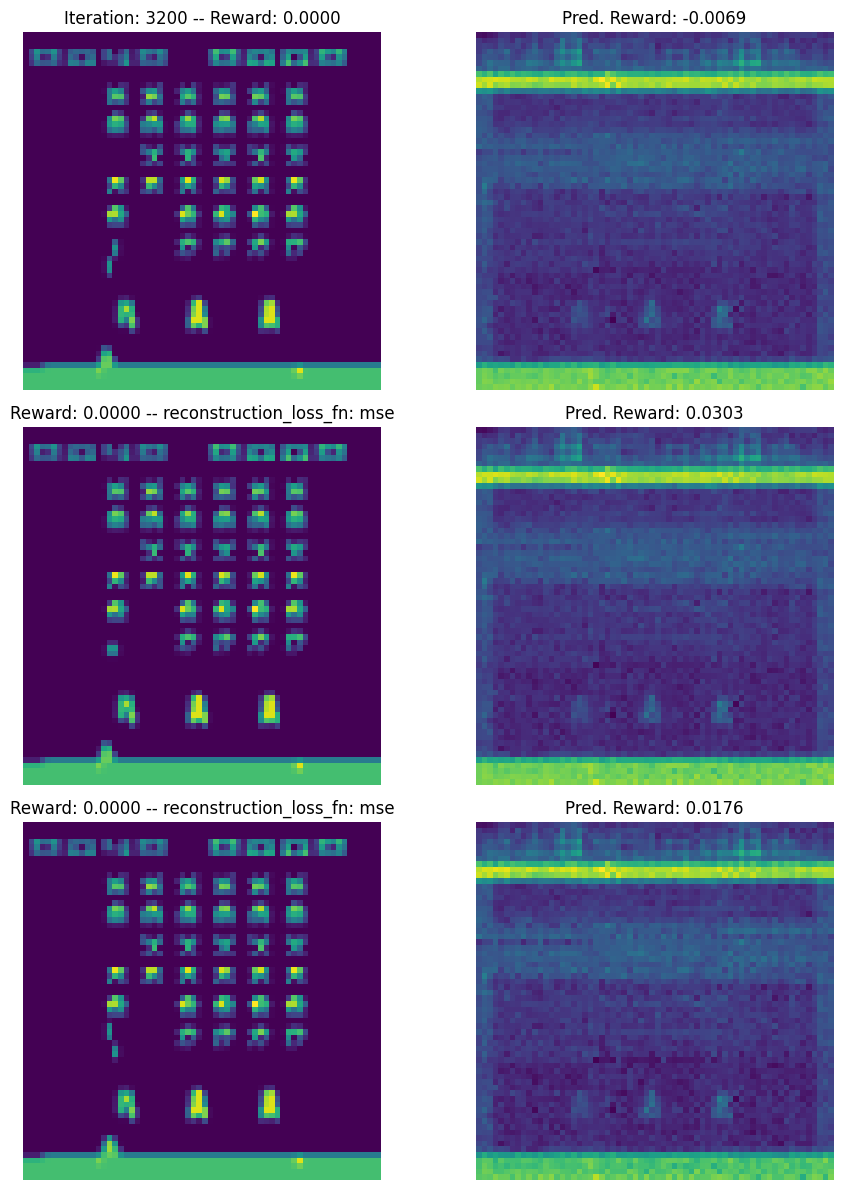

Epoch 7/10:  60%|██████    | 300/500 [00:59<00:40,  4.92it/s, Total Loss=0.0544, Recon=0.0308, KL=0.0001, Reward=0.0234]

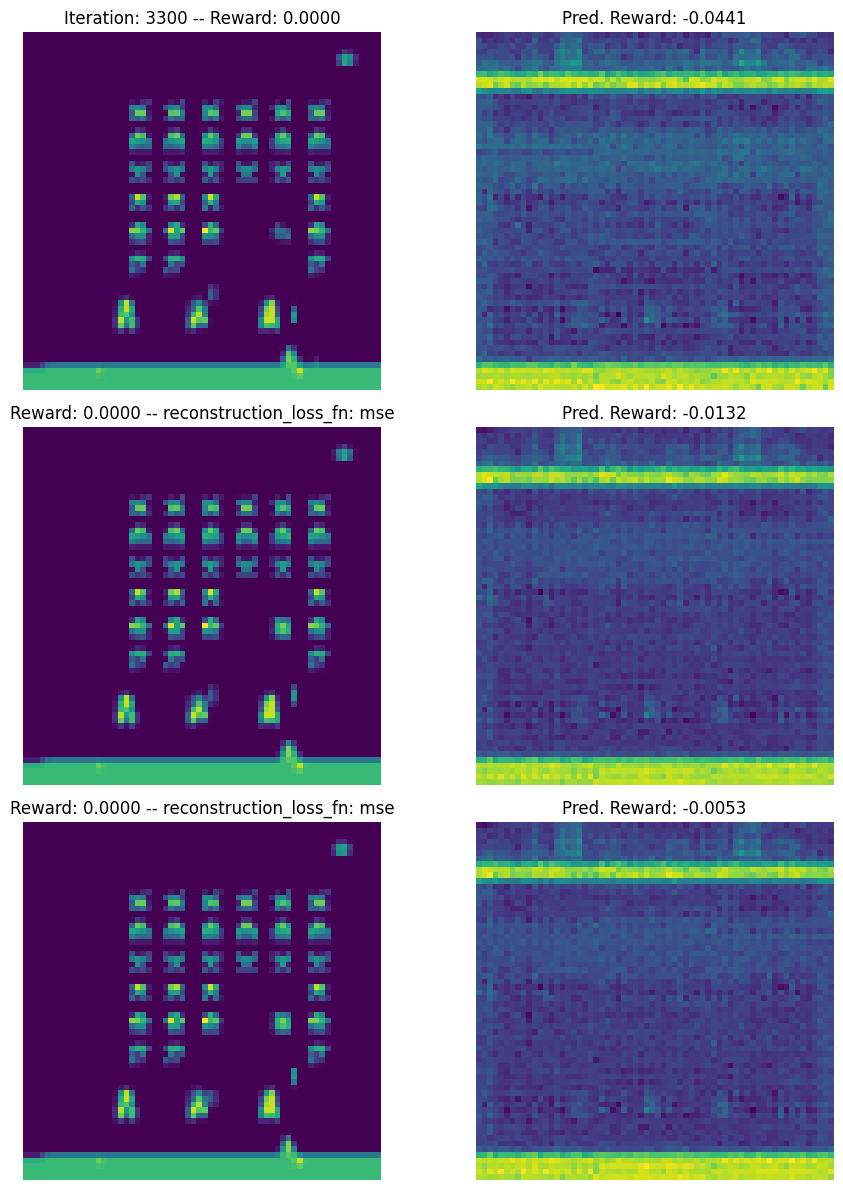

Epoch 7/10:  80%|████████  | 400/500 [01:18<00:19,  5.17it/s, Total Loss=0.0374, Recon=0.0211, KL=0.0000, Reward=0.0163]

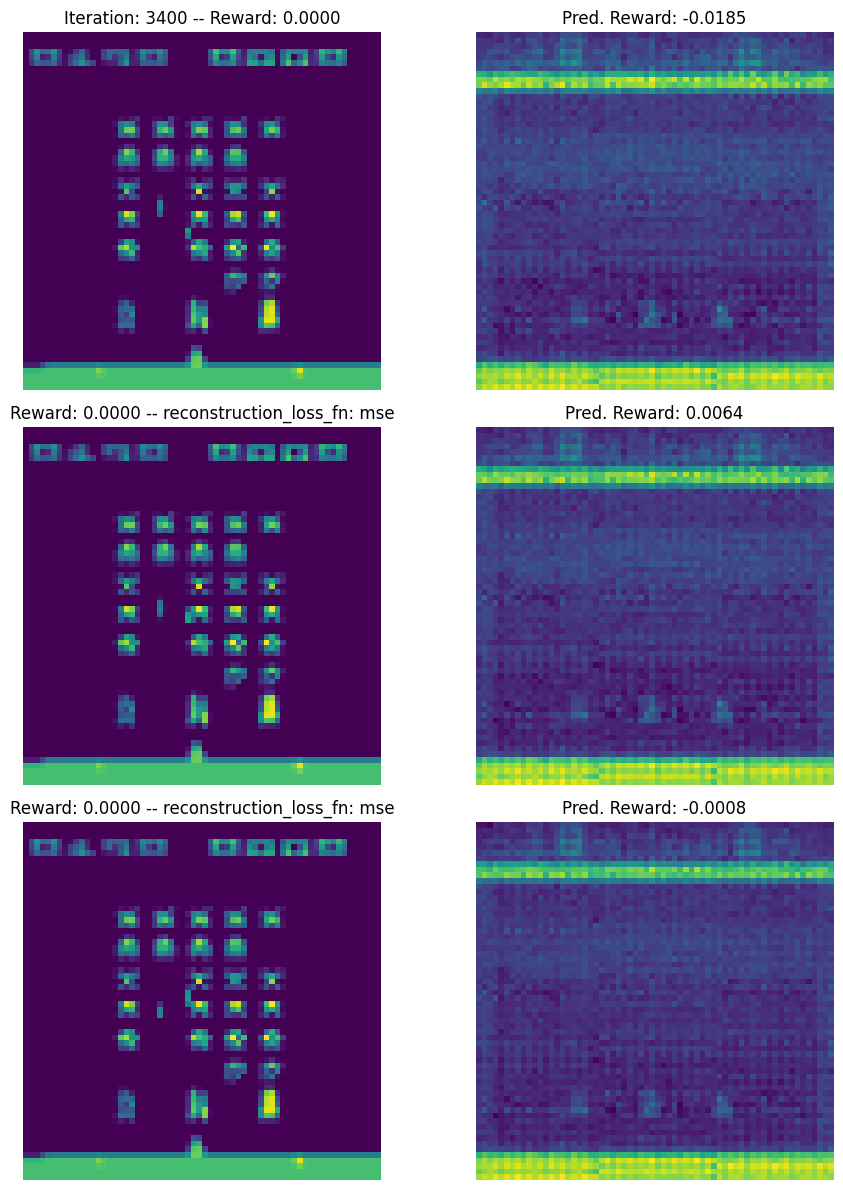

Epoch 7/10: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s, Total Loss=0.0608, Recon=0.0396, KL=0.0004, Reward=0.0207]


Epoch 7 completed. Average loss: 0.0615


Epoch 8/10:   0%|          | 0/500 [00:00<?, ?it/s]

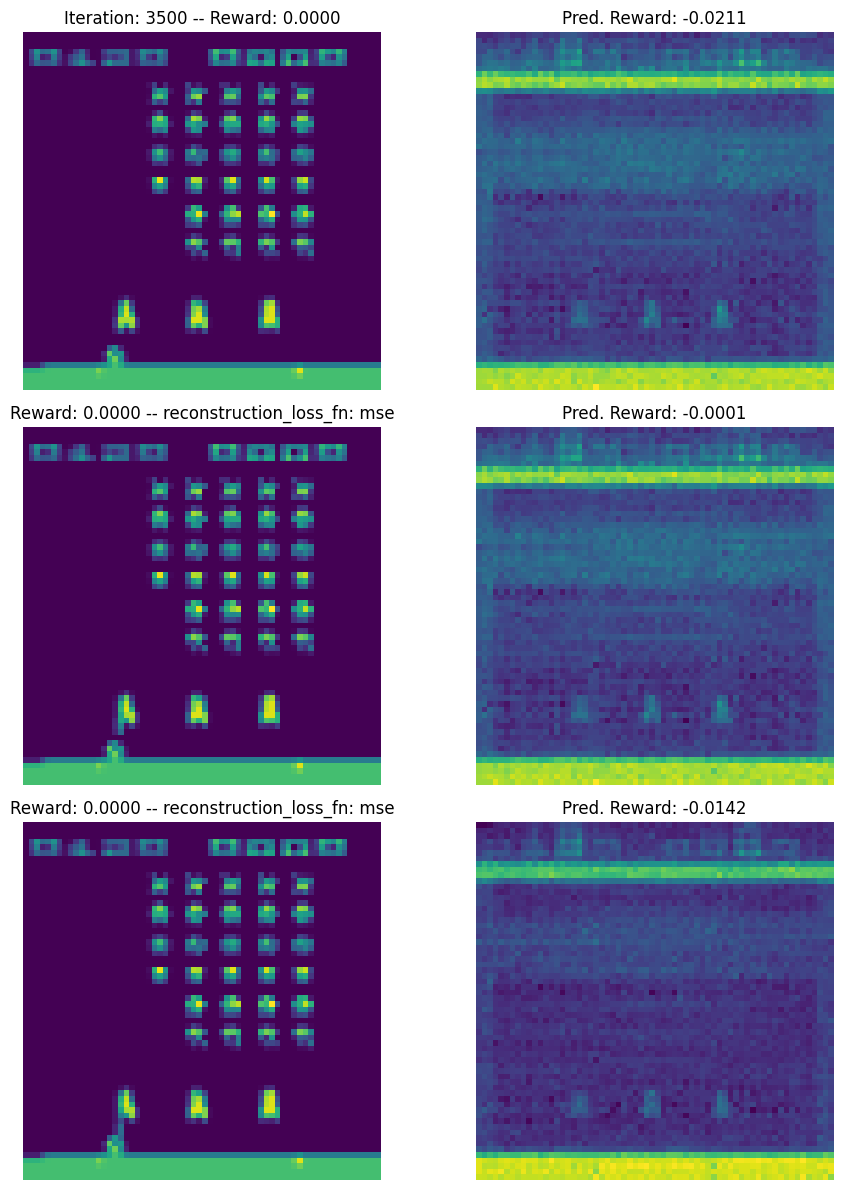

Epoch 8/10:  20%|██        | 100/500 [00:19<01:18,  5.11it/s, Total Loss=0.0639, Recon=0.0456, KL=0.0004, Reward=0.0179]

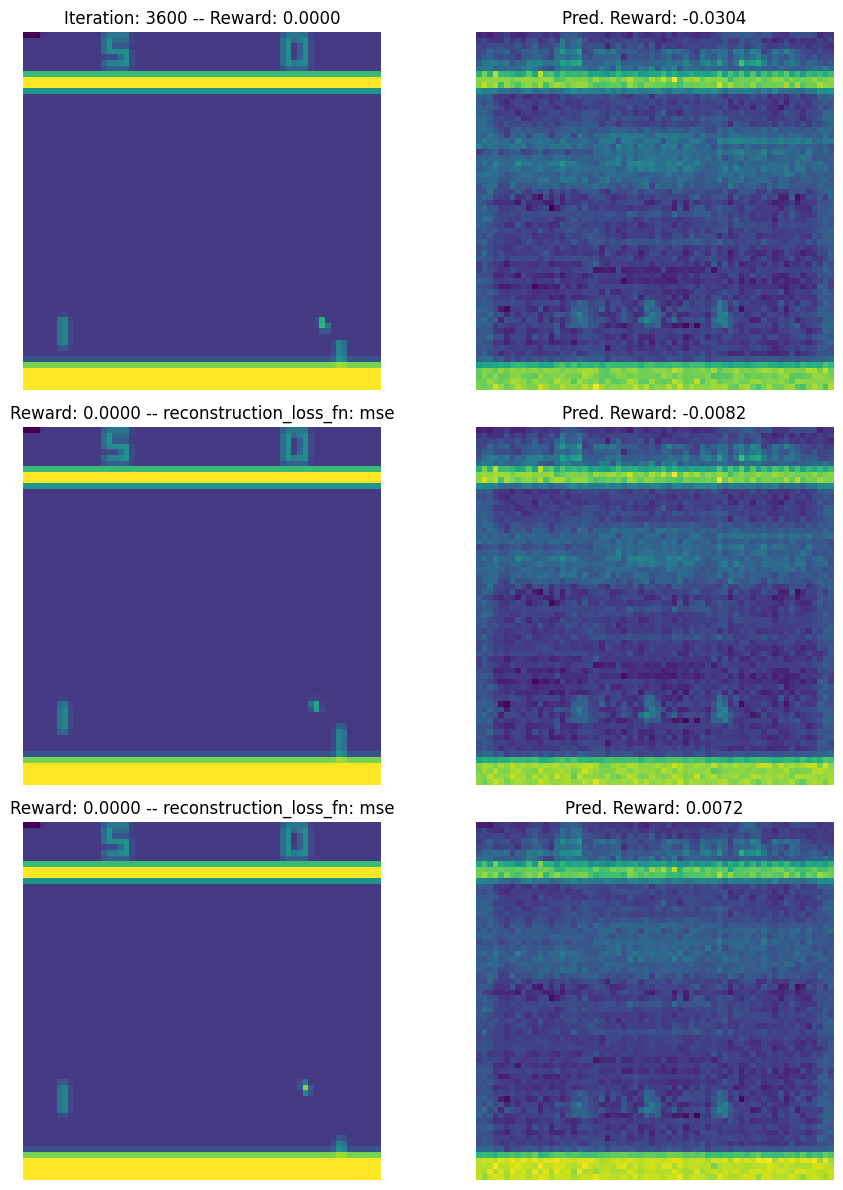

Epoch 8/10:  40%|████      | 200/500 [00:39<00:58,  5.16it/s, Total Loss=0.0342, Recon=0.0216, KL=0.0000, Reward=0.0126]

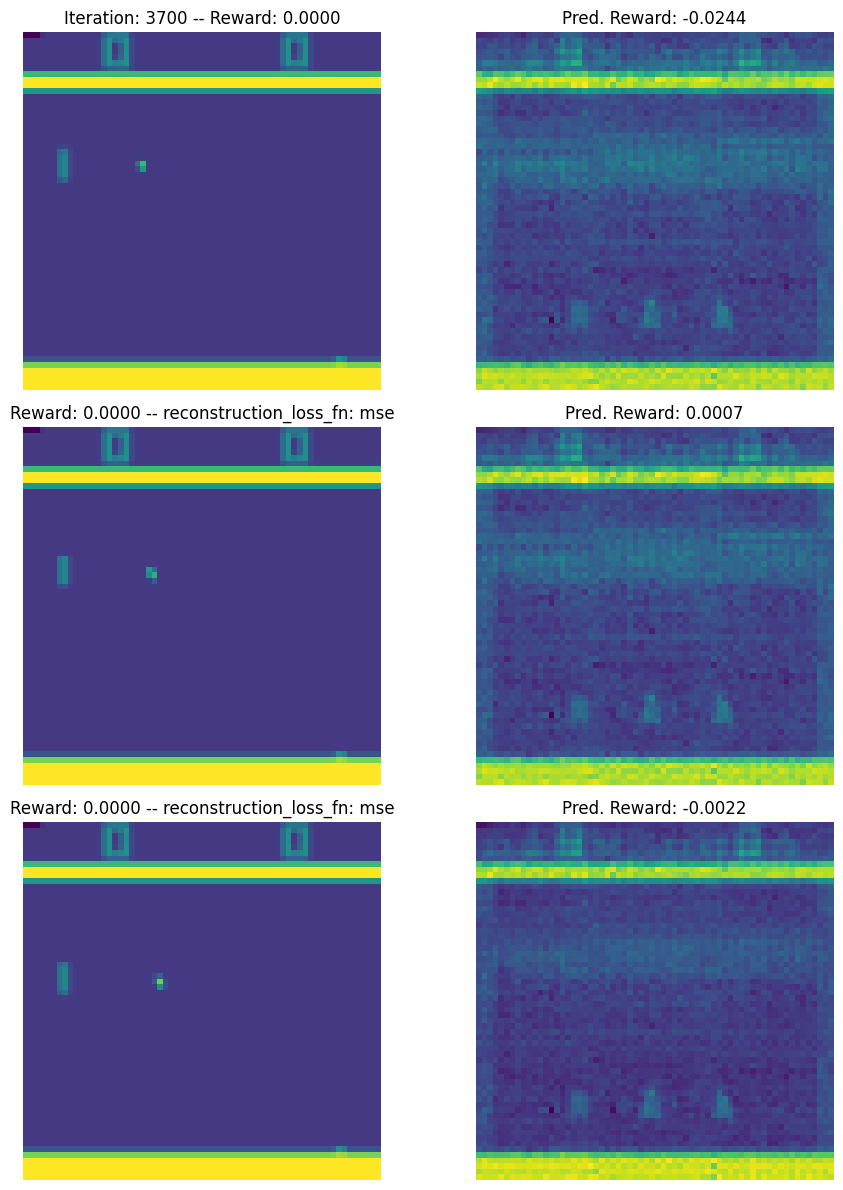

Epoch 8/10:  60%|██████    | 300/500 [00:59<00:38,  5.15it/s, Total Loss=0.0535, Recon=0.0297, KL=0.0000, Reward=0.0237]

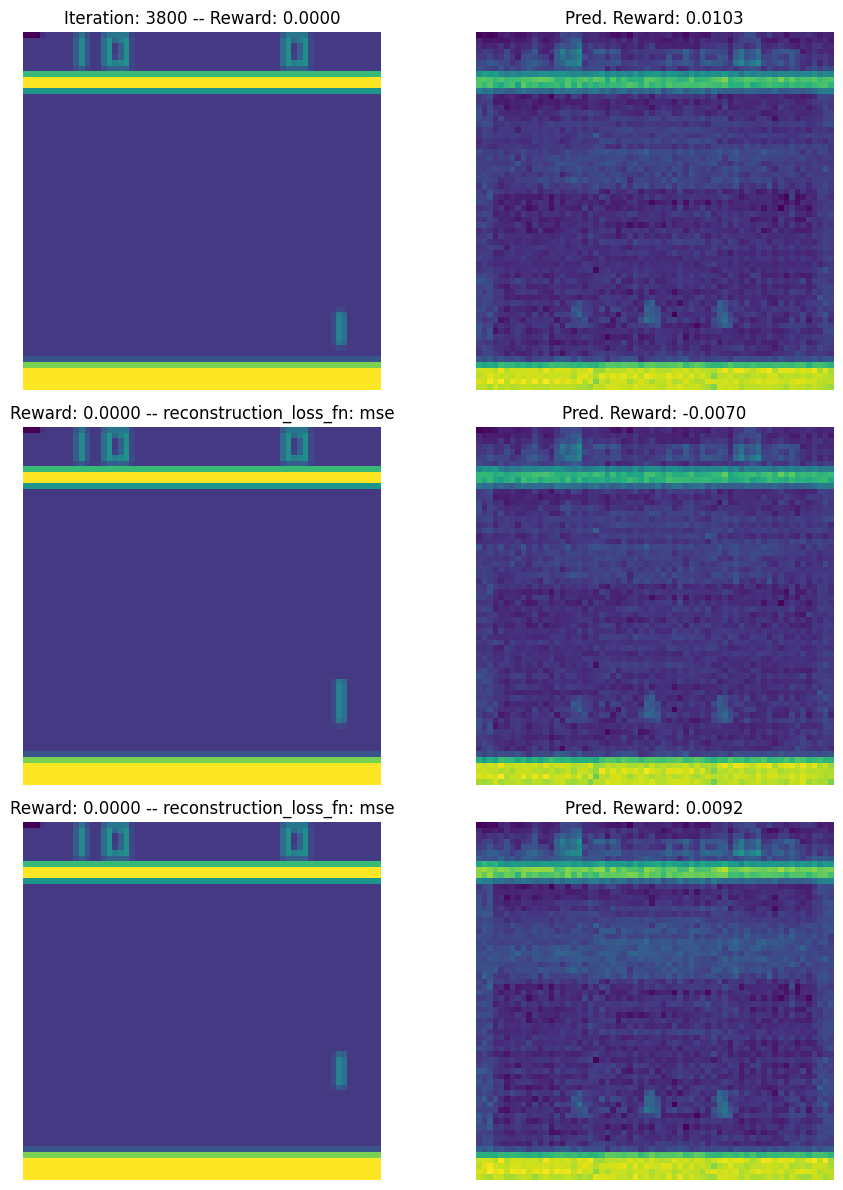

Epoch 8/10:  80%|████████  | 400/500 [01:19<00:19,  5.12it/s, Total Loss=0.0889, Recon=0.0649, KL=0.0001, Reward=0.0239]

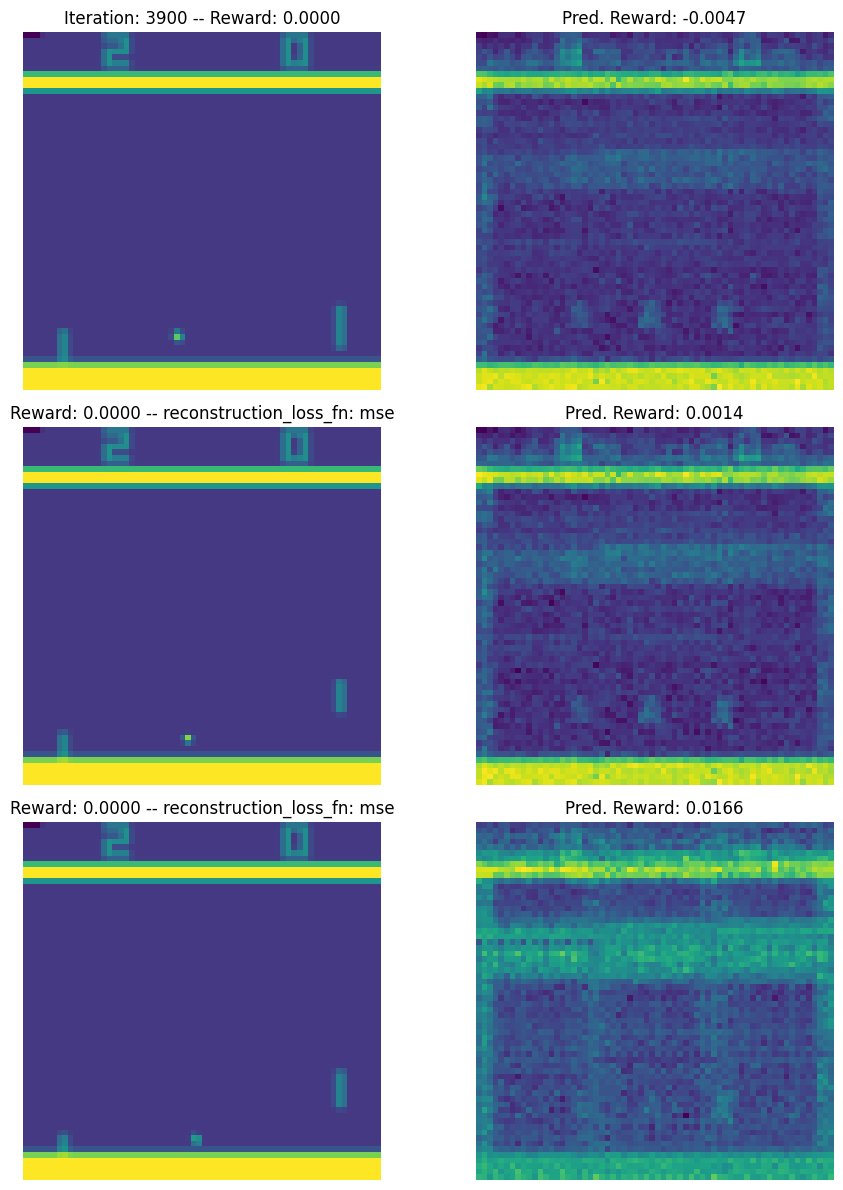

Epoch 8/10: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s, Total Loss=0.1060, Recon=0.0806, KL=0.0000, Reward=0.0254]


Epoch 8 completed. Average loss: 0.0594


Epoch 9/10:   0%|          | 0/500 [00:00<?, ?it/s]

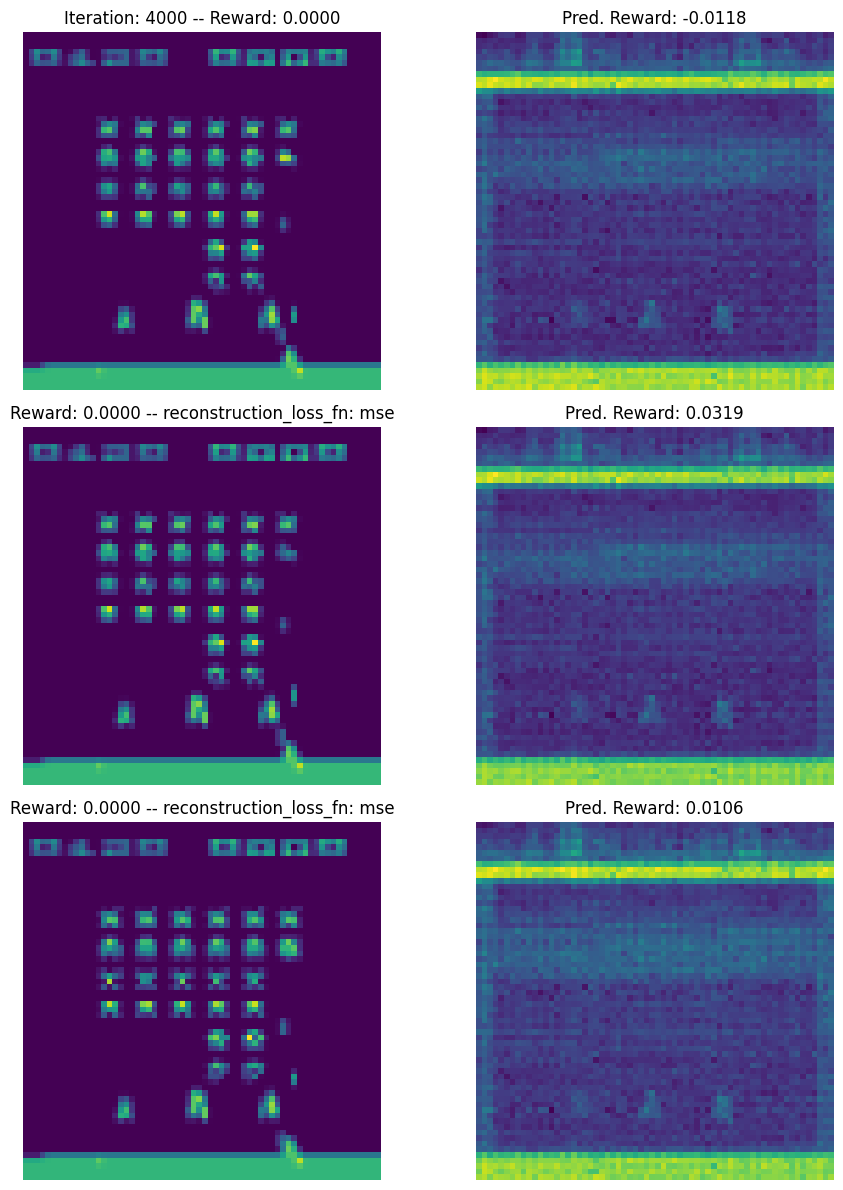

Epoch 9/10:  20%|██        | 100/500 [00:19<01:16,  5.20it/s, Total Loss=0.0829, Recon=0.0651, KL=0.0001, Reward=0.0177]

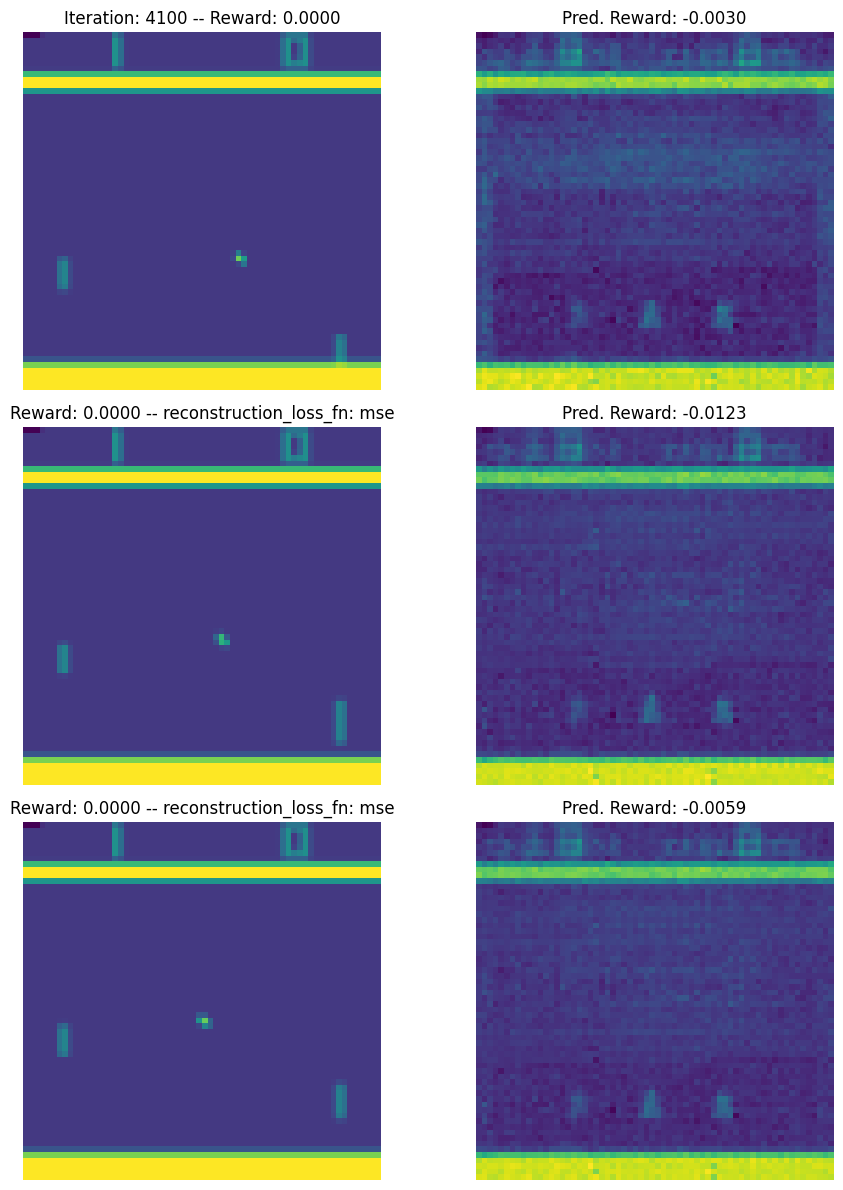

Epoch 9/10:  40%|████      | 200/500 [00:39<00:57,  5.23it/s, Total Loss=0.0787, Recon=0.0501, KL=0.0000, Reward=0.0286]

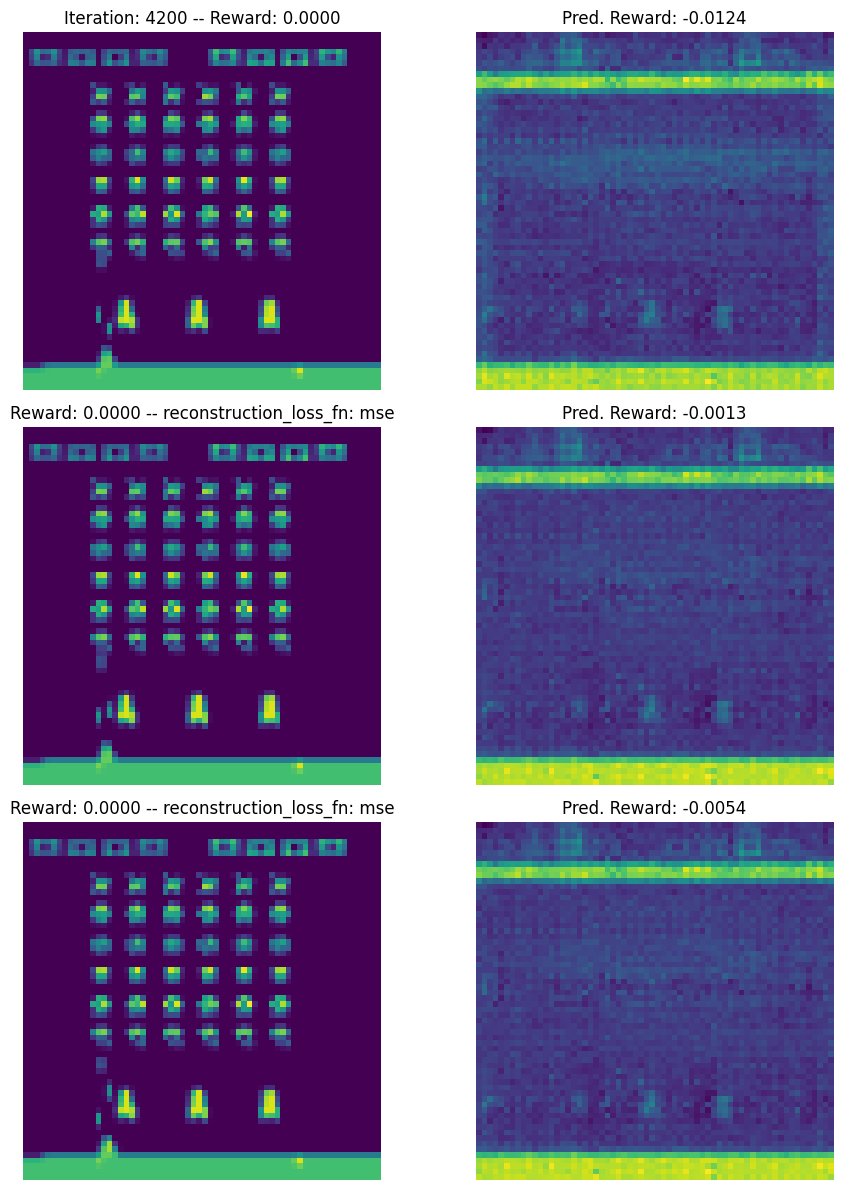

Epoch 9/10:  60%|██████    | 300/500 [00:59<00:38,  5.14it/s, Total Loss=0.0709, Recon=0.0501, KL=0.0001, Reward=0.0207]

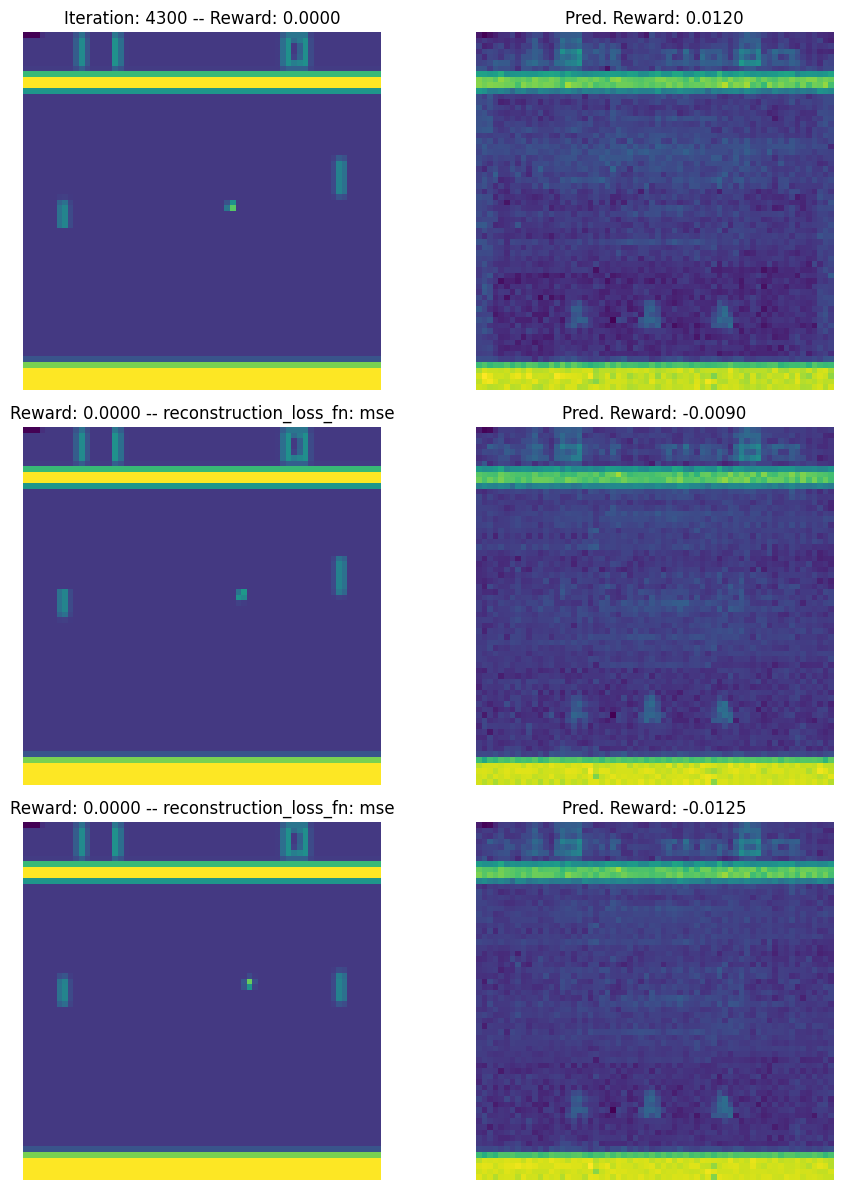

Epoch 9/10:  80%|████████  | 400/500 [01:18<00:19,  5.18it/s, Total Loss=0.0828, Recon=0.0627, KL=0.0000, Reward=0.0201]

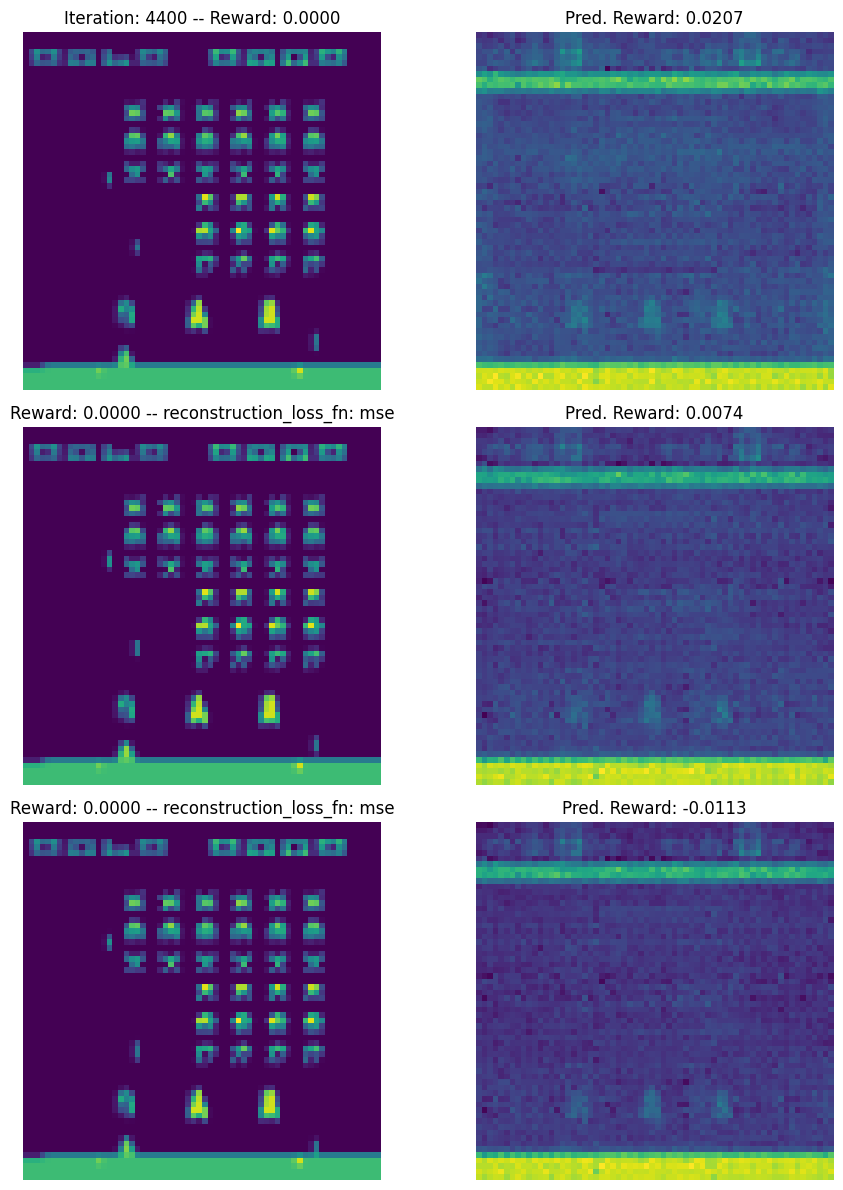

Epoch 9/10: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s, Total Loss=0.0959, Recon=0.0731, KL=0.0001, Reward=0.0227]


Epoch 9 completed. Average loss: 0.0576


Epoch 10/10:   0%|          | 0/500 [00:00<?, ?it/s]

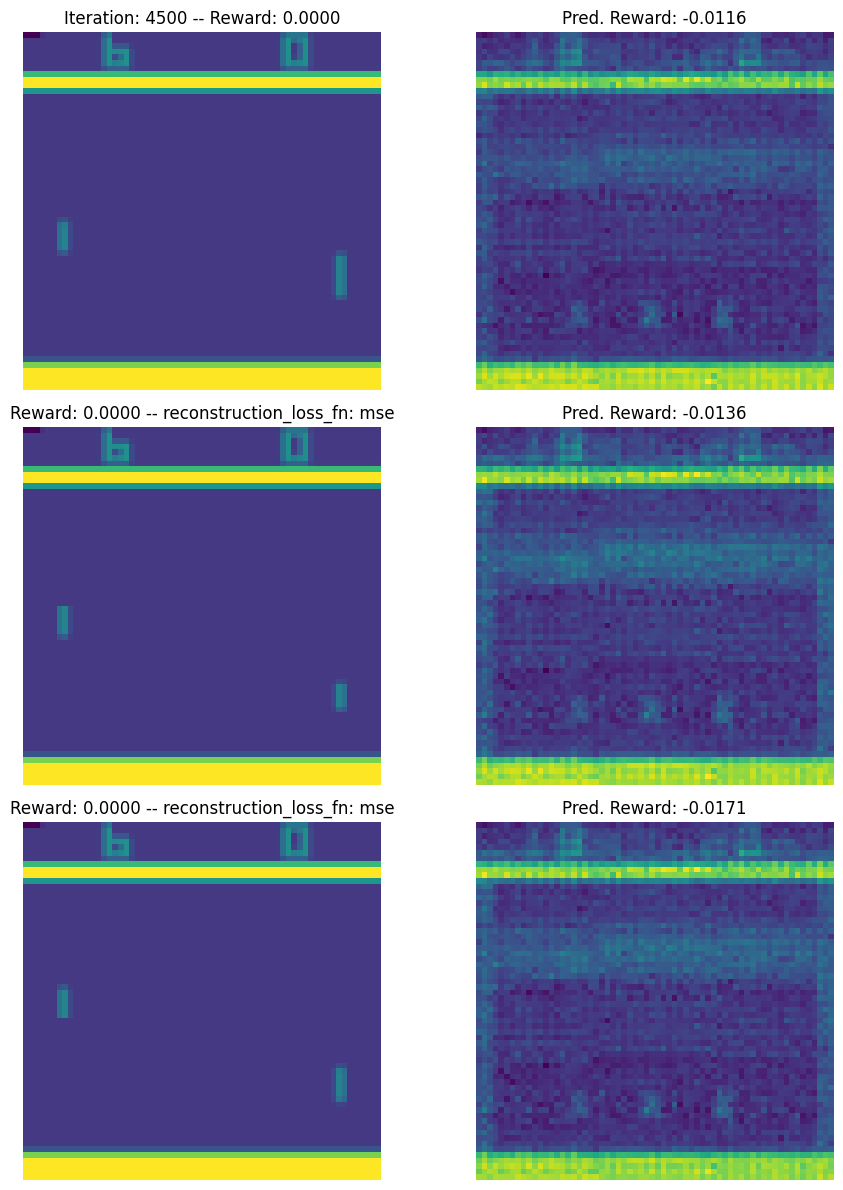

Epoch 10/10:  20%|██        | 100/500 [00:19<01:17,  5.14it/s, Total Loss=0.0492, Recon=0.0281, KL=0.0001, Reward=0.0210]

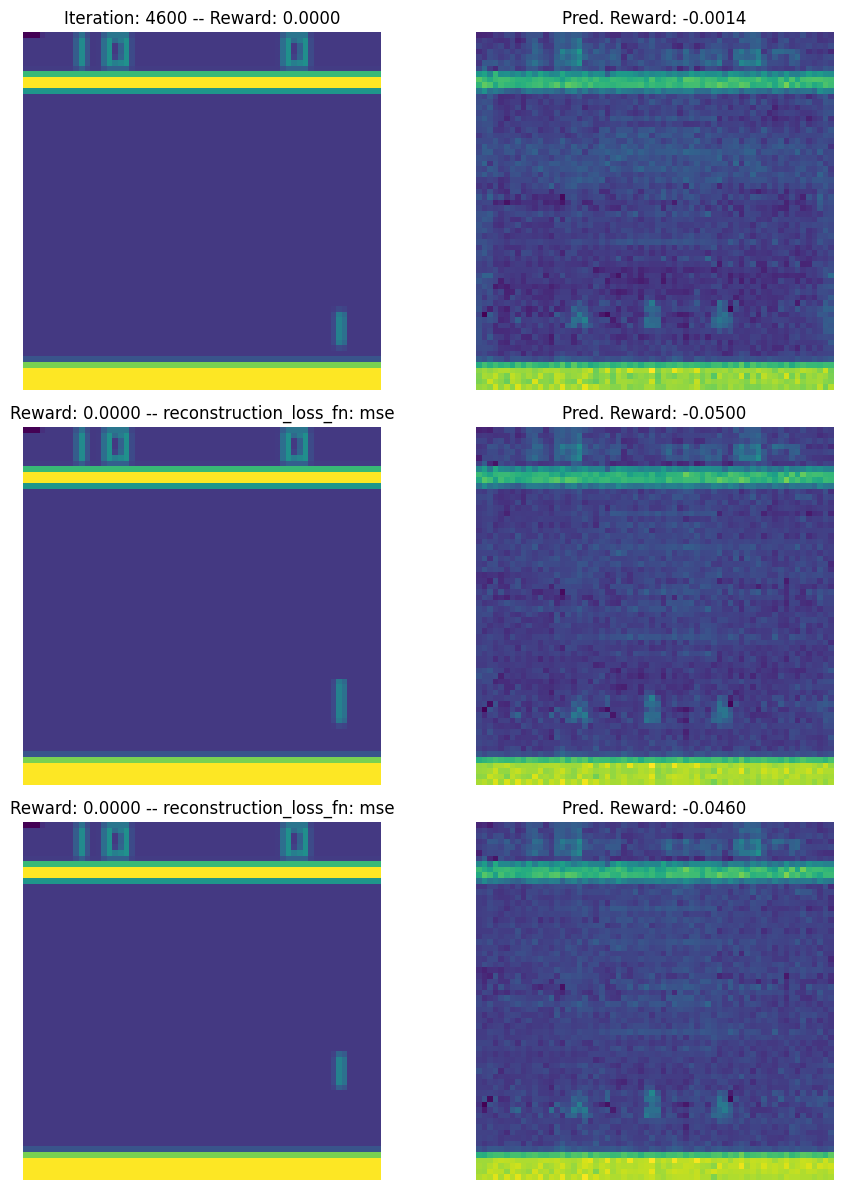

Epoch 10/10:  40%|████      | 200/500 [00:39<00:59,  5.06it/s, Total Loss=0.0442, Recon=0.0265, KL=0.0003, Reward=0.0173]

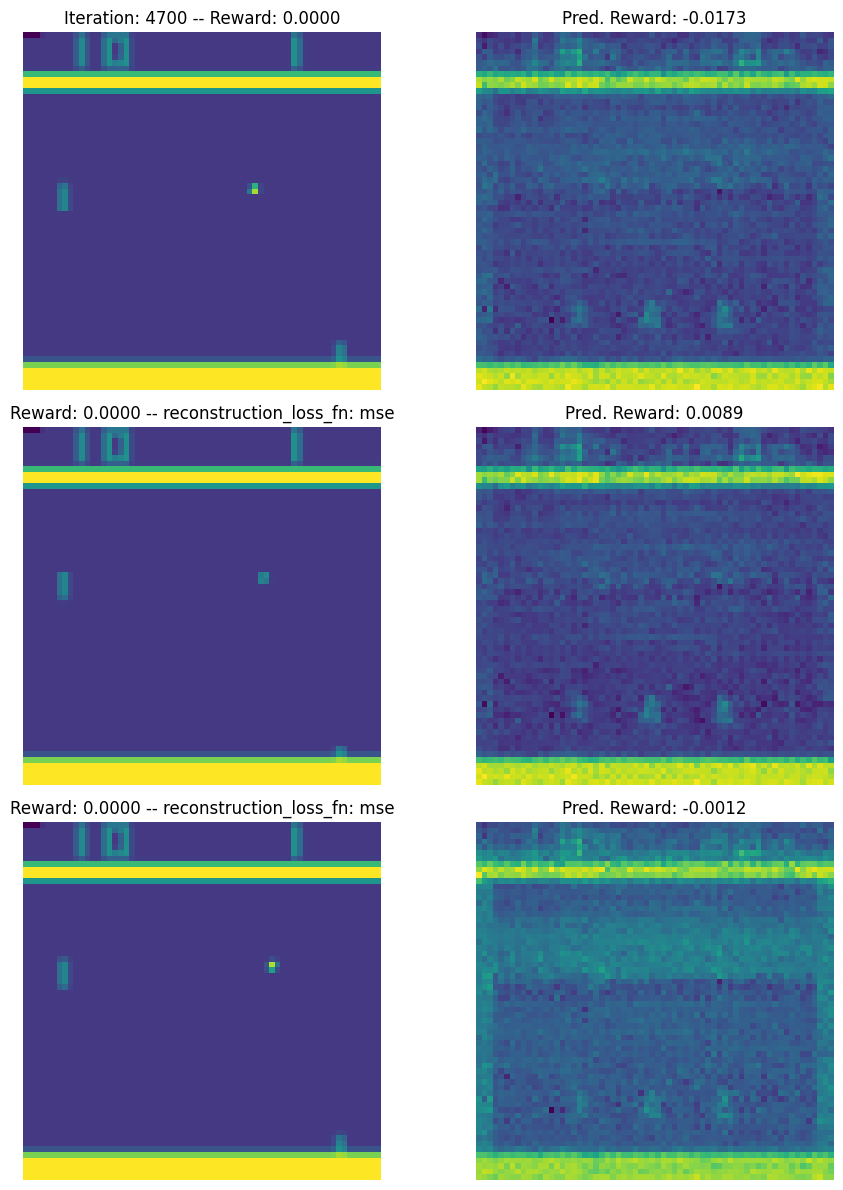

Epoch 10/10:  60%|██████    | 300/500 [00:59<00:38,  5.23it/s, Total Loss=0.0407, Recon=0.0168, KL=0.0003, Reward=0.0236]

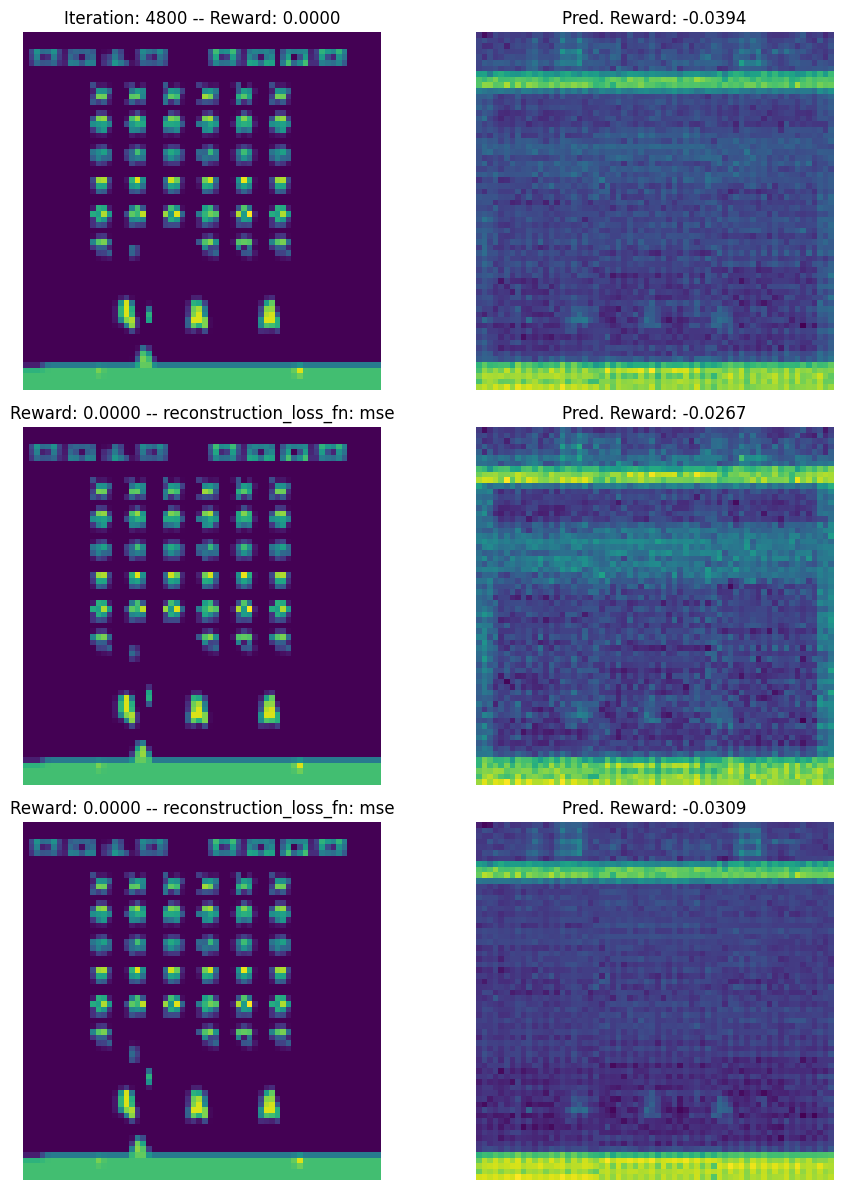

Epoch 10/10:  80%|████████  | 400/500 [01:19<00:18,  5.28it/s, Total Loss=0.0305, Recon=0.0179, KL=0.0000, Reward=0.0126]

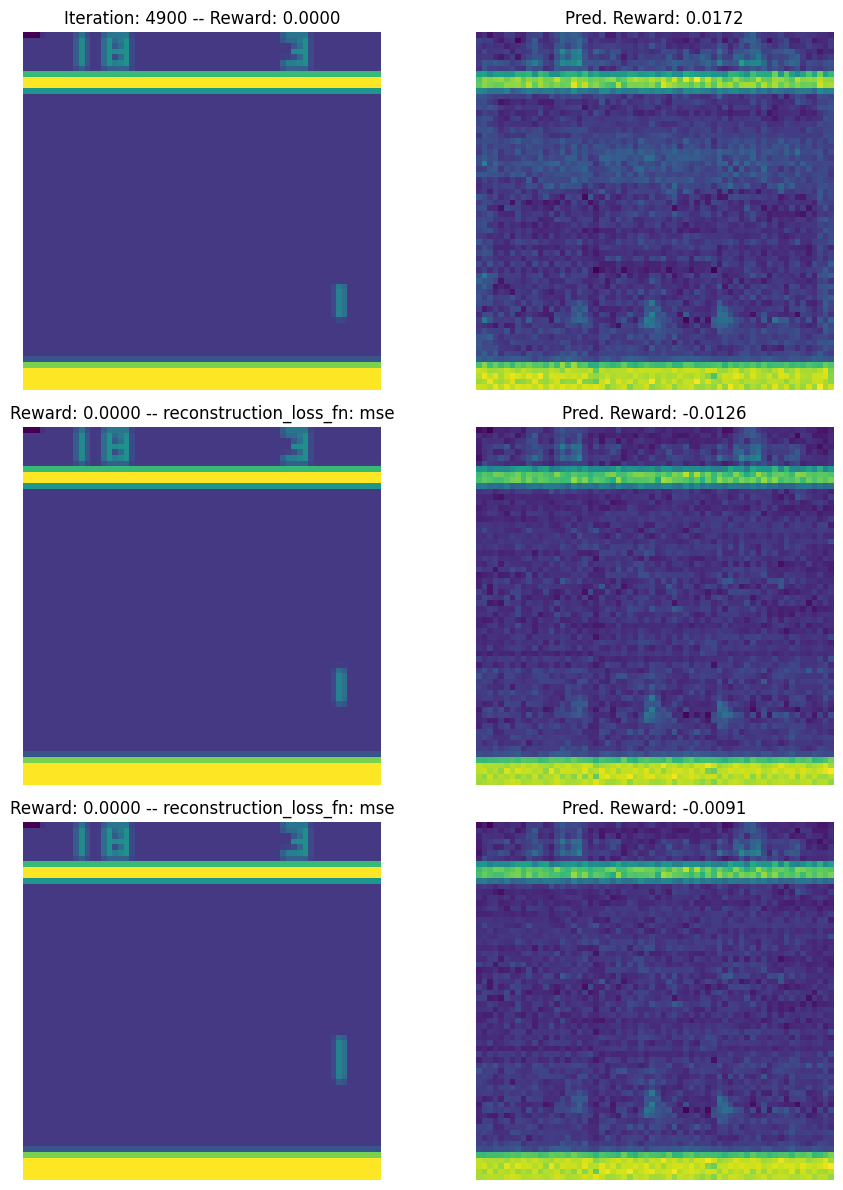

Epoch 10/10: 100%|██████████| 500/500 [01:38<00:00,  5.05it/s, Total Loss=0.0459, Recon=0.0191, KL=0.0001, Reward=0.0268]

Epoch 10 completed. Average loss: 0.0690


In [ ]:
atari_trainer_new = get_new_atari_trainer()
atari_trainer_new.train(num_epochs=10)



=== Training with reconstruction loss: mse ===


Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

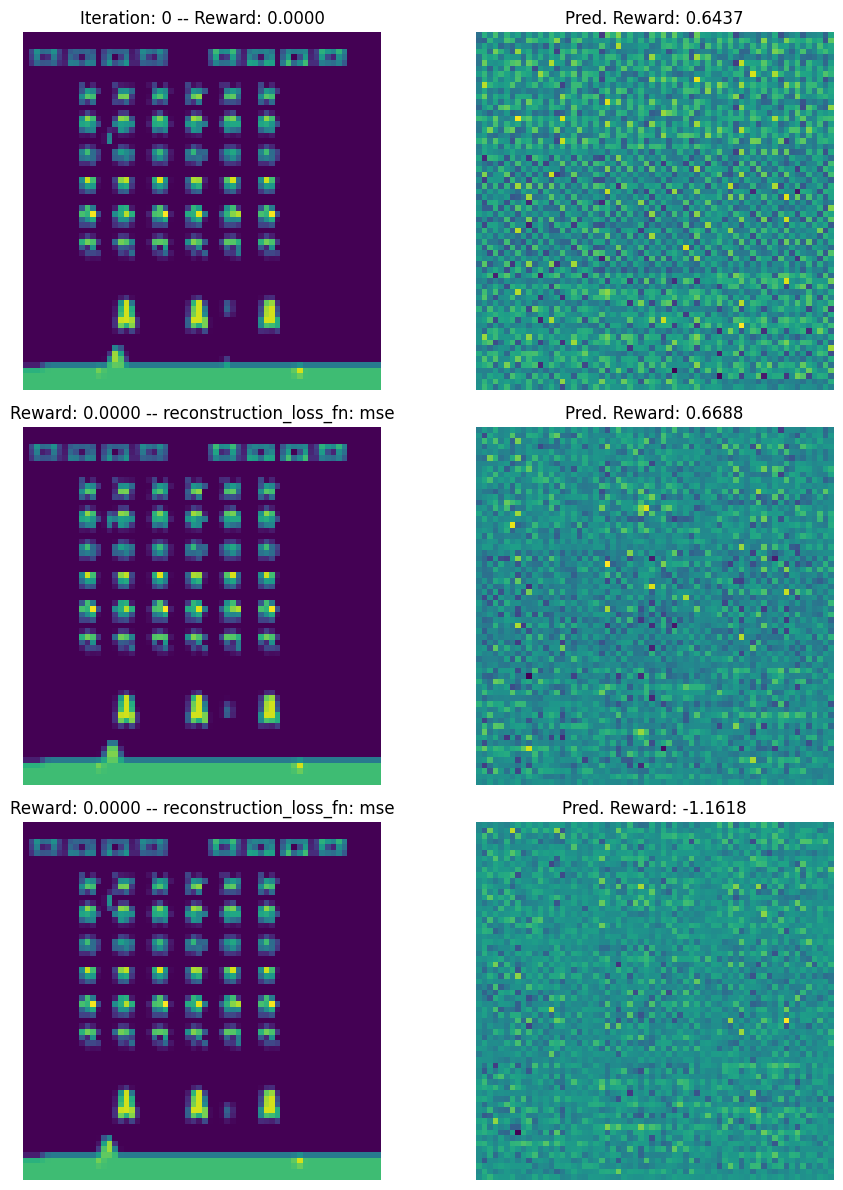

Epoch 1/10: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s, Total Loss=0.0756, Recon=0.0426, KL=0.0012, Reward=0.0318]


Epoch 1 completed. Average loss: 0.2005


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

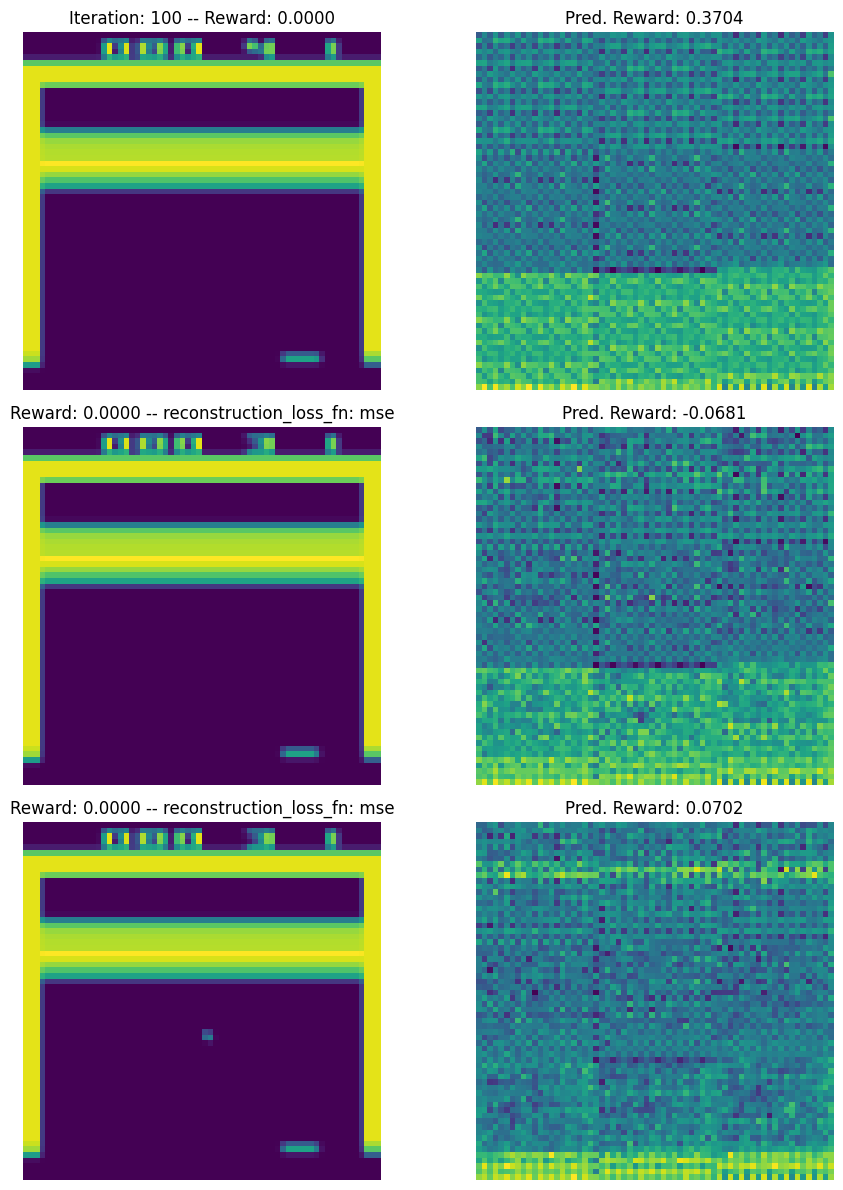

Epoch 2/10: 100%|██████████| 100/100 [00:20<00:00,  4.76it/s, Total Loss=0.0620, Recon=0.0313, KL=0.0000, Reward=0.0308]


Epoch 2 completed. Average loss: 0.0774


Epoch 3/10:   0%|          | 0/100 [00:00<?, ?it/s]

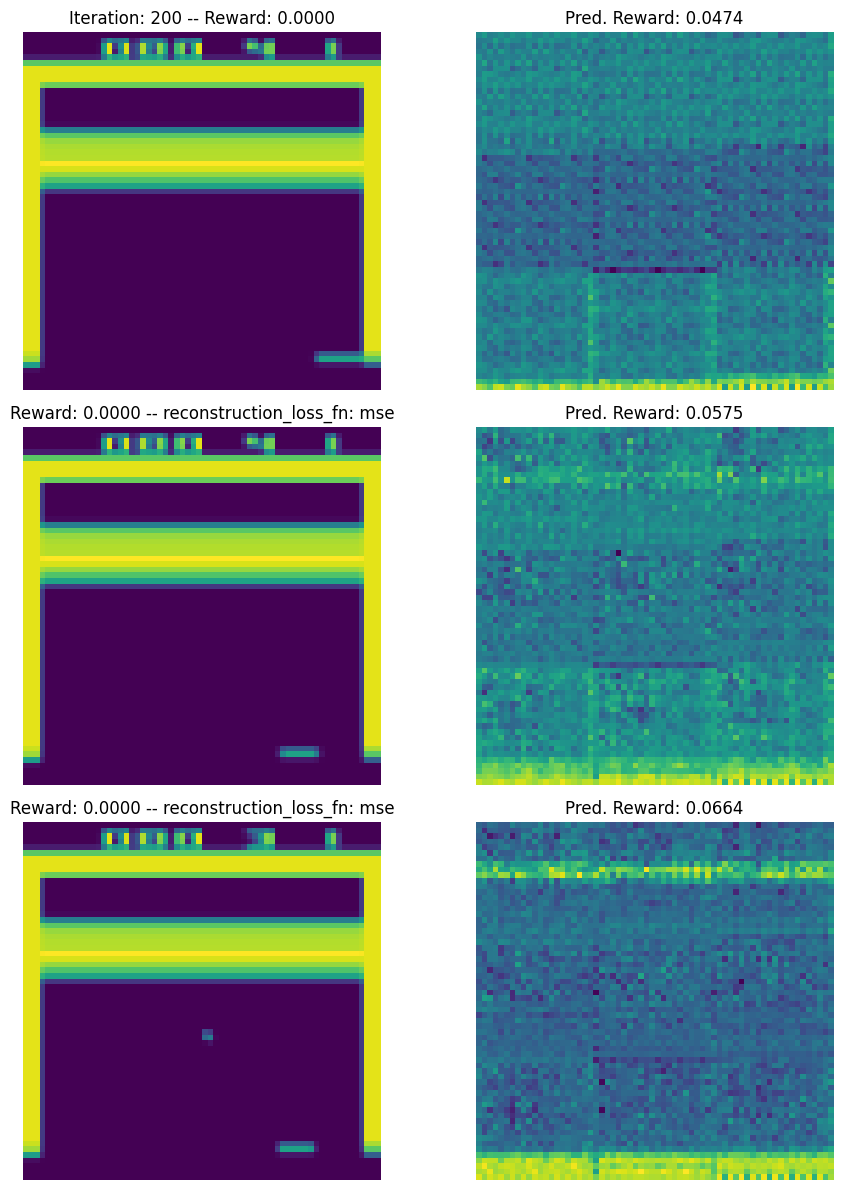

Epoch 3/10: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, Total Loss=0.0881, Recon=0.0739, KL=0.0000, Reward=0.0142]


Epoch 3 completed. Average loss: 0.0685


Epoch 4/10:   0%|          | 0/100 [00:00<?, ?it/s]

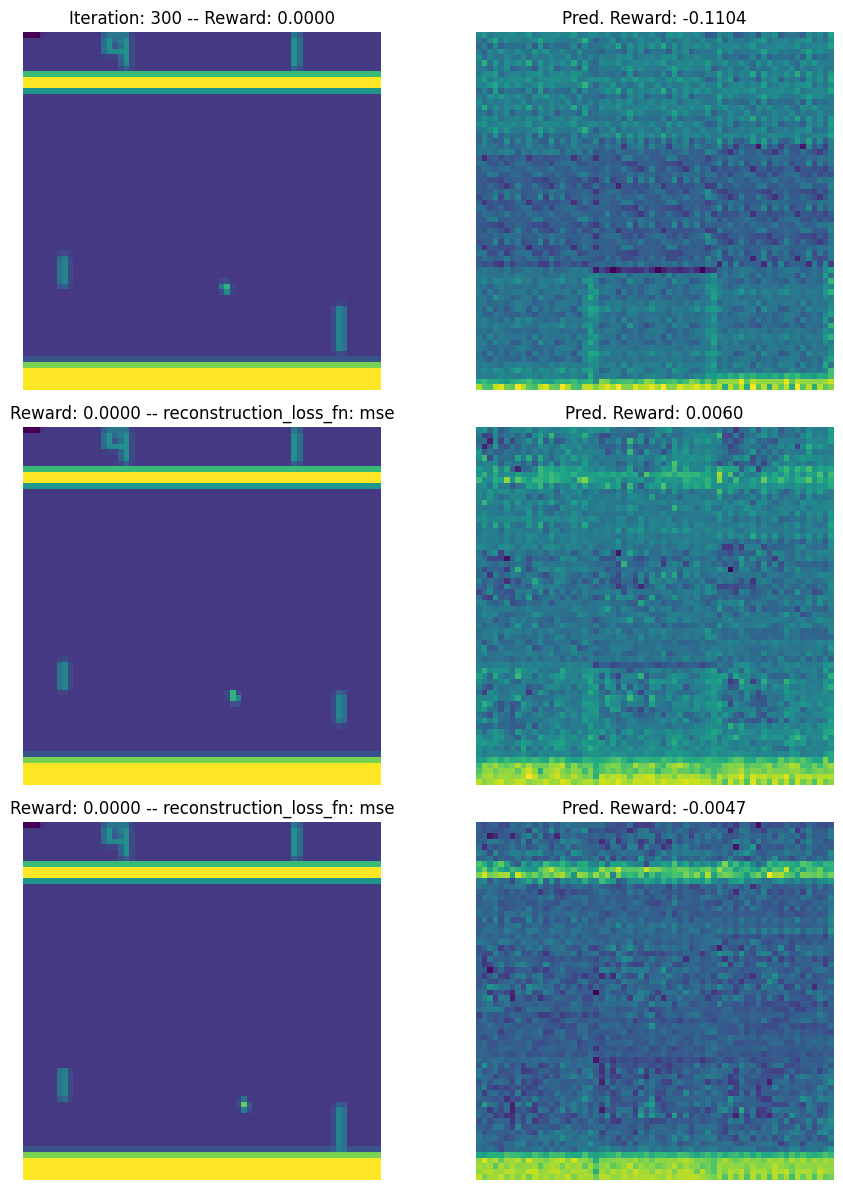

Epoch 4/10: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s, Total Loss=0.0840, Recon=0.0649, KL=0.0000, Reward=0.0191]


Epoch 4 completed. Average loss: 0.0662


Epoch 5/10:   0%|          | 0/100 [00:00<?, ?it/s]

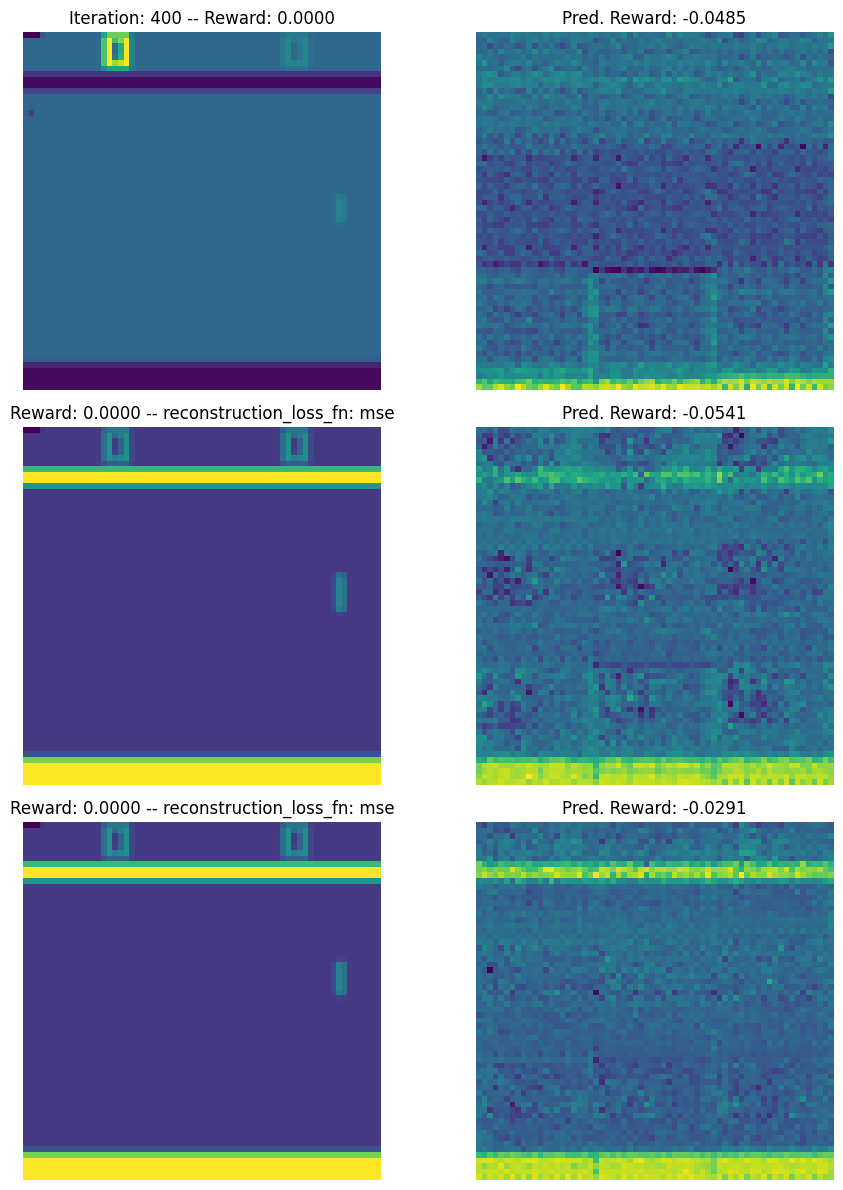

Epoch 5/10: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, Total Loss=0.0525, Recon=0.0341, KL=0.0000, Reward=0.0184]


Epoch 5 completed. Average loss: 0.0646


Epoch 6/10:   0%|          | 0/100 [00:00<?, ?it/s]

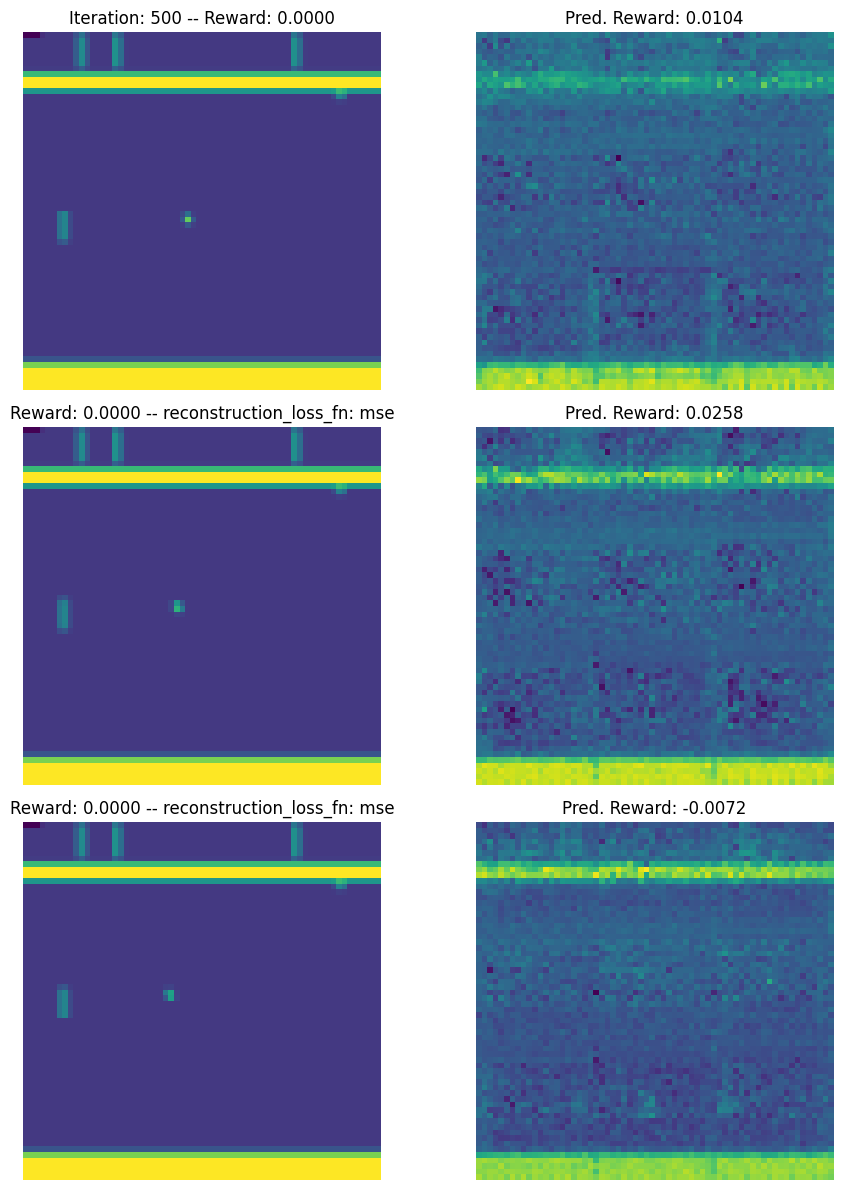

Epoch 6/10: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s, Total Loss=0.0433, Recon=0.0186, KL=0.0000, Reward=0.0247]


Epoch 6 completed. Average loss: 0.0646


Epoch 7/10:   0%|          | 0/100 [00:00<?, ?it/s]

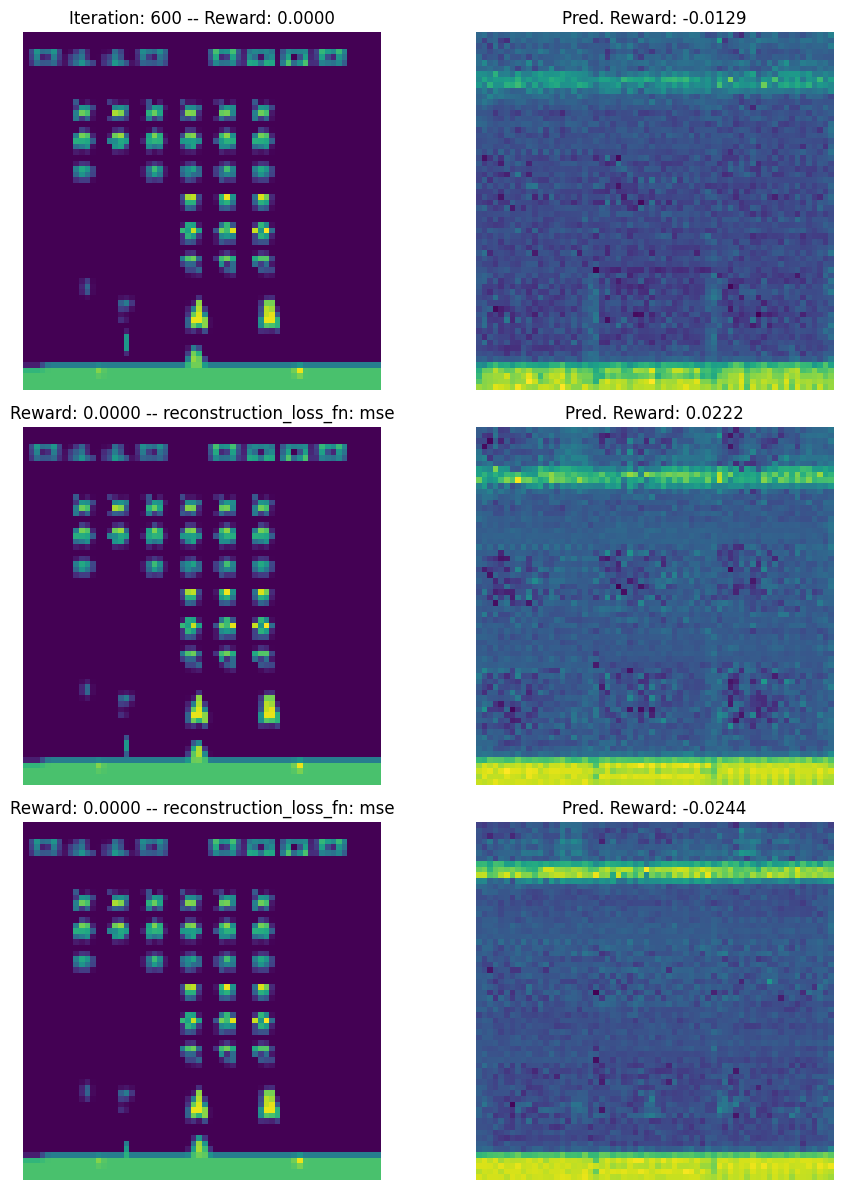

Epoch 7/10: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s, Total Loss=0.0402, Recon=0.0204, KL=0.0000, Reward=0.0198]


Epoch 7 completed. Average loss: 0.0635


Epoch 8/10:   0%|          | 0/100 [00:00<?, ?it/s]

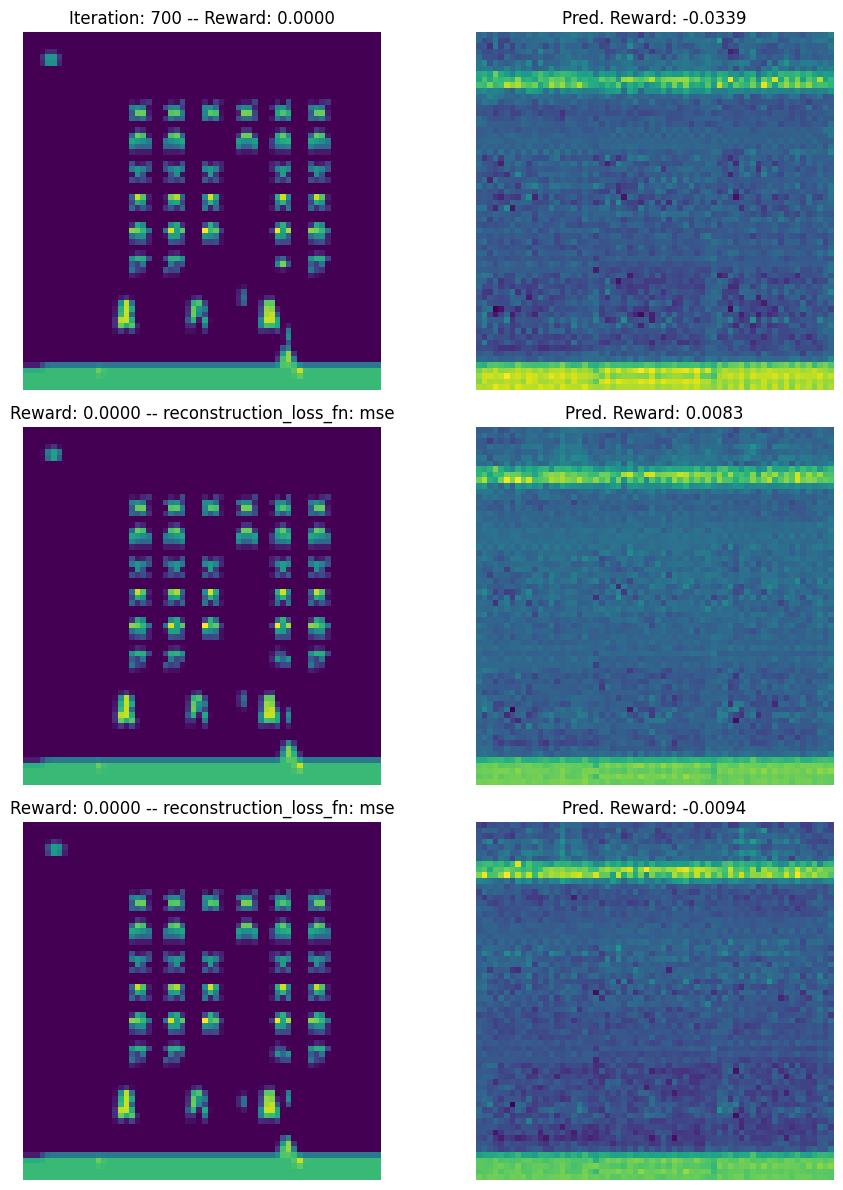

Epoch 8/10: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s, Total Loss=0.0885, Recon=0.0672, KL=0.0000, Reward=0.0212]


Epoch 8 completed. Average loss: 0.0652


Epoch 9/10:   0%|          | 0/100 [00:00<?, ?it/s]

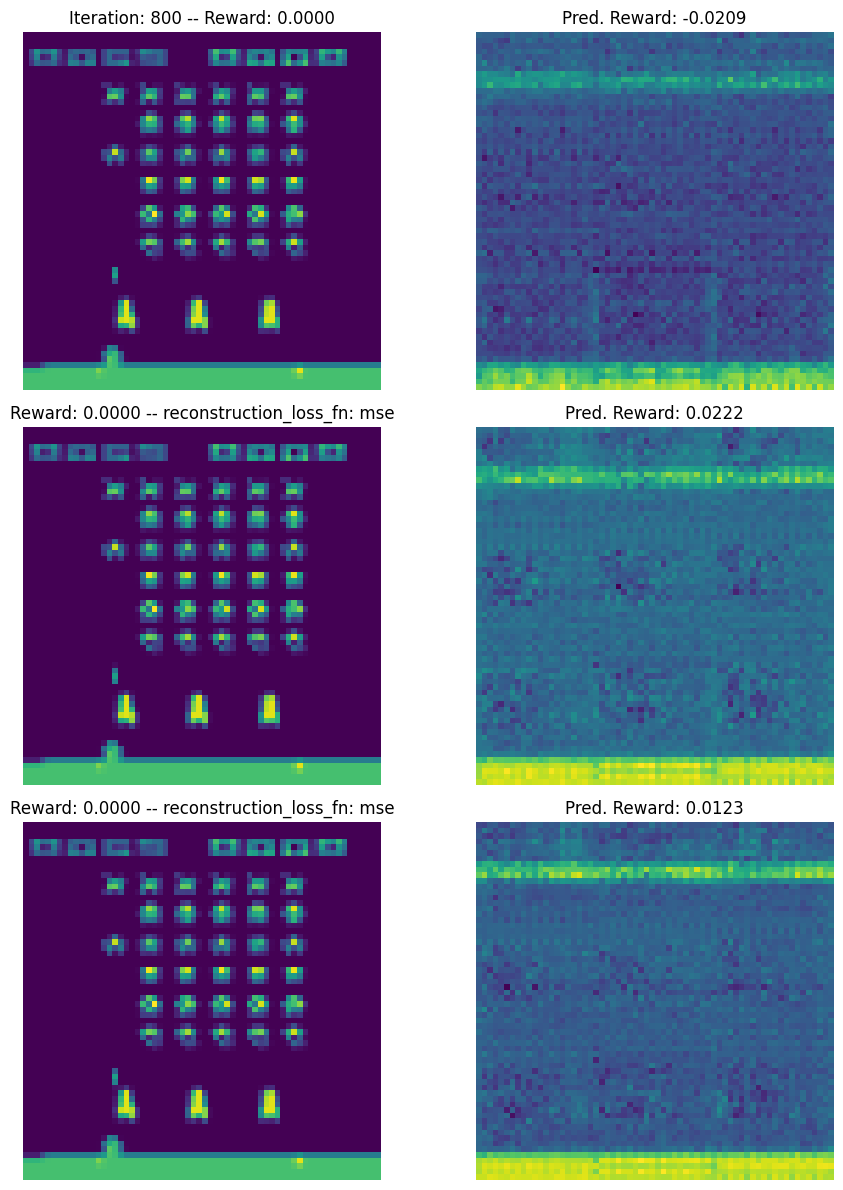

Epoch 9/10: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s, Total Loss=0.0638, Recon=0.0466, KL=0.0000, Reward=0.0173]


Epoch 9 completed. Average loss: 0.0641


Epoch 10/10:   0%|          | 0/100 [00:00<?, ?it/s]

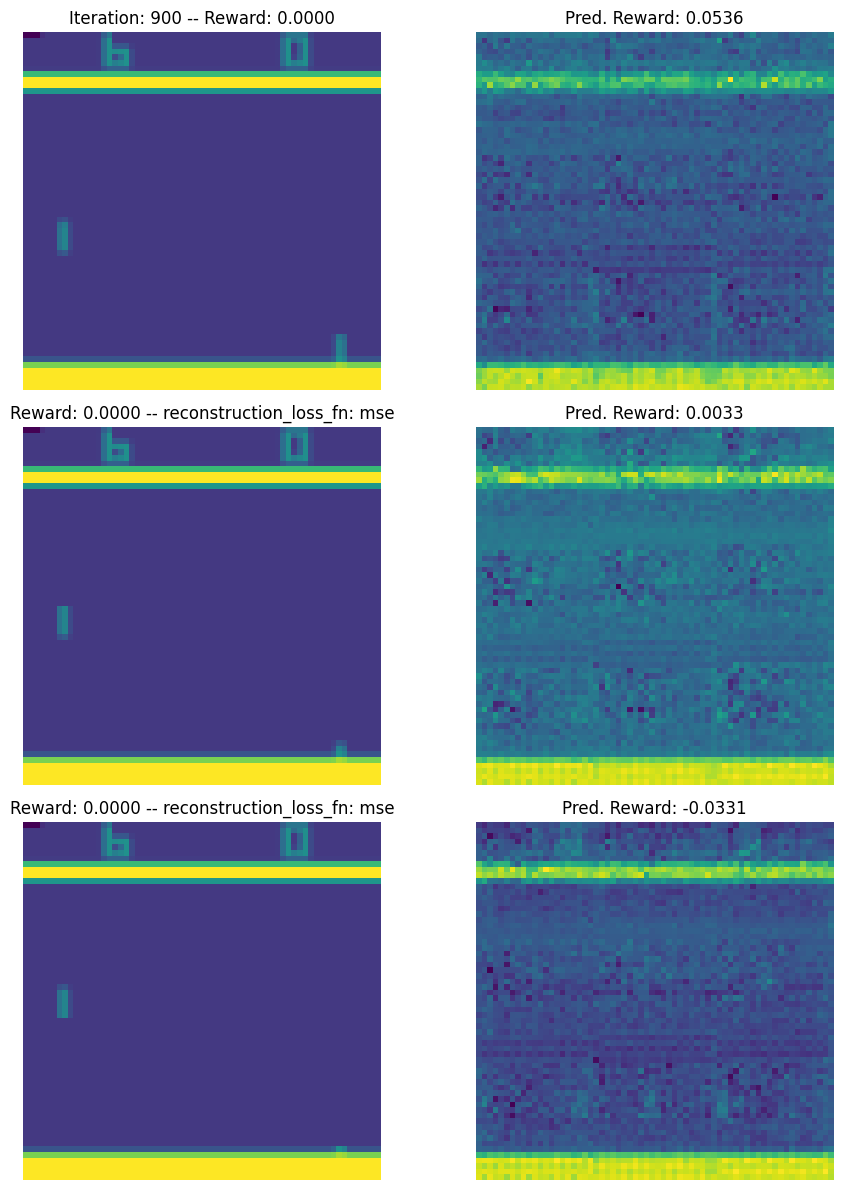

Epoch 10/10: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s, Total Loss=0.0550, Recon=0.0385, KL=0.0000, Reward=0.0165]


Epoch 10 completed. Average loss: 0.0636


=== Training with reconstruction loss: mae ===


Epoch 1/10:   0%|          | 0/100 [00:00<?, ?it/s]

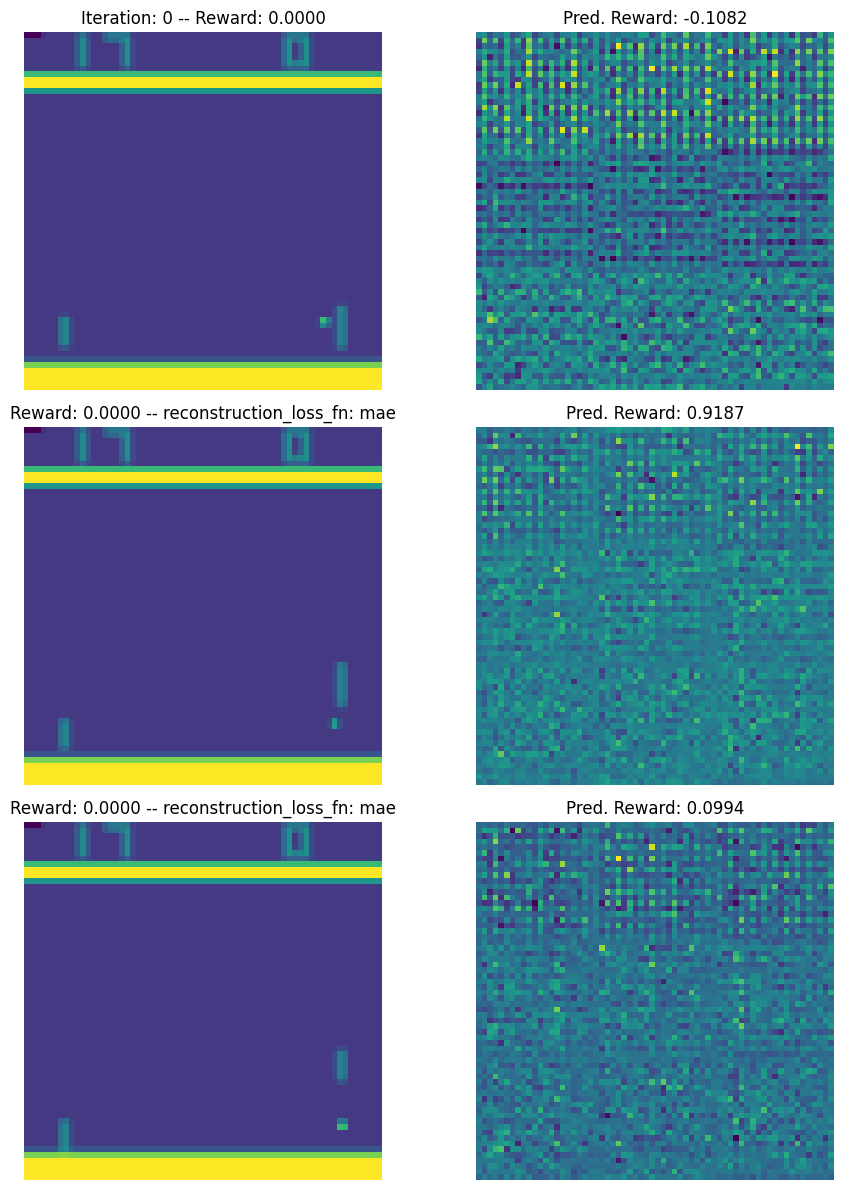

Epoch 1/10: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s, Total Loss=0.2699, Recon=0.2255, KL=0.0017, Reward=0.0427]


Epoch 1 completed. Average loss: 0.4024


Epoch 2/10:   0%|          | 0/100 [00:00<?, ?it/s]

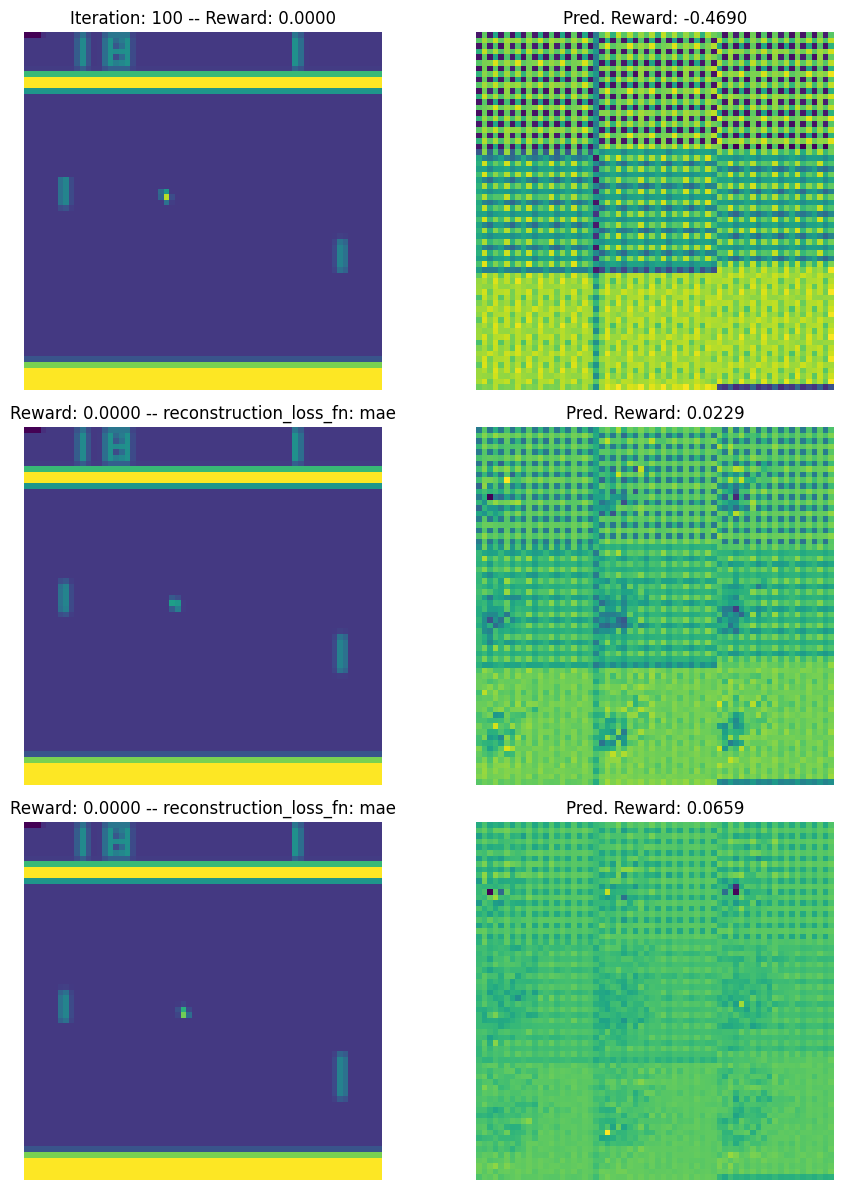

Epoch 2/10:  99%|█████████▉| 99/100 [00:21<00:00,  4.65it/s, Total Loss=0.1520, Recon=0.1269, KL=0.0001, Reward=0.0250]


KeyboardInterrupt: 

In [ ]:
losses = ["mae", "huber", "mse"]
for recons_loss in losses:
    print(f"\n\n=== Training with reconstruction loss: {recons_loss} ===")
    atari_trainer_new = get_new_atari_trainer()

    atari_trainer_new.train(num_epochs=10, reconstruction_loss_fn=recons_loss)